<hr style="border: 1px solid black; width: 100%; margin-left: 0">


<div style="text-align:right"> <b>University of Padua - Department of Physics and Astronomy<b> </div> 
<div style="text-align:right"> <strong> Degree course: </strong> Physics of Data</div>
<div style="text-align:right"><strong>Course: </strong>Management and Analysis of Physics Datasets<b> </div>
<div style="text-align:right"><strong>Year: </strong>2022-2023<b> </div>
<div style="text-align:right"><strong>Professor in charge: </strong> Jacopo Pazzini<b> </div>
    

#### Students:
- Bedin Veronica - 2097013 - veronica.bedin.1@studenti.unipd.it <br>
    $\longrightarrow$ VM Setup, Analysis on RSE, Global Fit, Refined Global fit
- Marchetti Andrea - 2089216 - andrea.marchetti.5@studenti.unipd.it <br>
    $\longrightarrow$VM Setup, Plot Displaying, Dataset Cleansing, Angular Resolution, Optimisation, Performances
- Menti Luca       - 2069534 - luca.menti@studenti.unipd.it  <br>
    $\longrightarrow$ Data Preprocessing, Feature Enrichment, Local Fit, Performances
- Merlin Giovanni - 2091186 - giovanni.merlin@studenti.unipd.it <br>
    $\longrightarrow$ Data Preprocessing, Feature Enrichment, Local Fit, Performances


    
<strong>Exam Date</strong>: 19th  of July 2023
    
<center>
    
# Batch analysis of cosmic rays using Drift Tubes detectors
    
<center>
<hr style="border: 1px solid black; width: 100%; margin-left: 0">

## Introduction

The aim of the project is to analyse data of muon collisions in a drift tube detector, in order to reconstruct the tracks of the particles. The detector comprises of four chambers - each subdivided in four layers - and two scintillators, working in coincidence. Each layer consists of 8 "channels", which are physical cells containing the anode wire. The muons, passing through the channels, ionise the gas contained inside and the free electrons are collect by the wire and generate an electrical signal that indirectly indicate the passage of a particle.

The signals of the detector are digitised by the TDC and collected in 81 binary files.\
We employ a cluster to parallelise the analysis operations and speed up the computations.

## Index
0. Data import
1. Data pre-processing
2. Feature enrichment: Chamber & Layer mapping
3. Feature enrichment: Hit time information
4. Feature enrichment: Left/Right ambiguity and coordinates
5. Local fit and plot
6. Global fit and plot
7. Considerations on the global fit
8. Angular difference
9. Performance Analysis

## Cluster configuration

The first step consists in importing the required packages and configuring the Spark session. This is realised by:
- establishing a connection to the cluster and to the S3 bucket containing the data;
- setting the memory allocated per worker (max 6.8 GB available);
- setting the number of cores per worker (max 4 available).

Then we create a Spark Context to start the Driver application program.

In [5]:
# pyspark
import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import when, col, lag, lit, atan, count, sum, round
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, FloatType

# plots
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams.update({'figure.max_open_warning': 0})

# fit
from scipy.optimize import curve_fit

# data manipulation utilities
import numpy as np
import pandas as pd

# Jupyter utilities
from IPython.display import display, Math, Markdown, Latex

In [6]:
spark = SparkSession.builder \
    .master("spark://10.67.22.35:7077")\
    .appName("Batch analysis project")\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.1')\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.1')\
    .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
    .config("spark.executor.cores", 4)\
    .config("spark.executor.memory", "6900m")\
    .config("spark.sql.shuffle.partitions", 24)\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config('spark.hadoop.fs.s3a.access.key', 'b4109690c3394adab908eb773aad0d0d')\
    .config('spark.hadoop.fs.s3a.secret.key', '6896a10a4a684b519be8699bc187cc48')\
    .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()

In [7]:
sc = spark.sparkContext

## 0) Data import

In [8]:
import time
start_time = time.time()

In [9]:
rdd = sc.binaryRecords('s3a://mapd-minidt-batch/data_*.dat', 8)

23/07/16 17:02:46 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [10]:
# use repartition since the data loading changes the number of partitions to the number of files
rdd = rdd.repartition(24)

In [11]:
def decode(bit_word):
    
    bit_word = int.from_bytes(bit_word, "little") 
    feature = [0,0,0,0,0,0]
    feature[0] = bit_word & 0x1F # TDC
    feature[1] = bit_word >> 5  & 0xFFF # BX
    feature[2] = bit_word >> 17 & 0xFFFFFFFF # ORBIT
    feature[3] = bit_word >> 49 & 0x1FF # CHAN
    feature[4] = bit_word >> 58 & 0x7 # FPGA
    feature[5] = bit_word >> 61 & 0x7 # HEAD
        
    return feature

In [12]:
rdd2 = rdd.map(decode)

In [13]:
# our first action
df = rdd2.toDF(["TDC", "BX", "ORBIT", "CHAN", "FPGA", "HEAD"])

From the UI it results that the total dimension of the files is 808.5 MB.
We can therefore safetly `persist` the dataframe, for its size perfectly fits into the executors' available storage. 
This allows to perform following operations without having to reload the data at each action.
Since `persist` is a transformation, we need to trigger it with an action, for example `count`.

In [14]:
df = df.persist()
df.count()

105973760

### 1) Data preprocessing

At first we:
1) select only the rows that have `HEAD = 2`, since are the only that are associated with timing informations, while the others are ancillary data
2) mark the hits associated with the scintillator activation, and compute the number of total hits and scintillator hits per `ORBIT`

All the other rows are uninformative, and will therefore be discarded.

In [15]:
# 1
df0 = df.where(col('HEAD') == 2)\
        .drop('HEAD')

In [16]:
# 2
df0 = df0.withColumn("scint", when((df0.FPGA == 1) & (df0.CHAN == 128), 1)\
                             .otherwise(0))

In [17]:
# count number of total hits and number of scintillator hits per orbit
data_counts = df0.groupBy('ORBIT').agg(
    count('ORBIT').alias("n_hits"),
    sum('scint').alias("n_scint")
)

### Hits inspection

To understand how we can filter the data, to lighten the computation, we inspect the dataset plotting the histogram of the total hits and of the scintillator hits per orbit, i.e. considering also the orbit in which the scintillators did not register any coincidence or registered more than one coincidence.

In [18]:
"""
# histogram with the counts of hits per orbit

range_min = 0 
range_max = 50
bin_width = 1

raw_bins, raw_counts = data_counts.select('n_hits')\
                                  .rdd\
                                  .histogram(list(np.arange(range_min,range_max,bin_width)))    

print(raw_bins, raw_counts)


fig, ax = plt.subplots(figsize = (7, 6)) 
raw_hits = plt.hist(raw_bins[:-1], raw_bins, weights=raw_counts[:], log=False, color='lightblue', edgecolor='black')

ax.set_xlabel('# Hits', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("# Hits per Orbit", fontsize=20)

ax.set_yscale('log')

plt.savefig('HitsPerOrbit_Raw.png')
"""

'\n# histogram with the counts of hits per orbit\n\nrange_min = 0 \nrange_max = 50\nbin_width = 1\n\nraw_bins, raw_counts = data_counts.select(\'n_hits\')                                  .rdd                                  .histogram(list(np.arange(range_min,range_max,bin_width)))    \n\nprint(raw_bins, raw_counts)\n\n\nfig, ax = plt.subplots(figsize = (7, 6)) \nraw_hits = plt.hist(raw_bins[:-1], raw_bins, weights=raw_counts[:], log=False, color=\'lightblue\', edgecolor=\'black\')\n\nax.set_xlabel(\'# Hits\', fontsize=15)\nax.set_ylabel(\'Counts\', fontsize=15)\nax.set_title("# Hits per Orbit", fontsize=20)\n\nax.set_yscale(\'log\')\n\nplt.savefig(\'HitsPerOrbit_Raw.png\')\n'

In [19]:
"""
# histogram with the counts of scintillator hits per orbit

range_min = 0 
range_max = 50
bin_width = 1


raw_bins, raw_counts = data_counts.select('n_scint')\
                                  .rdd\
                                  .histogram(list(np.arange(range_min,range_max,bin_width)))    
                                  
fig, ax = plt.subplots(figsize = (7, 6)) 
raw_hits = plt.hist(raw_bins[:-1], raw_bins, weights=raw_counts[:], log=False, color='lightblue', edgecolor='black')

#ax.set_ylim(1,5e7)
ax.set_xlim(0,10)
ax.set_xlabel('# Hits', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("# Scint per Orbit", fontsize=20)

ax.set_yscale('log')

plt.savefig('ScintPerOrbit_Raw.png')
"""

'\n# histogram with the counts of scintillator hits per orbit\n\nrange_min = 0 \nrange_max = 50\nbin_width = 1\n\n\nraw_bins, raw_counts = data_counts.select(\'n_scint\')                                  .rdd                                  .histogram(list(np.arange(range_min,range_max,bin_width)))    \n                                  \nfig, ax = plt.subplots(figsize = (7, 6)) \nraw_hits = plt.hist(raw_bins[:-1], raw_bins, weights=raw_counts[:], log=False, color=\'lightblue\', edgecolor=\'black\')\n\n#ax.set_ylim(1,5e7)\nax.set_xlim(0,10)\nax.set_xlabel(\'# Hits\', fontsize=15)\nax.set_ylabel(\'Counts\', fontsize=15)\nax.set_title("# Scint per Orbit", fontsize=20)\n\nax.set_yscale(\'log\')\n\nplt.savefig(\'ScintPerOrbit_Raw.png\')\n'

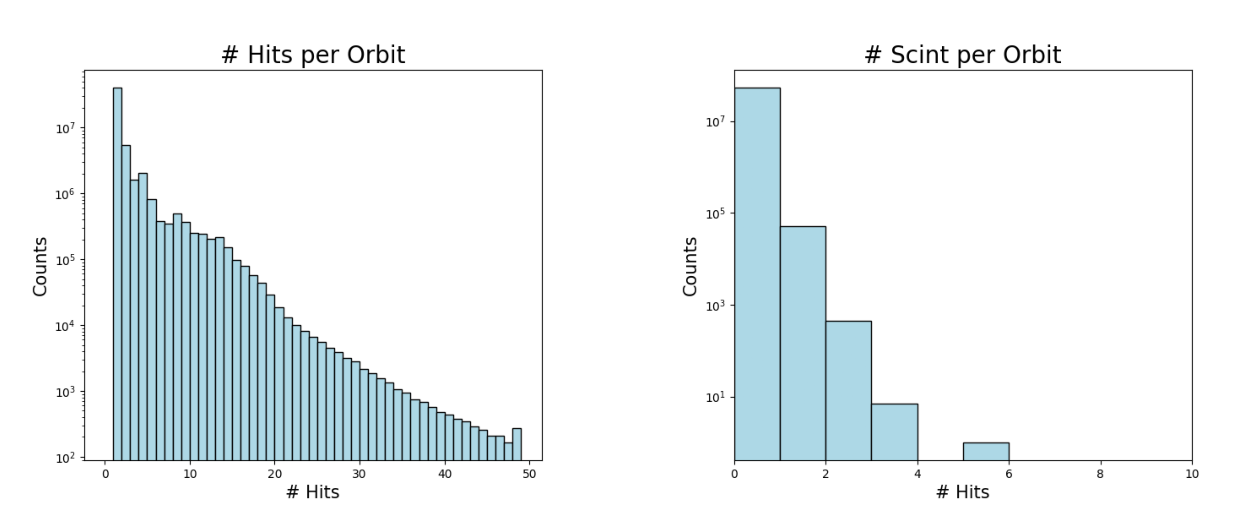

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the first image
img1 = mpimg.imread('HitsPerOrbit_Raw.png')

# Load the second image
img2 = mpimg.imread('ScintPerOrbit_Raw.png')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first image in the first subplot
axes[0].imshow(img1)
axes[0].axis('off')

# Plot the second image in the second subplot
axes[1].imshow(img2)
axes[1].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the images
plt.show()

Here we notice that the large majority of orbits have only one hit, and moreover there are no other clear peaks. This is probably due to the noise of the channels over the muon signal. Indeed, most orbits do not contain any scintillator hit (notice the log scale) and therefore we cannot use them for the analysis, since we cannot associate them to the passage of a muon.\
For this reason, to partially filter the dataset out, _**we select only the rows that are associated with an orbit in which one and only one scintillator coincidence was registered**_. The new histogram is shown below.

In [21]:
# remove all the orbits that have n_scint != 1
# ie that have zero or more than one muon that passed through the scintillators

data_counts = data_counts.where(col('n_scint') == 1)\
                         .drop('n_scint')
# remove unnecessary columns
df0 = df0.drop('scint', 'n_scint')

df0 = df0.join(data_counts, on='ORBIT')

In [22]:
"""

# make histogram with the counts of hits per orbit

range_min = 0 
range_max = 50
bin_width = 1

bins, counts = data_counts.select('n_hits')\
                          .rdd\
                          .histogram(list(np.arange(range_min,range_max,bin_width)))    

print(bins, counts)

fig, ax = plt.subplots(figsize = (7, 6)) 

#bin_centers = bins - np.array([0.5])

hits = plt.hist(bins[:-1], bins, weights=counts, align='mid', color='lightblue', edgecolor='black')

#ax.set_ylim(1,5e7)
#ax.set_xlim(0,32)
ax.set_xlabel('# Hits', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("# Hits per Orbit - # Scint = 1", fontsize=20)

plt.savefig('HitsPerOrbit_Clean.png')
"""

'\n\n# make histogram with the counts of hits per orbit\n\nrange_min = 0 \nrange_max = 50\nbin_width = 1\n\nbins, counts = data_counts.select(\'n_hits\')                          .rdd                          .histogram(list(np.arange(range_min,range_max,bin_width)))    \n\nprint(bins, counts)\n\nfig, ax = plt.subplots(figsize = (7, 6)) \n\n#bin_centers = bins - np.array([0.5])\n\nhits = plt.hist(bins[:-1], bins, weights=counts, align=\'mid\', color=\'lightblue\', edgecolor=\'black\')\n\n#ax.set_ylim(1,5e7)\n#ax.set_xlim(0,32)\nax.set_xlabel(\'# Hits\', fontsize=15)\nax.set_ylabel(\'Counts\', fontsize=15)\nax.set_title("# Hits per Orbit - # Scint = 1", fontsize=20)\n\nplt.savefig(\'HitsPerOrbit_Clean.png\')\n'

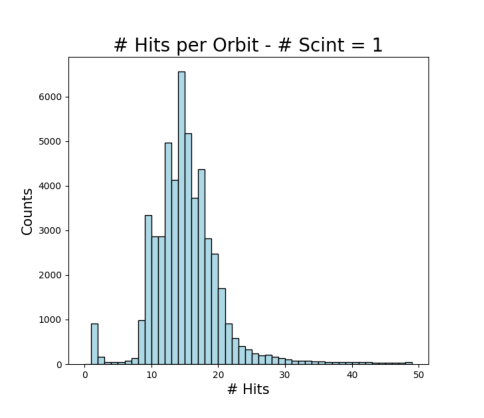

In [23]:
# Load the first image
img3 = mpimg.imread('HitsPerOrbit_Clean.png')

# Create a figure with one subplot
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Plot the image 
axes.imshow(img3)
axes.axis('off')

# Show the image
plt.show()

We see that even if we consider only the orbits that have only one coincidence, we have orbits with a number of active channels greater than 16, which is the maximum that can be accounted for a single muon. These cases might be associated both to noise and/or to the passage of a second muon that, however, didn't pass through the scintillators.\
Since noisy orbits might still have valuable passages, we do not yet filter by the number of hits per orbit (e.g. requiring that `n_hits` < 17) but first we discard all the rows associated with hits in every orbit that are temporally far away from the signal of the scintillators, aiming to reduce even more the noisy hits per orbit.\
To do so we firstly have to associate at each hit the corresponding time information, which is done in __Point 3__.

Before moving to the next point, it is convenient to persist the newly obtained, filtered dataset. Indeed, this is composed of just 803,087 rows, against the 105,973,760 of the raw dataset, and occupies just 4.8 MB in memory, against the 1061 MB of the raw data. At the same time we unpersist the original dataset to free up space in memory.

In [24]:
df0 = df0.persist()
df0.count()

df.unpersist()

#print("Time elapsed:", time.time() - start_time)

DataFrame[TDC: bigint, BX: bigint, ORBIT: bigint, CHAN: bigint, FPGA: bigint, HEAD: bigint]

### 2) Feature enrichment:  Chamber & Layer mapping
Here we add the `CHAMBER` feature from the given mapping using the `FPGA` and `CHANNEL` features, and also add the `LAYER` feature.

In [25]:
# associate to each hit the corresponding chamber

df1 = df0.withColumn("CHAMBER", 
                   when((col('FPGA') == 0) & (col('CHAN').between(0, 63)), 0)
                   .when((col('FPGA') == 0) & (col('CHAN').between(64, 127)), 1)
                   .when((col('FPGA') == 1) & (col('CHAN').between(0, 63)), 2)
                   .when((col('FPGA') == 1) & (col('CHAN').between(64, 127)), 3)
                   .otherwise(None))\
         .withColumn("LAYER",
                    when(col('CHAN')%4 == 0, 4)
                     .when(col('CHAN')%4 == 2, 3)
                     .when(col('CHAN')%4 == 1, 2)
                     .when(col('CHAN')%4 == 3, 1)
                     .otherwise(None))\
         .drop('FPGA')
# drop null values to have correct following computations
#df1 = df1.na.drop()

### 3)  Feature enrichment: Hit time information
Here we add the absolute time feature `t` (in ns) from the `ORBIT`, `BX`, and `TDC` features. 

We also add the `t_scint` column which report the scintillator timing for every orbit. This is done using a __grouped map__ (via `applyInPandas` method) as aggregator on the `ORBIT` feature. The map is a python function that replicates the `t_scint` timing value associated to the scintillator to all the other hit rows of each `ORBIT` group. To do this also the schema of the DataFrame has to be passed.

In [26]:
# define a python function to replicate the scintillator timing

def scint(orbit: pd.DataFrame) -> pd.DataFrame:
    
    t_scint = orbit[orbit.CHAN == 128].t.values # retrieve the t value from CHAN=128 for the orbit 
    
    orbit['t_scint'] = np.repeat(t_scint, orbit.shape[0])
    
    return orbit

In [27]:
df2 = df1.withColumn("t", col("ORBIT")*3564*25 + col("BX")*25 + col("TDC")*(25/30))\
         .withColumn("t_scint", col("CHAMBER")*0.0)\
         .drop('TDC','BX')

schema = "ORBIT int, CHAN int, n_hits int,\
          CHAMBER int, LAYER int, t double, t_scint double" 

In [28]:
# apply the grouped map
df2 = df2.groupBy("ORBIT")\
         .applyInPandas(scint, schema)

Now we can add a new feature `delta_t` to the dataframe, which is the time difference (in ns) between the time registered by the scintillator and the signal from the channels. In particular, we correct by the timing offset of the scintillator for each chamber.

In [29]:
# scintillator time offset by Chamber
offset = {
    0: 95.0 - 1.1, # Ch 0
    1: 95.0 + 6.4, # Ch 1
    2: 95.0 + 0.5, # Ch 2
    3: 95.0 - 2.6, # Ch 3
}

df3 = df2.withColumn("Delta_t", 
                     when(col('CHAMBER') == 0, col('t') - col('t_scint') + offset[0])
                     .when(col('CHAMBER') == 1, col('t') - col('t_scint') + offset[1])
                     .when(col('CHAMBER') == 2, col('t') - col('t_scint') + offset[2])
                     .when(col('CHAMBER') == 3, col('t') - col('t_scint') + offset[3])
                     .otherwise(None))\
                     .drop('t','t_scint')

# drop null values to have correct following computations
df3 = df3.na.drop()

Knowing the specifics, we can select those hits that are temporally near the scintillator signal: in fact, if the time difference is greater than the time for the electrons to cross the distance between the cathode and the anode (which is the wire at the center of each cell), we can discard that hit, since if it unphysical.\
This time can be easily computed knowing the drift velocity of the electrons and the width of the cell: ($w = 42 \, \text{mm}$), $v_{drift} = 53.8 \cdot 10^{-3} \text{mm}/\text{ns}$, and is approximately 390 ns.

Indeed we can verify the distribution of the hit delays by making a plot, show below.

In [30]:
"""

# make histogram with the distribution of time differences

range_min = -100 
range_max = 800
bin_width = 10

new_bins, new_counts = df3.select('Delta_t').rdd\
                            .histogram(list(np.arange(range_min,range_max,bin_width)))    

#print(new_bins, new_counts)

fig, ax = plt.subplots(figsize = (7, 6)) 

#bin_centers = new_bins - np.array([0.5])

hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue', edgecolor='black')

#ax.set_ylim(1,5e7)
#ax.set_xlim(0,32)
ax.set_xlabel('Time Difference (ns)', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Hit delay", fontsize=20)

plt.savefig('DeltaT.png')
"""

'\n\n# make histogram with the distribution of time differences\n\nrange_min = -100 \nrange_max = 800\nbin_width = 10\n\nnew_bins, new_counts = df3.select(\'Delta_t\').rdd                            .histogram(list(np.arange(range_min,range_max,bin_width)))    \n\n#print(new_bins, new_counts)\n\nfig, ax = plt.subplots(figsize = (7, 6)) \n\n#bin_centers = new_bins - np.array([0.5])\n\nhits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align=\'mid\', color=\'lightblue\', edgecolor=\'black\')\n\n#ax.set_ylim(1,5e7)\n#ax.set_xlim(0,32)\nax.set_xlabel(\'Time Difference (ns)\', fontsize=15)\nax.set_ylabel(\'Counts\', fontsize=15)\nax.set_title("Hit delay", fontsize=20)\n\nplt.savefig(\'DeltaT.png\')\n'

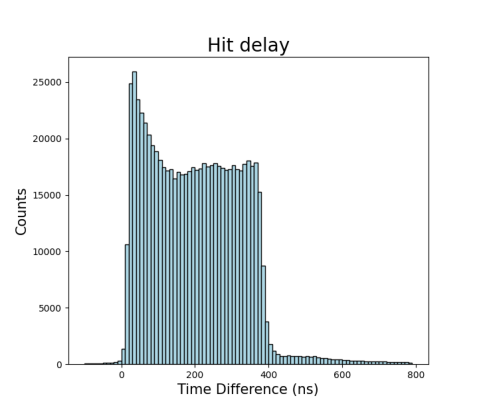

In [31]:
# Load the first image
img3 = mpimg.imread('DeltaT.png')

# Create a figure with one subplot
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Plot the image 
axes.imshow(img3)
axes.axis('off')

# Show the image
plt.show()

As expected, almost all hit delays are in the range 0 - 390 ns. The others correspond to noise, and hence we can drop them.

In [32]:
df3 = df3.where((col('Delta_t') >= 0) & (col('Delta_t') < 391))

Having filtered in time, we recompute the histogram of the hits per orbit.

In [33]:
"""
# make histogram with the counts of hits per orbit

df3 = df3.groupBy('ORBIT').count()

range_min = 0 
range_max = 50
bin_width = 1

new_bins, new_counts = df3.select('count').rdd\
                            .histogram(list(np.arange(range_min,range_max,bin_width)))    

#print(new_bins, new_counts)

fig, ax = plt.subplots(figsize = (7, 6)) 

#bin_centers = new_bins - np.array([0.5])

hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue', edgecolor='black')

#ax.set_ylim(1,5e7)
#ax.set_xlim(0,32)
ax.set_xlabel('# Hits', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("# Hits per Orbit - Time-Cleaned", fontsize=20)

plt.savefig('HitsPerOrbit_Clean2.png')
"""

'\n# make histogram with the counts of hits per orbit\n\ndf3 = df3.groupBy(\'ORBIT\').count()\n\nrange_min = 0 \nrange_max = 50\nbin_width = 1\n\nnew_bins, new_counts = df3.select(\'count\').rdd                            .histogram(list(np.arange(range_min,range_max,bin_width)))    \n\n#print(new_bins, new_counts)\n\nfig, ax = plt.subplots(figsize = (7, 6)) \n\n#bin_centers = new_bins - np.array([0.5])\n\nhits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align=\'mid\', color=\'lightblue\', edgecolor=\'black\')\n\n#ax.set_ylim(1,5e7)\n#ax.set_xlim(0,32)\nax.set_xlabel(\'# Hits\', fontsize=15)\nax.set_ylabel(\'Counts\', fontsize=15)\nax.set_title("# Hits per Orbit - Time-Cleaned", fontsize=20)\n\nplt.savefig(\'HitsPerOrbit_Clean2.png\')\n'

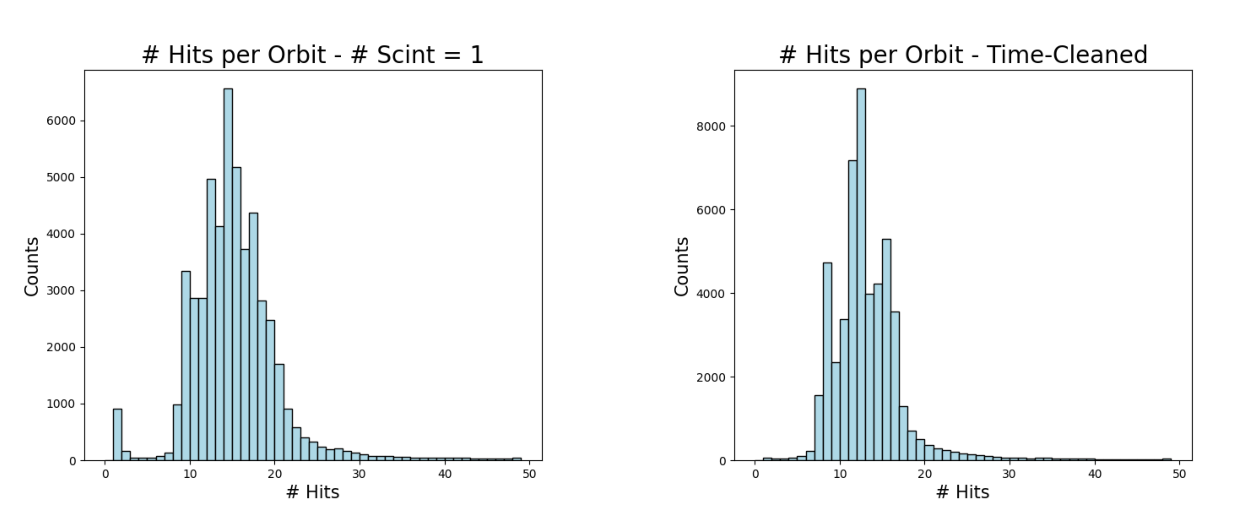

In [34]:
# Load the first image
img1 = mpimg.imread('HitsPerOrbit_Clean.png')

# Load the second image
img2 = mpimg.imread('HitsPerOrbit_Clean2.png')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first image in the first subplot
axes[0].imshow(img1)
axes[0].axis('off')

# Plot the second image in the second subplot
axes[1].imshow(img2)
axes[1].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the images
plt.show()

From the comparison with the previous result (to the left) we see that the number of orbits with a large number of hits has reduced (while at the same time those with a lower number of hits has increased).

We can now safetly filter out the orbits that have more than 17 hits (4 layers in 4 chambers + 1 scintillator hit): at this point these could only correspond to multiple muons or residual channel noise.

We discard the `n_hits < 3` rows since for the four possible combinations of points associated with 2 hits, every linear interpolation would be exact, therefore we could not guess which one is the most probable.

In [35]:
df3 = df3.where((col('n_hits') > 3) & (col('n_hits') < 18))\
         .drop('n_hits')

### 4)  Feature enrichment: Left/Right ambiguity and coordinates
Having computed `Delta_t`, we add to the dataframe the $x$ coordinates of the hits. Notice that at this stage we still have the ambiguity on the verse of the position, therefore for each row the `XLEFT` and `XRIGHT` features are added. In order to obtain them, we used the reference frame proposed in the guidelines, in which the origin is approximately at the center of each chamber. Moreover, we use the given specifics for the width ($w = 42 \, \text{mm}$) and height ($h = 13 \, \text{mm})$ of each cell.

Each coordinate is calculated as the difference of the distance traveled by the electrons from the center of each cell, where the distance traveled is calculated knowing the drift velocity of the eletrons: $v_{drift} = 53.8 \cdot 10^{-3} \text{mm}/\text{ns}$.\
Then the distance is simply:

$$
\Delta x = \left( t_{TDC} - t_{scint}\right) \cdot v_{drift}
$$

Then we also add to the dataframe a new column with the `Z` coordinate for each cell, which is simply found knowing the height of the cells and the elevation of the chambers.

In [36]:
# add specifics
w = 42 # mm
vd = 53.8e-3 # mm/ns
h = 13 # mm

# shift of the reference frame for each Chamber (x, y, z)
shift_chamber = {
    0: {'x': 0, 'y': 0, 'z': 219.8},  # Ch 0
    1: {'x': 0, 'y': 0, 'z': 977.3},  # Ch 1
    2: {'x': 0, 'y': 0, 'z': 1035.6},  # Ch 2
    3: {'x': 0, 'y': 0, 'z': 1819.8},  # Ch 3
}

In [37]:
z_shift = [value['z'] for value in shift_chamber.values()]

In [38]:
df4 = df3.withColumn("XLEFT",
                    when((col("LAYER") == 4) | (col("LAYER") == 2), (((col("CHAN")%64)/4).astype('int') - 7 - 0.5)*w - col("Delta_t")*vd)
                     .when((col("LAYER") == 3) | (col("LAYER") == 1), (((col("CHAN")%64)/4).astype('int') - 7)*w - col("Delta_t")*vd)
                     .otherwise(None))\
         .withColumn("XRIGHT",
                    when((col("LAYER") == 4) | (col("LAYER") == 2), (((col("CHAN")%64)/4).astype('int') - 7 - 0.5)*w + col("Delta_t")*vd)
                     .when((col("LAYER") == 3) | (col("LAYER") == 1), (((col("CHAN")%64)/4).astype('int') - 7)*w + col("Delta_t")*vd)
                     .otherwise(None))\
         .drop("CHAN")

# drop null values to have correct following computations
df4 = df4.na.drop()

In [39]:
df4 = df4.withColumn("Z",
        when(col("CHAMBER") == 0,
            when(col("LAYER") == 1, shift_chamber[0]['z'] - 1.5*h)
            .when(col("LAYER") == 2, shift_chamber[0]['z'] - 0.5*h)
            .when(col("LAYER") == 3, shift_chamber[0]['z'] + 0.5*h)
            .when(col("LAYER") == 4, shift_chamber[0]['z'] + 1.5*h)
        )
        .when(col("CHAMBER") == 1,
            when(col("LAYER") == 1, shift_chamber[1]['z'] - 1.5*h)
            .when(col("LAYER") == 2, shift_chamber[1]['z'] - 0.5*h)
            .when(col("LAYER") == 3, shift_chamber[1]['z'] + 0.5*h)
            .when(col("LAYER") == 4, shift_chamber[1]['z'] + 1.5*h)
        )
        .when(col("CHAMBER") == 2,
            when(col("LAYER") == 1, shift_chamber[2]['z'] - 1.5*h)
            .when(col("LAYER") == 2, shift_chamber[2]['z'] - 0.5*h)
            .when(col("LAYER") == 3, shift_chamber[2]['z'] + 0.5*h)
            .when(col("LAYER") == 4, shift_chamber[2]['z'] + 1.5*h)
        )
        .when(col("CHAMBER") == 3,
            when(col("LAYER") == 1, shift_chamber[3]['z'] - 1.5*h)
            .when(col("LAYER") == 2, shift_chamber[3]['z'] - 0.5*h)
            .when(col("LAYER") == 3, shift_chamber[3]['z'] + 0.5*h)
            .when(col("LAYER") == 4, shift_chamber[3]['z'] + 1.5*h)
        )
        .otherwise(None))

# drop null values to have correct following computations
df4 = df4.na.drop()

### 5) Local fit and plot

Firstly we add the features summarising the results of the fit, namely:
- `XTRUE` which is the chosen x coordinate between `XLEFT` and `XRIGHT`
- `m` for the slope of the line
- `q` for the intercept
- `RSE` for the residual standard error

Then the local fit is performed on grouping by `ORBIT` and `CHAMBER` via a `applyInPandas`.

In [40]:
df5 = df4.withColumn("XTRUE", col("CHAMBER")*0.0)\
         .withColumn("m", col("CHAMBER")*0.0)\
         .withColumn("q", col("CHAMBER")*0.0)\
         .withColumn("RSE", col("CHAMBER")*0.0)  

In [41]:
def fit_loc(group):
    if (group['LAYER'].nunique() > 2) and (group['LAYER'].nunique() == group.shape[0]):
        xl_val = np.asarray(group.XLEFT.values)
        xr_val = np.asarray(group.XRIGHT.values)
        y = np.asarray(group.Z)
        n = group.shape[0]
        
        if n != 3 and n != 4: 
            print("group does not have the correct dimension!")
        
        else:
        
            stack = np.column_stack((xl_val, xr_val)) # stack the columns with xleft and xright coord aside

            x = np.array(np.meshgrid(*stack)).reshape(n,-1) # generate all combinations of xleft/xright
                                                                     # as a n*2^n array

            A = np.vstack((y, np.ones_like(y))).T # A is the matrix with z values as first column

            coeffs, residuals, _, _ = np.linalg.lstsq(A, x, rcond=None)# return an array 2*n with the (a,b) coefficients 
                                                          # for all possible interpolations 
                                                          # (lstsq works column by column)
                                                          # and compute residuals for all combinations
            final_i = np.argmin(residuals) # choose the combination with least residuals as best combination
            ssr = residuals[final_i] 

            m = 1 / coeffs[0][final_i]
            q = - coeffs[1][final_i] / coeffs[0][final_i]

            group['XTRUE'] = x.T[final_i]
            group['m'] = np.repeat(m, group.shape[0])
            group['q'] = np.repeat(q, group.shape[0])
            group['RSE'] = np.repeat(np.sqrt(ssr/(n-2)), group.shape[0]) 

        return group
    else:
        return pd.DataFrame({
            'ORBIT': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'Delta_t': [None],
            'XLEFT': [None],
            'XRIGHT': [None],
            'Z': [None],
            'XTRUE': [None],
            'm': [None],
            'q': [None],
            'RSE': [None]
        })

In [42]:
schema = "ORBIT int, CHAMBER int, LAYER int, Delta_t double, \
            XLEFT double, XRIGHT double, Z double, XTRUE double, m double, q double, RSE double"

df6 = df5.groupBy("ORBIT","CHAMBER").applyInPandas(fit_loc, schema)

Here it is necessary to persist the newly obtained dataframe, otherwise the plot production results extremely slow.

In [43]:
#df8 = df8.na.drop()
df6 = df6.drop('Delta_t')

# persist the dataframe in memory for speed up
# and trigger with an action
df6 = df6.persist()
df6.count()

df0.unpersist()

#print("Time elapsed:", time.time() - start_time)

DataFrame[ORBIT: bigint, TDC: bigint, BX: bigint, CHAN: bigint, FPGA: bigint, n_hits: bigint]

In [44]:
def plot_loc(event) :
    fig, ax = plt.subplots(figsize = (25, 4.5)) 

    x_rect = np.arange(-8*w, 8*w, w)
    z_rect = np.arange(-2*h, 2*h, h) 
    
    ax.set_xlim(-9*w, 9*w)
    ax.set_ylim(-2*h, 2*h)
    
    for i in range(4):
        if i % 2 == 0:
            x = x_rect + w/2
        else:
            x = x_rect 
        for j in range(16):
            ax.add_patch(Rectangle((x[j], z_rect[i]), w, h, lw = 3, edgecolor = 'gray', facecolor = 'none'))    
        
    xr, xl, z = event.XRIGHT, event.XLEFT, event.Z.to_numpy() - z_shift[event.CHAMBER.iloc[0]]
    m, q = event.m.iloc[0], event.q.iloc[0] - z_shift[event.CHAMBER.iloc[0]]
    
    ax.scatter(xr, z, c = "black" , s = 50, linewidth = 1, label = 'XRIGHT') 
    ax.scatter(xl, z, c = "black" , s = 50, linewidth = 1, label = 'XLEFT') 
    
    xb = event.XTRUE.to_numpy()
    ax.scatter(xb, z, c = "red", s = 100, marker='x', linewidth = 2, label = 'XTRUE')
    
    zmin = -3*h # choose z limits for the segment of the line 
    zmax = 3*h

    ax.plot([(zmin - q)/m, (zmax - q)/m], [zmin, zmax], c='red', label = 'local fit', linewidth = 1)
 
        
    ax.set_title(f'ORBIT {event.ORBIT.iloc[0]}, CHAMBER {event.CHAMBER.iloc[0]}, RSE {event.RSE.iloc[0]}', fontsize = 20)
    ax.legend(loc = 'upper left', fontsize = 15)
    ax.axis('equal')  # Set the axes on the same scale
    return ax


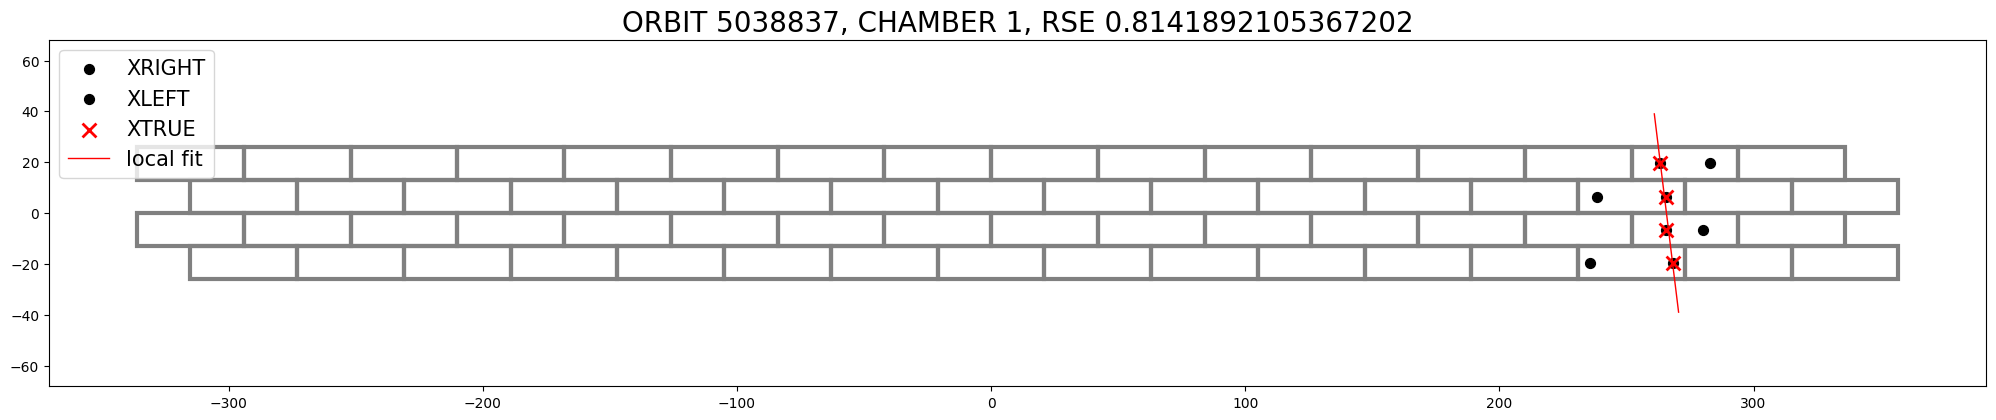

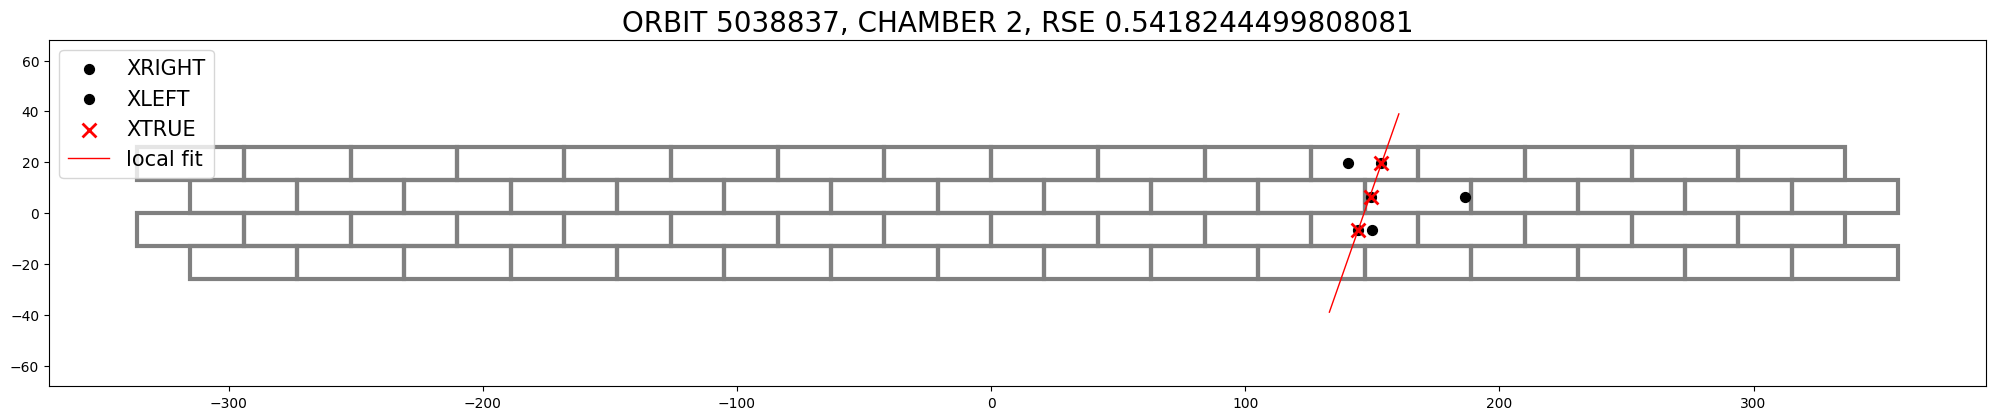

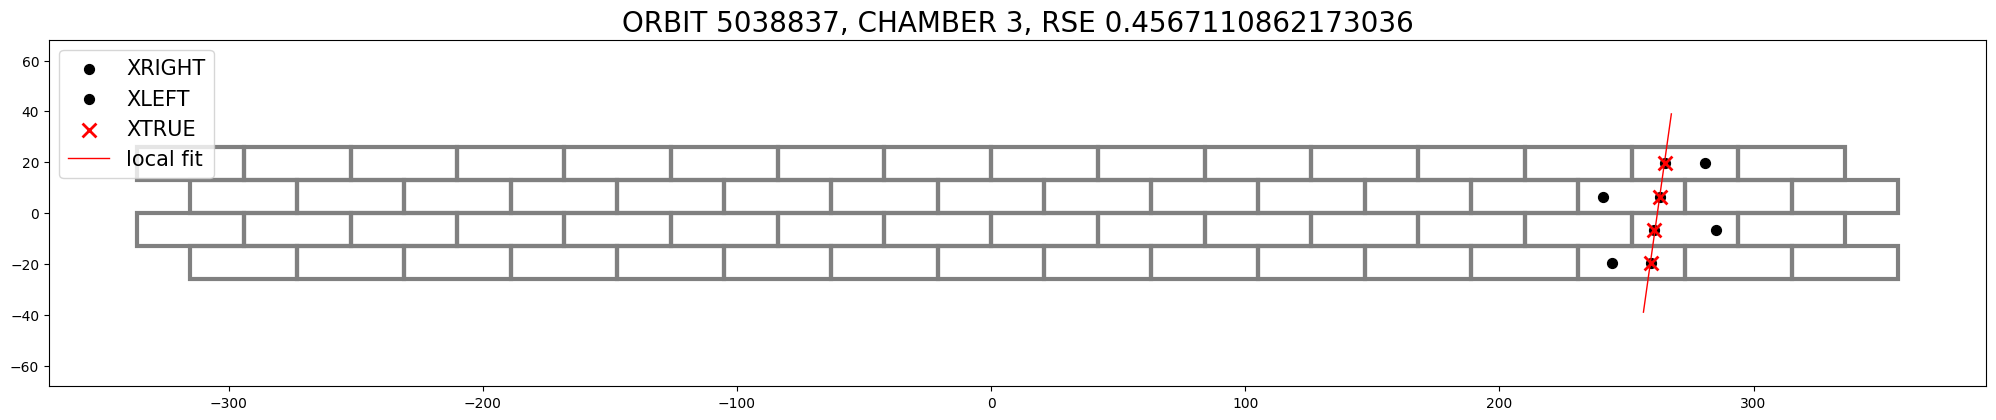

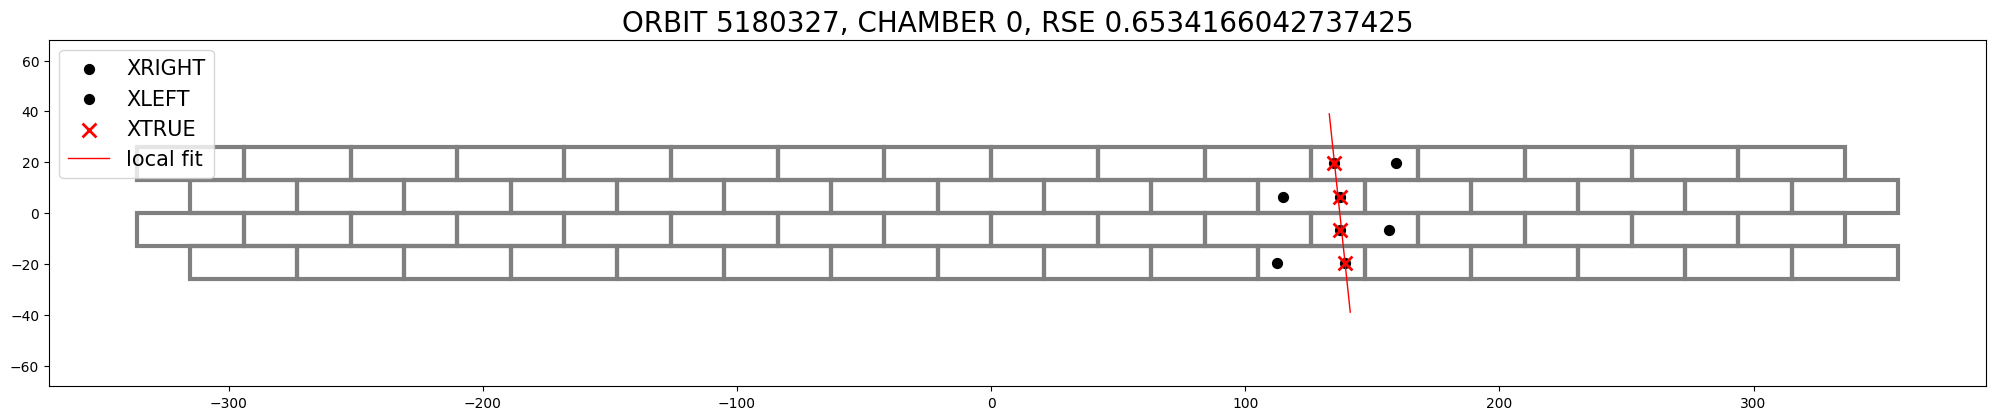

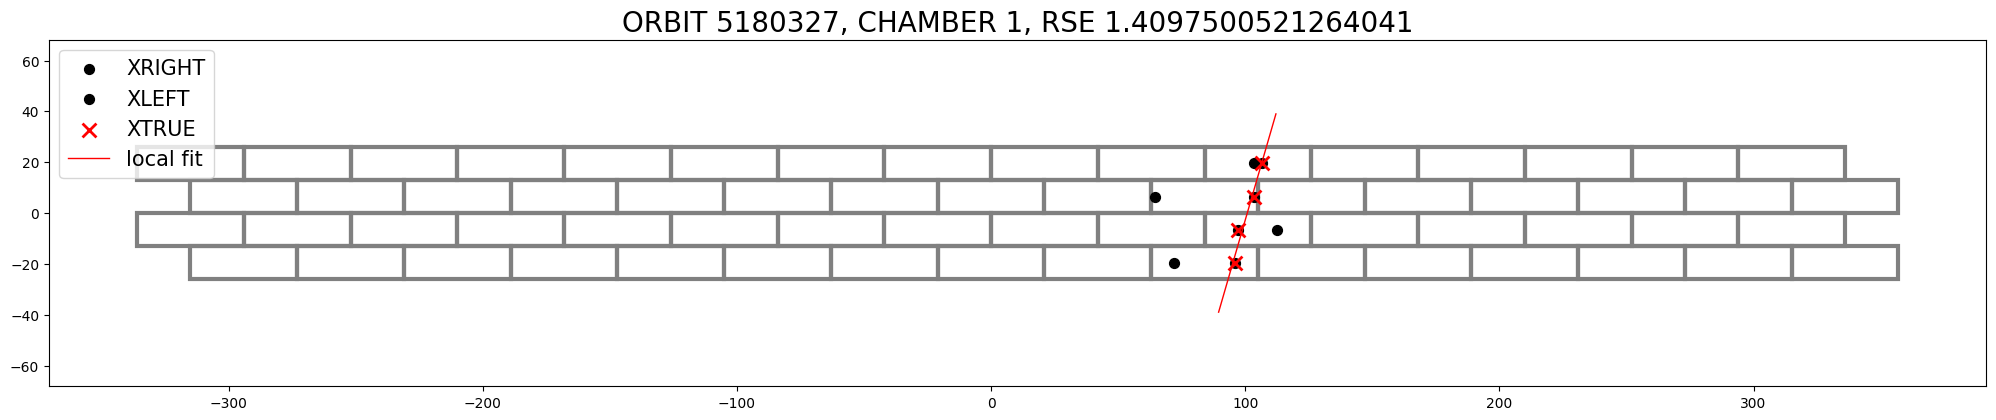

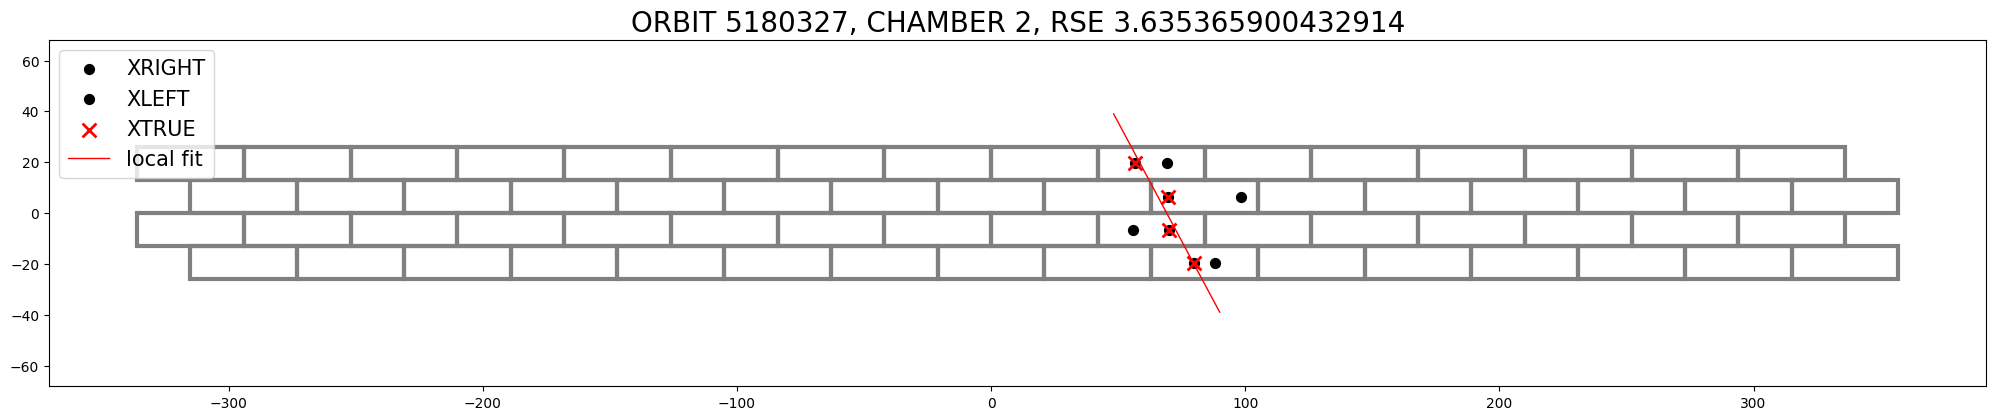

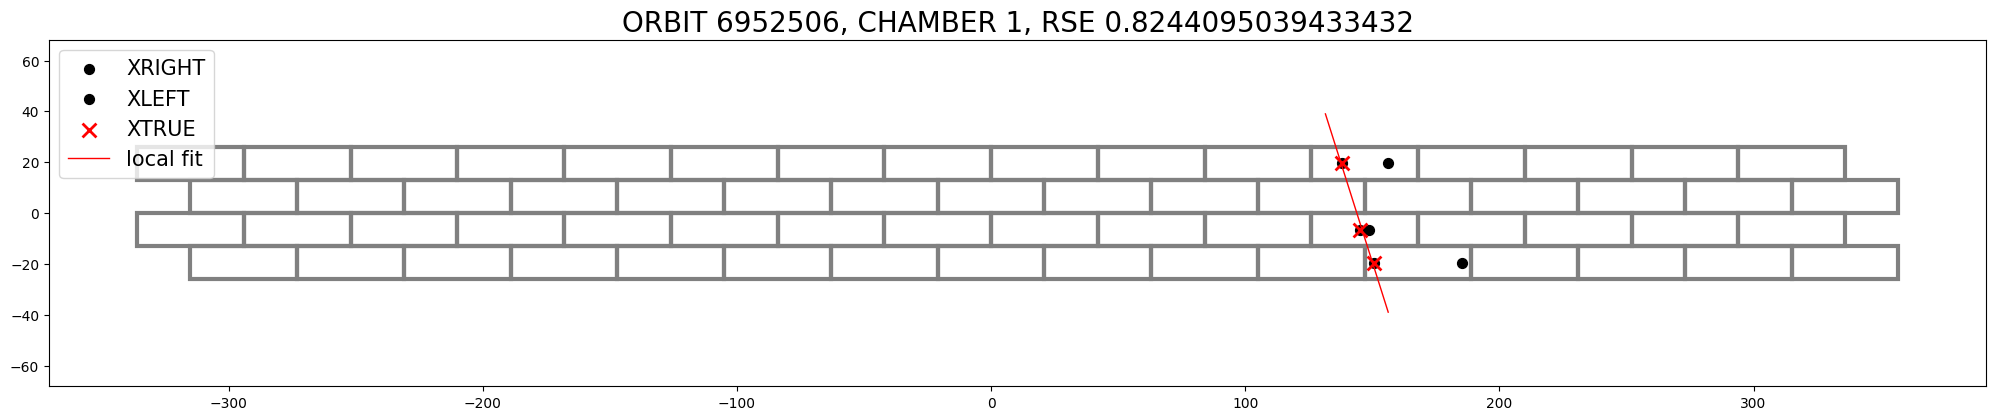

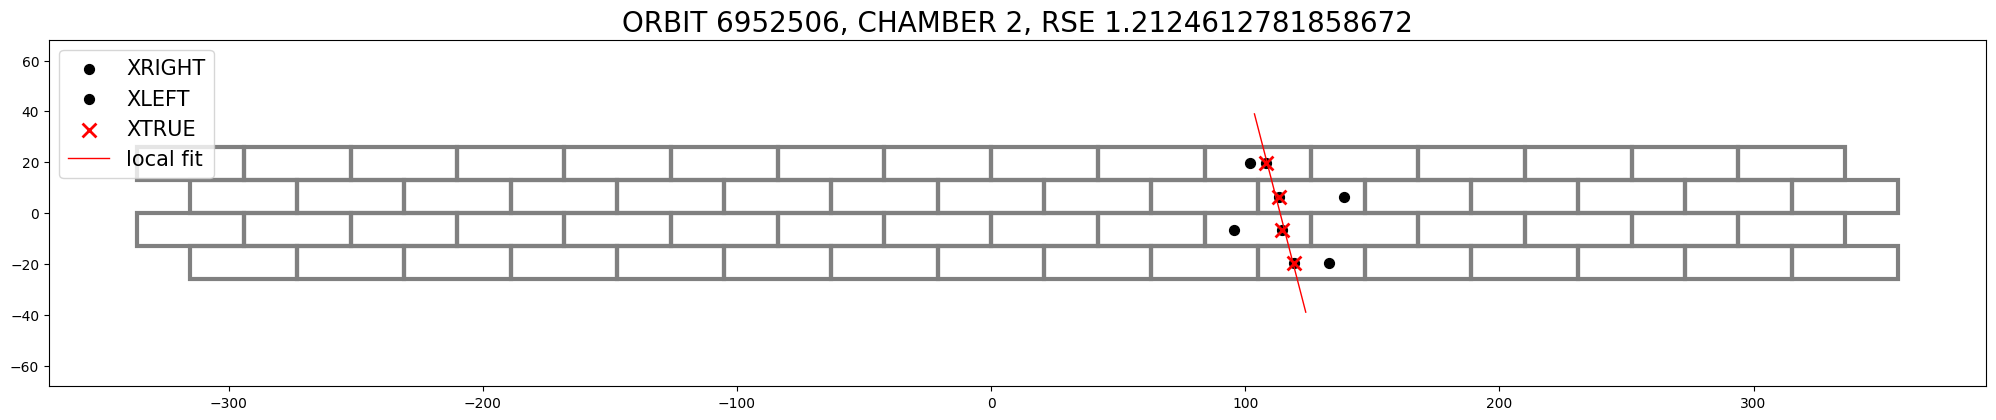

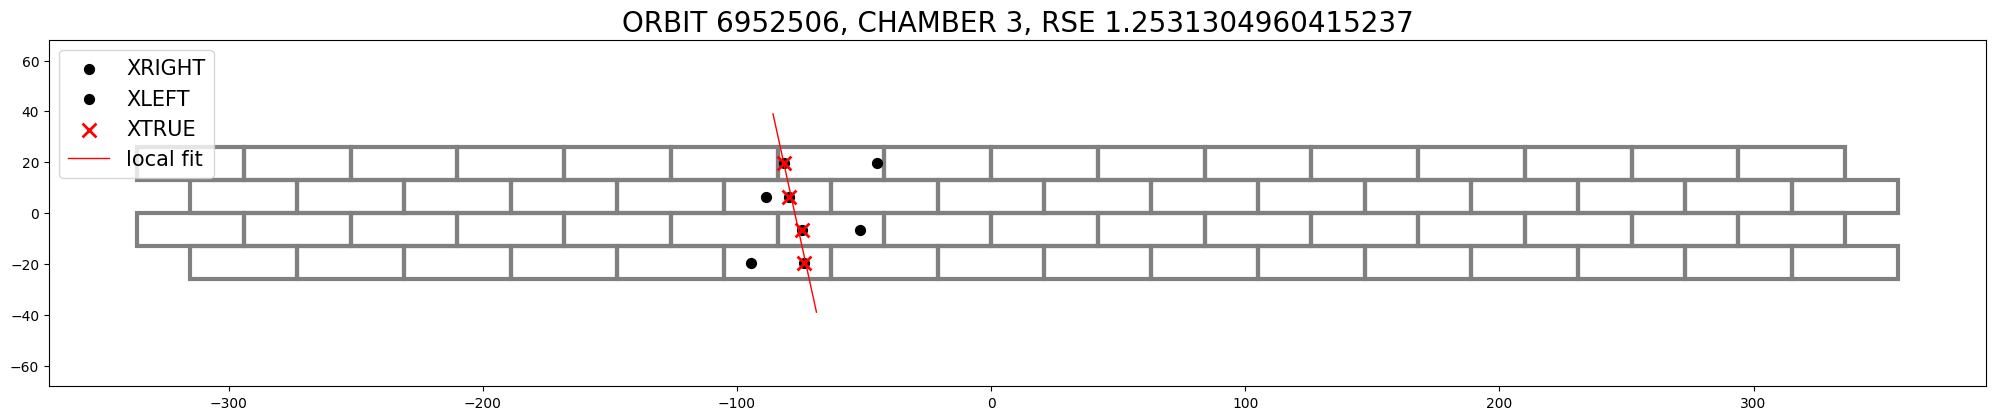

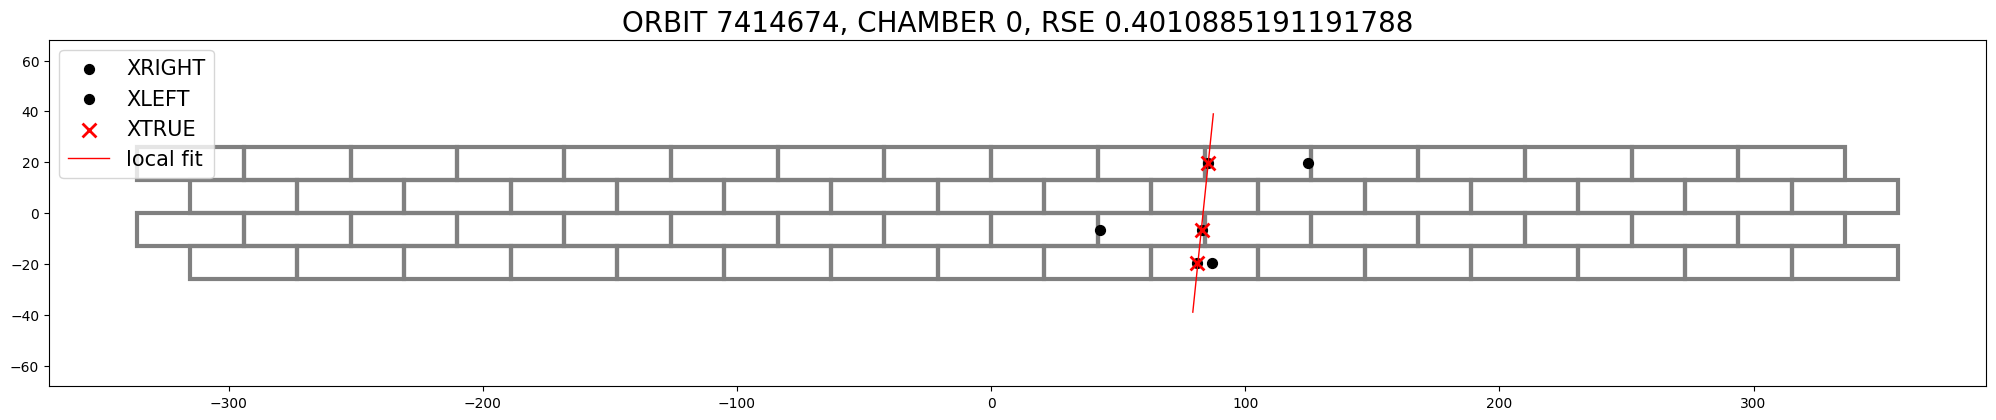

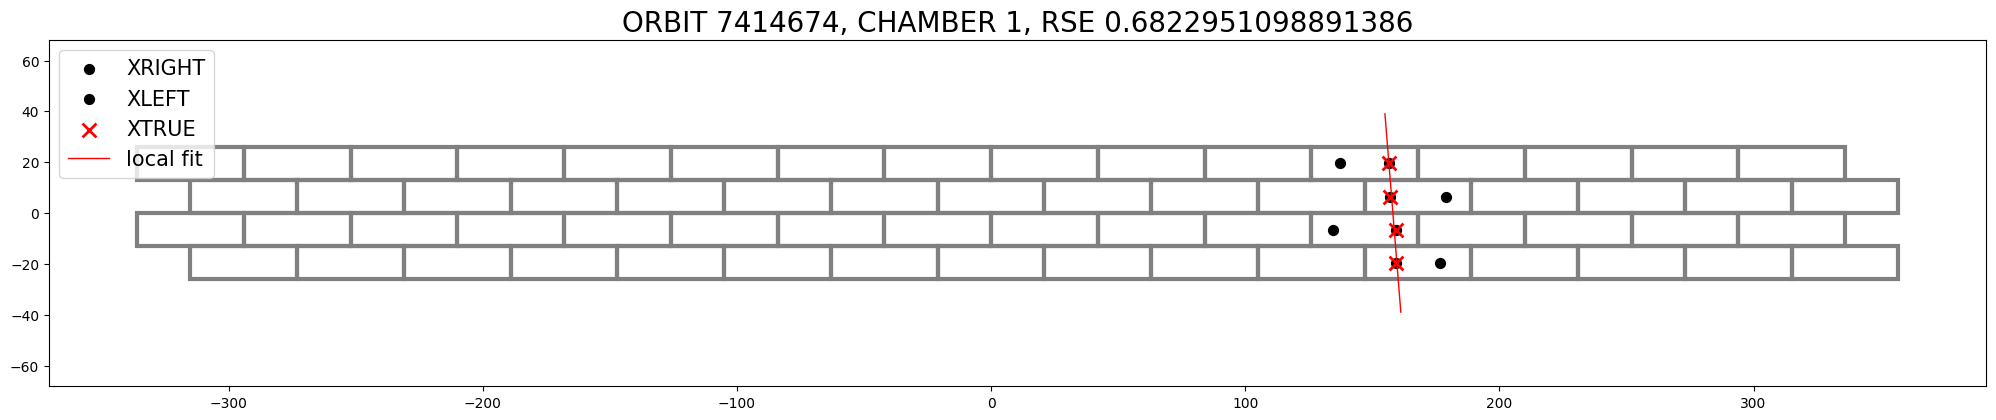

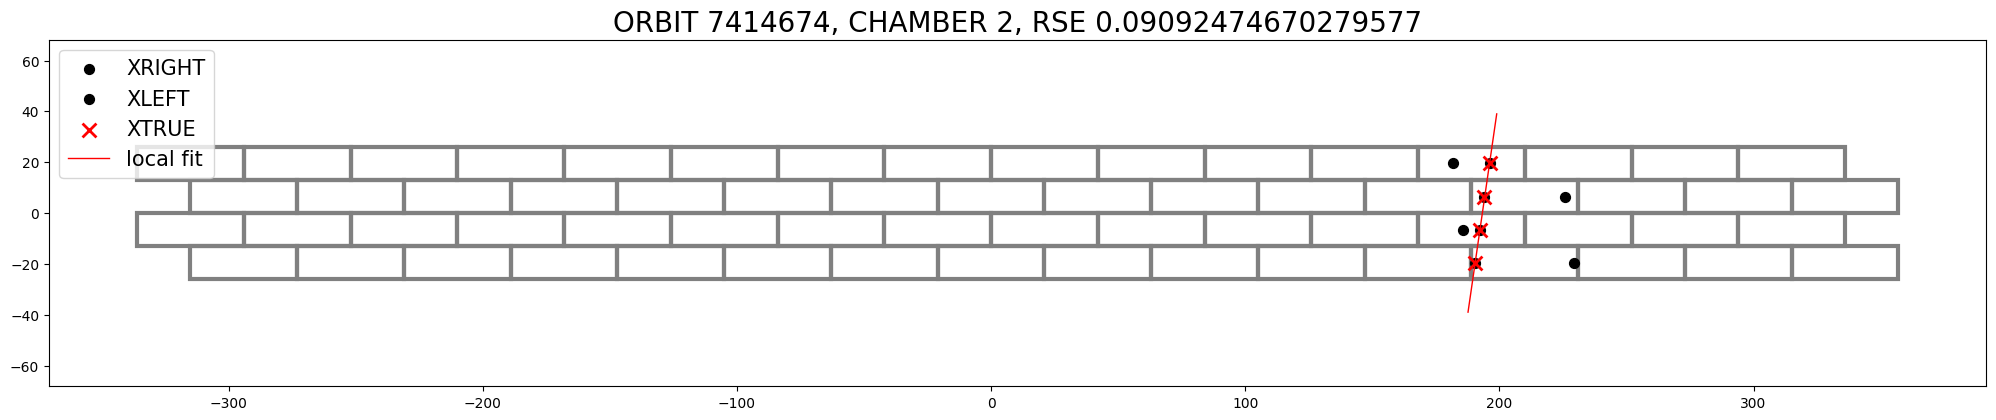

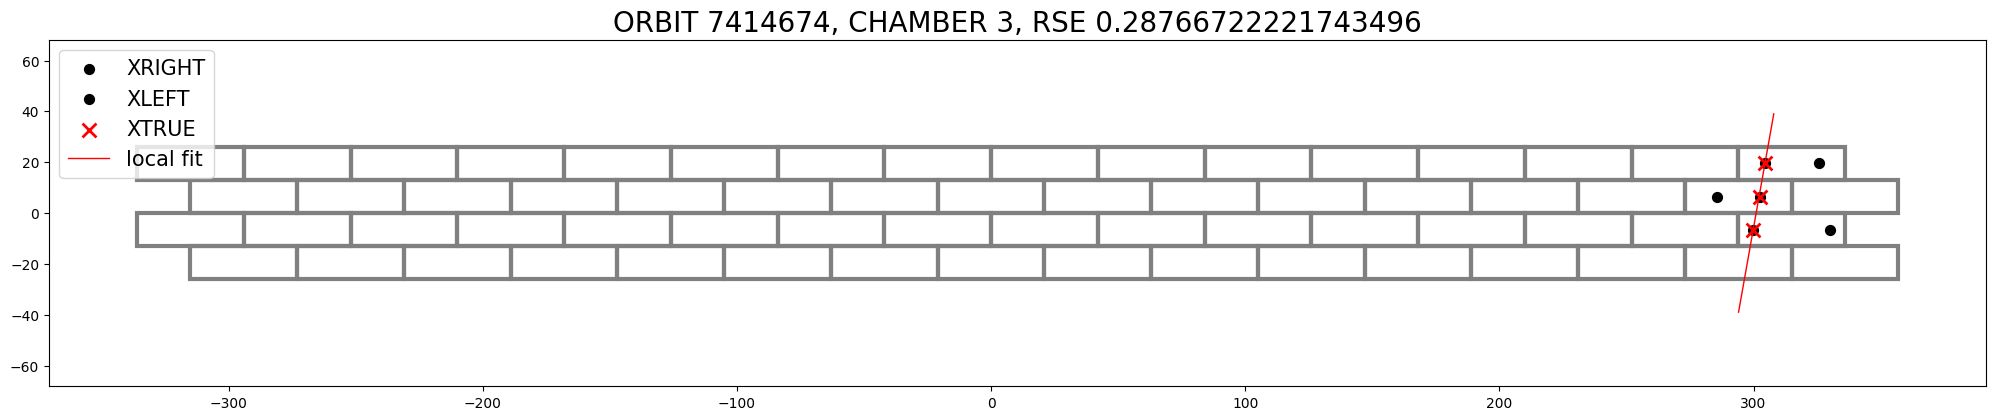

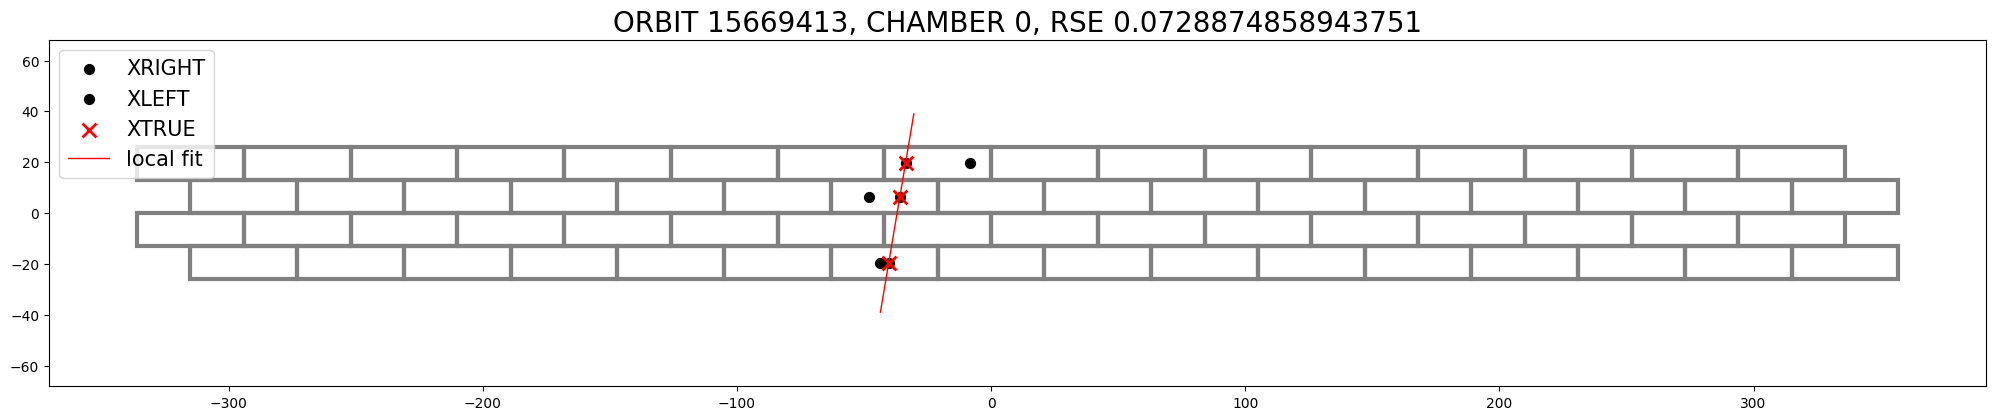

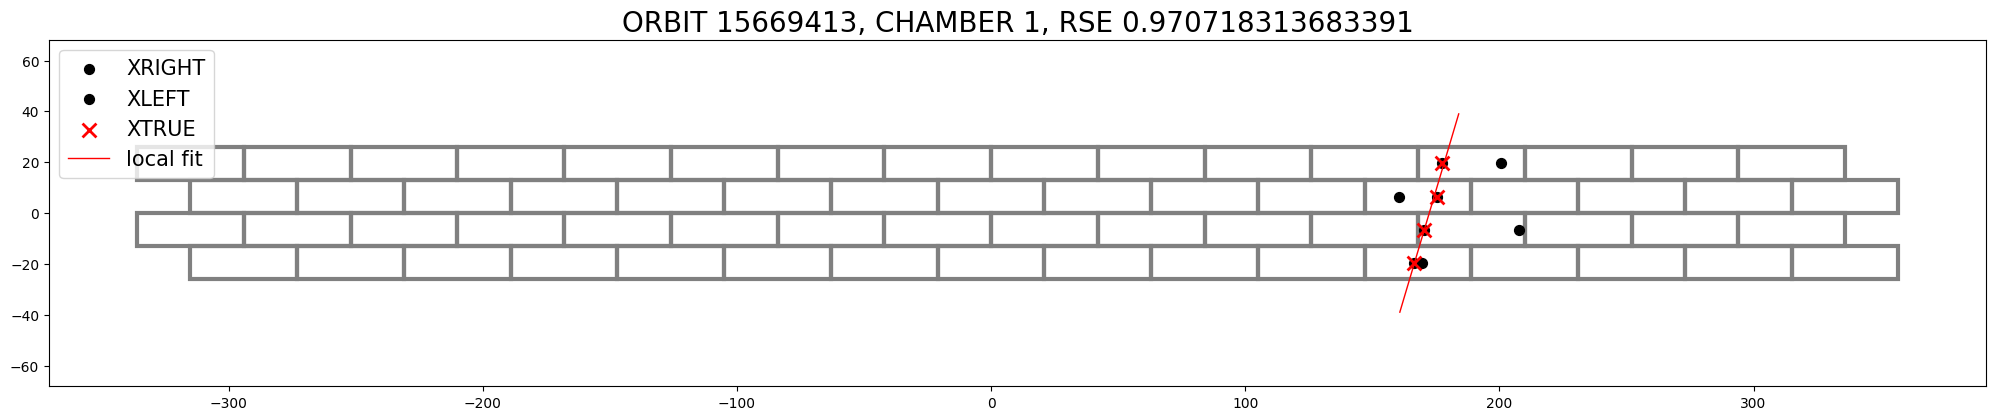

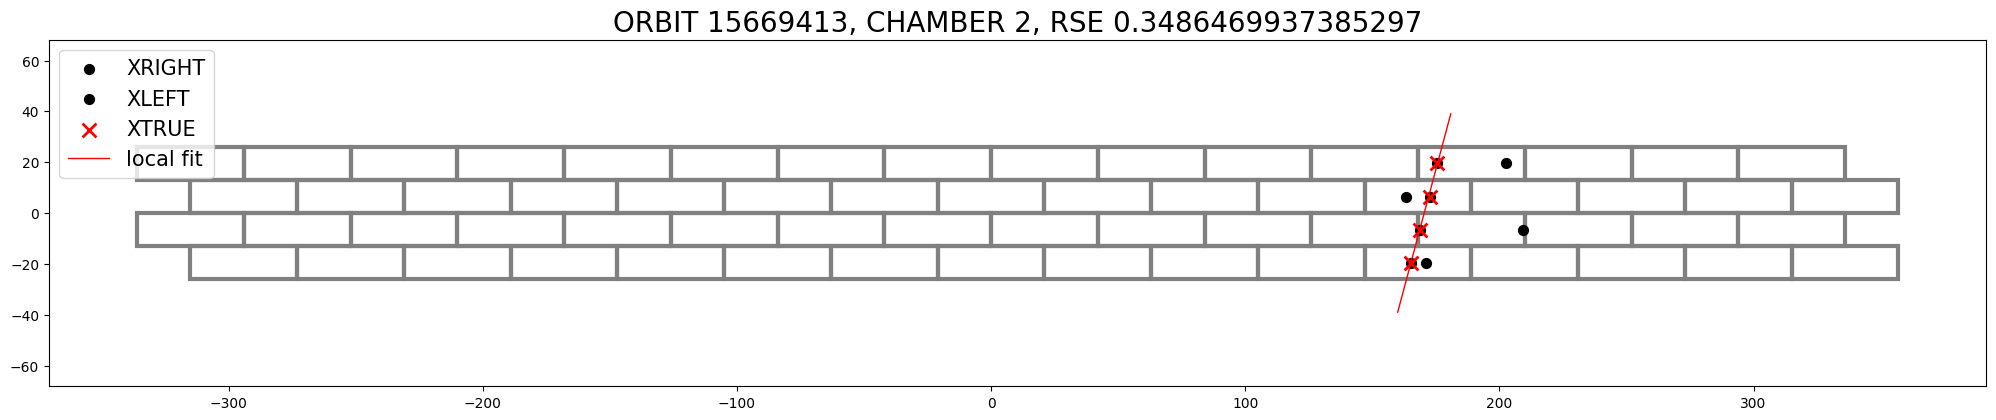

In [45]:
# print some plots as an example

unique_orbits = df6.select('ORBIT').distinct()

for orbit in unique_orbits.take(5):
    
    tmp = df6[df6.ORBIT == orbit['ORBIT']].toPandas() # select all rows from 1 orbit of the dataset
    
    for chamber in np.sort(tmp.CHAMBER.unique()): # need 'unique' since multiple rows have the same chamber
        
        plot_loc(tmp[tmp.CHAMBER == chamber]) # plot the points (rows) from 1 chamber at a time

Qualitatively, we can observe that the fit are often extremely good, with muon trajectories tipically very well defined. \
However, notice that it is not rare that a layer is skipped. Usually, this happens when the trajectory overlaps or passes very close to the edge of a cell, in which conditions the muon has probably not produced any ionisation.

Sometimes, however, it occurs that the activated cells of a chamber are not adjacent. Sometimes this effect is very pronounced and is probably due to noise.

<Axes: title={'center': 'ORBIT 135158079, CHAMBER 3, RSE 245.52057136209106'}>

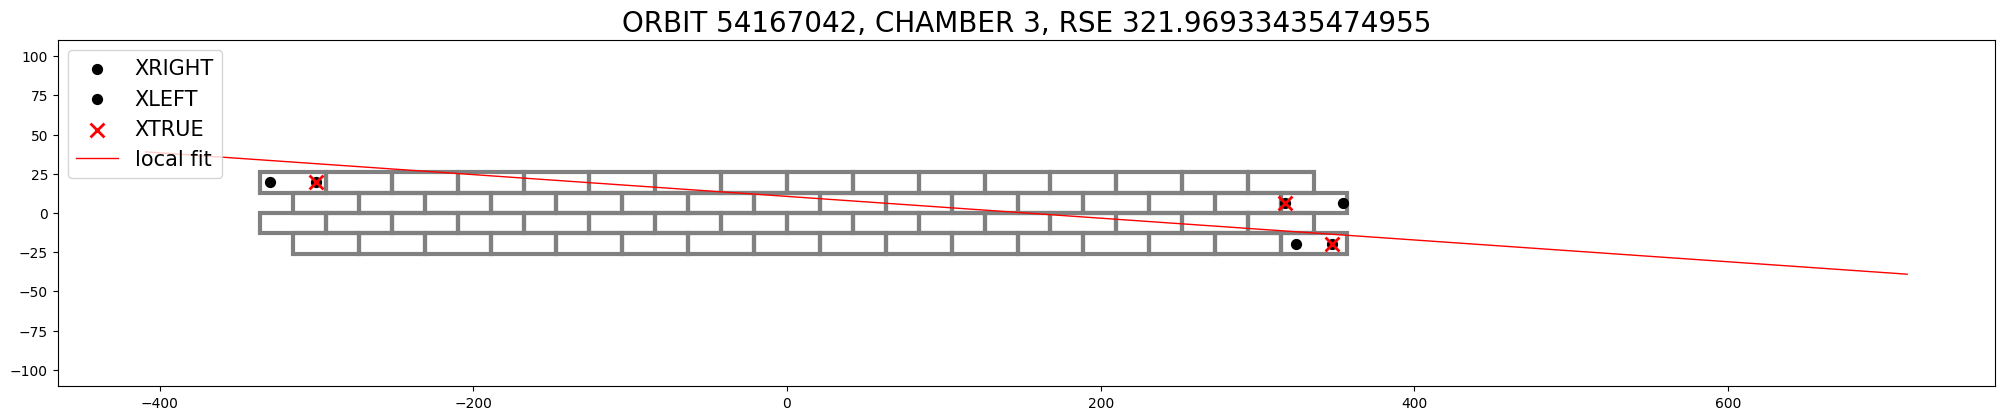

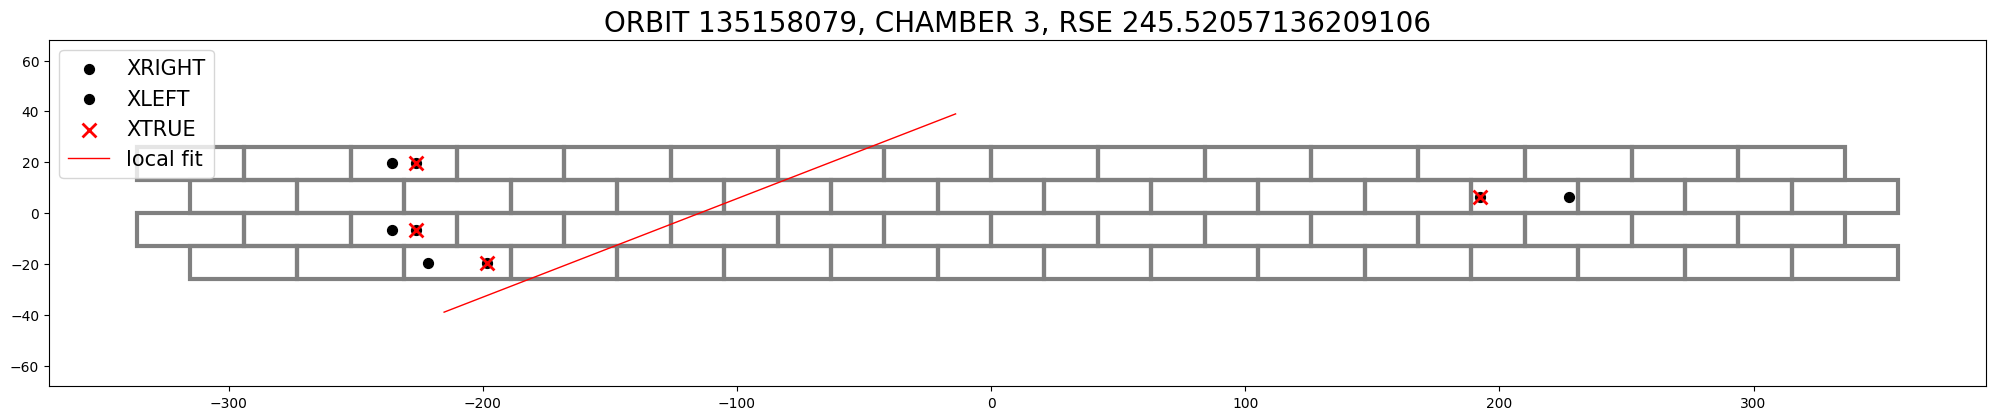

In [46]:
plot_loc(df6[(df6.ORBIT == 54167042) & (df6.CHAMBER == 3)].toPandas())
plot_loc(df6[(df6.ORBIT == 135158079) & (df6.CHAMBER == 3)].toPandas())

In other cases they could be associated with very inclined trajectories of secondary muons that cannot have activated the scintillator.

<Axes: title={'center': 'ORBIT 391750556, CHAMBER 0, RSE 211.37777570327734'}>

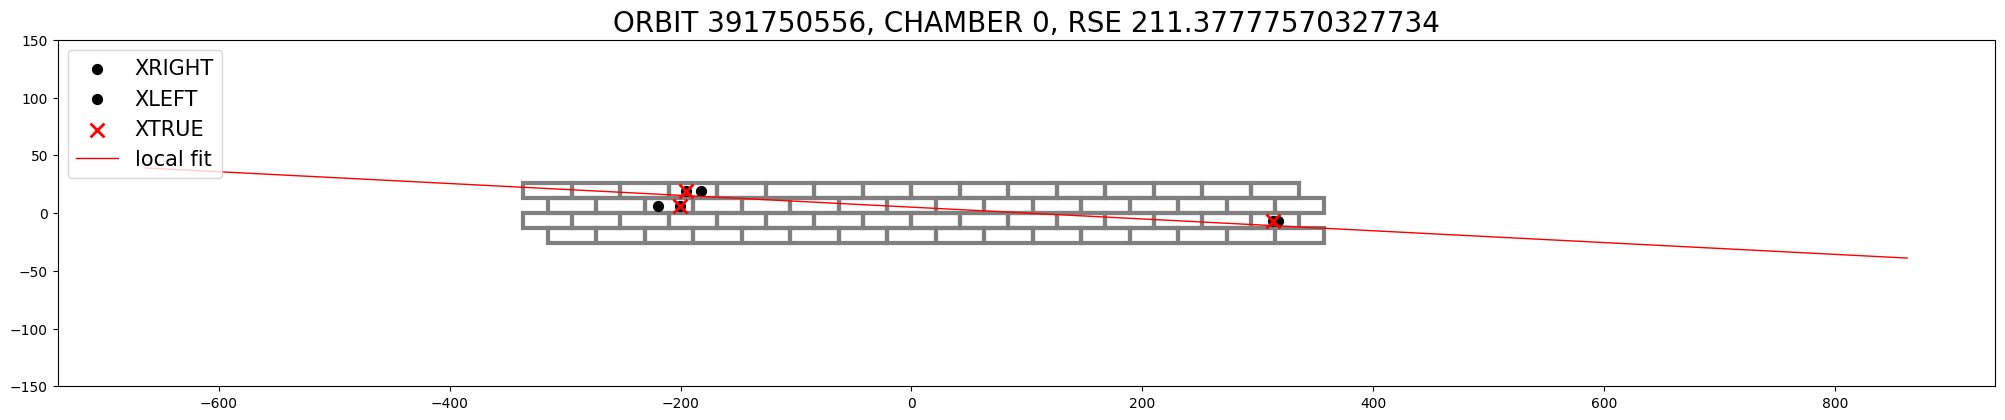

In [47]:
plot_loc(df6[(df6.ORBIT == 391750556) & (df6.CHAMBER == 0)].toPandas())

In any case, trajectories where the activated cells are not adjacent are difficult to frame, i. e. it is difficult to determine whether they are associated to inclined muons or to noise.

Qualitatively, if we analyse the local RSE, we can see that $16$ seems to be the "threshold" above which the cells in contiguous layers are not adjacent anymore:


<Axes: title={'center': 'ORBIT 39758545, CHAMBER 1, RSE 16.131565697296455'}>

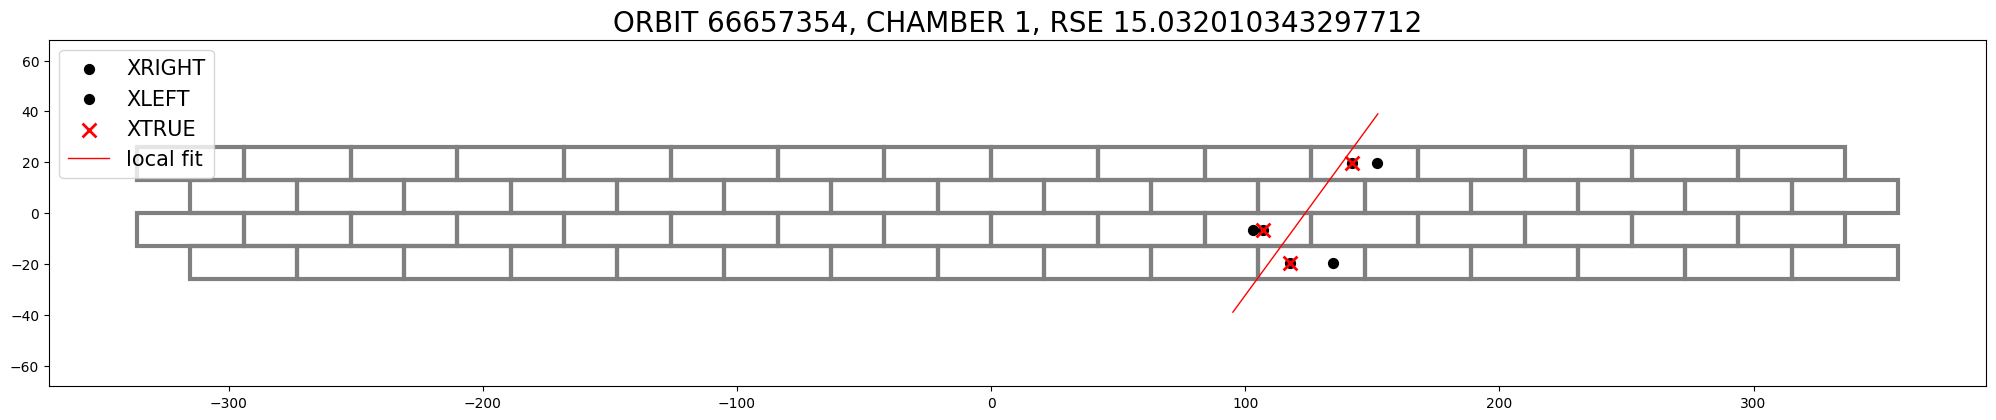

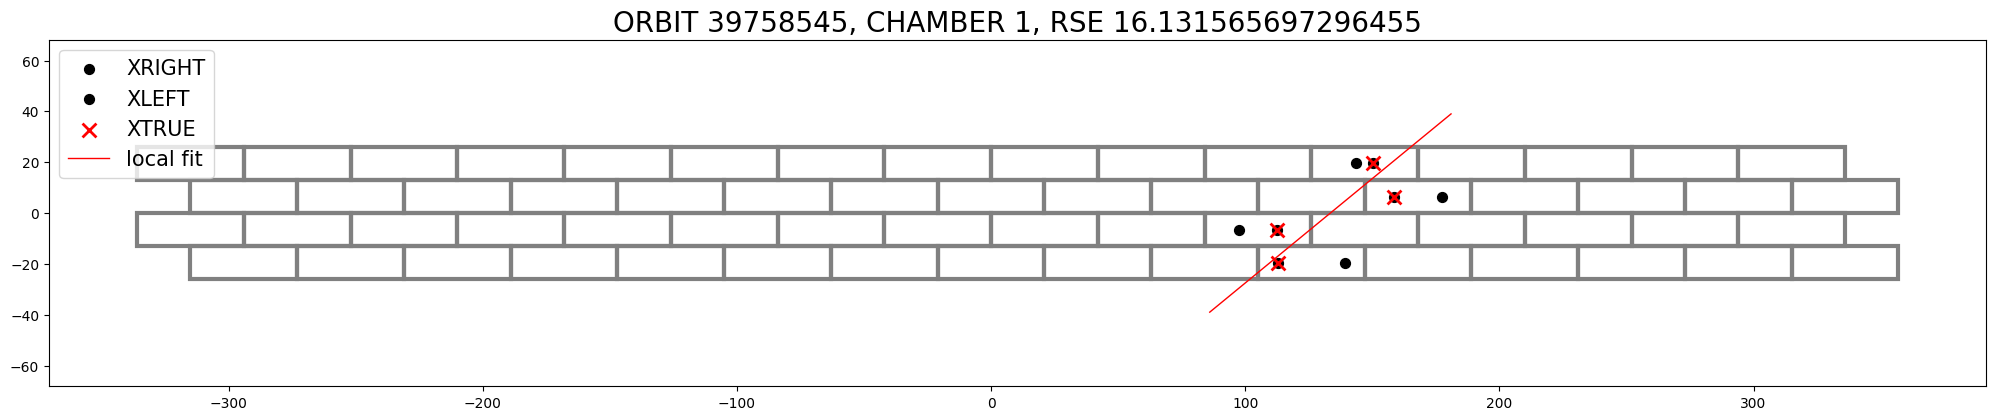

In [48]:
plot_loc(df6[(df6.ORBIT == 66657354) & (df6.CHAMBER == 1)].toPandas())
plot_loc(df6[(df6.ORBIT == 39758545) & (df6.CHAMBER == 1)].toPandas())

For this reason, we decide to eliminate the chambers for which the RSE is higher than the threshold.

In [49]:
RSE_threshold = 16
df6 = df6.filter(df6['RSE'] <= RSE_threshold)

df6.count() # to mute during performance analysis

373727

We can see here that around $20,000$ invalid events have been dropped.

### 6) Global fit and plot
For the "global fit" case, we fit each orbit considering its whole passage within the chambers 0, 2 and 3, that have the same orientation and can therefore be used for the reconstruction of the track.\
In particular, we use the points of the best fits previously identified within each channel to perform a single fit.

In [50]:
df6 = df6[df6.CHAMBER != 1] # discard hits in chamber 1

We then pass to perform the global fit. To be able to compute it, we need to select only the orbits where at least 2 chambers have been crossed by a muon.

In [51]:
df7 = df6.withColumn("m_g", col("CHAMBER")*0.0)\
           .withColumn("q_g", col("CHAMBER")*0.0)\
           .withColumn("RSE_g", col("CHAMBER")*0.0)  

In [52]:
def fit_glob(group):
    if (group['CHAMBER'].nunique() > 1):
        x = np.asarray(group.XTRUE.values)
        y = np.asarray(group.Z)
        n = group.shape[0]
        

        A = np.vstack((y, np.ones_like(y))).T # A is the matrix with z values as first column

        coeffs, residuals, _, _ = np.linalg.lstsq(A, x, rcond=None)# return an array 2*n with the (a,b) coefficients 
                                                      # for all possible interpolations 
                                                      # (lstsq works column by column)
                                                      # and compute residuals for all combinations
        ssr = residuals[0]

        m = 1 / coeffs[0]
        q = - coeffs[1] / coeffs[0]
        
        RSE_g = np.sqrt(ssr/(n - 2))
        group['m_g'] = np.repeat(m, group.shape[0])
        group['q_g'] = np.repeat(q, group.shape[0])
        group['RSE_g'] = np.repeat(RSE_g, group.shape[0])
        
        return group
    
    else:
        return pd.DataFrame({
            'ORBIT': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'XLEFT': [None],
            'XRIGHT': [None],
            'Z': [None],
            'XTRUE': [None],
            'm': [None],
            'q': [None],
            'RSE': [None],
            'm_g': [None],
            'q_g': [None],
            'RSE_g': [None]
        })
    

In [53]:
new_schema = "ORBIT int, CHAMBER int, LAYER int, \
            XLEFT double, XRIGHT double, Z double, XTRUE double, m double, q double, RSE double,\
            m_g double, q_g double, RSE_g double"

df8 = df7.groupBy("ORBIT").applyInPandas(fit_glob, new_schema)

In [54]:
df8 = df8.dropna()

df8 = df8.persist()
print(df8.count())

df6.unpersist()

196454


DataFrame[ORBIT: int, CHAMBER: int, LAYER: int, XLEFT: double, XRIGHT: double, Z: double, XTRUE: double, m: double, q: double, RSE: double]

In [55]:
def plot_glob(event):
    
    fig, ax = plt.subplots(figsize = (10, 16)) 
    
    ax.set_xlim(-9*w, 9*w)
    ax.set_ylim(z_shift[0] - 50, z_shift[-1] + 100) # plot limits
    
    x_rect = np.arange(-8*w, 8*w, w)
    z_rect = np.arange(-2*h, 2*h, h) # as before
    
    for ch in range(4):
        if ch != 1:
            for i in range(4):
                #if (i!=1):
                    if i % 2 == 0:
                        x = x_rect + w/2
                    else:
                        x = x_rect
                    for j in range(16):
                        ax.add_patch(Rectangle((x[j], z_rect[i] + z_shift[ch]), w, h, lw = 2, edgecolor = 'gray', facecolor = 'none'))


    ax.scatter(event.XRIGHT, event.Z, s = 20, c = "black") 
    ax.scatter(event.XLEFT, event.Z, s = 20, c = "black") 
    ax.scatter(event.XTRUE, event.Z, marker='x', s = 40, c = "red") 

    qg = event.q_g.iloc[0]
    mg = event.m_g.iloc[0]
    
    zmin = z_shift[0] - 3*h
    zmax = z_shift[-1] + 3*h

    ax.plot([(zmin - qg)/mg, (zmax-qg)/mg], [zmin, zmax], 'red', label = 'global fit') 

    # local fit
    markers = ['b--', 'o--', 'y--', 'm--']
    for ch in event.CHAMBER.unique() :
        loc_event = event[event.CHAMBER == ch]
        m = loc_event.m.iloc[0]
        q = loc_event.q.iloc[0]
        ax.plot([(zmin - q)/m, (zmax-q)/m], [zmin, zmax], markers[ch], label = f'local fit ch. {ch}')


    ax.set_title(f'ORBIT {event.ORBIT.iloc[0]}, RSE {event.RSE_g.iloc[0]}', fontsize = 25)
    ax.legend(loc = (0.02, 0.1), fontsize = 15)
    ax.text(x = -8*w, y = z_shift[3] + 2.5*h, s = "CHAMBER 3", fontsize = 15)
    ax.text(x = -8*w, y = z_shift[2] + 2.5*h, s = "CHAMBER 2", fontsize = 15)
    ax.text(x = -8*w, y = z_shift[0] + 2.5*h, s = "CHAMBER 0", fontsize = 15)
    return ax

We give a look to a few fits to get an idea of the goodness of our dataset cleansing until now:

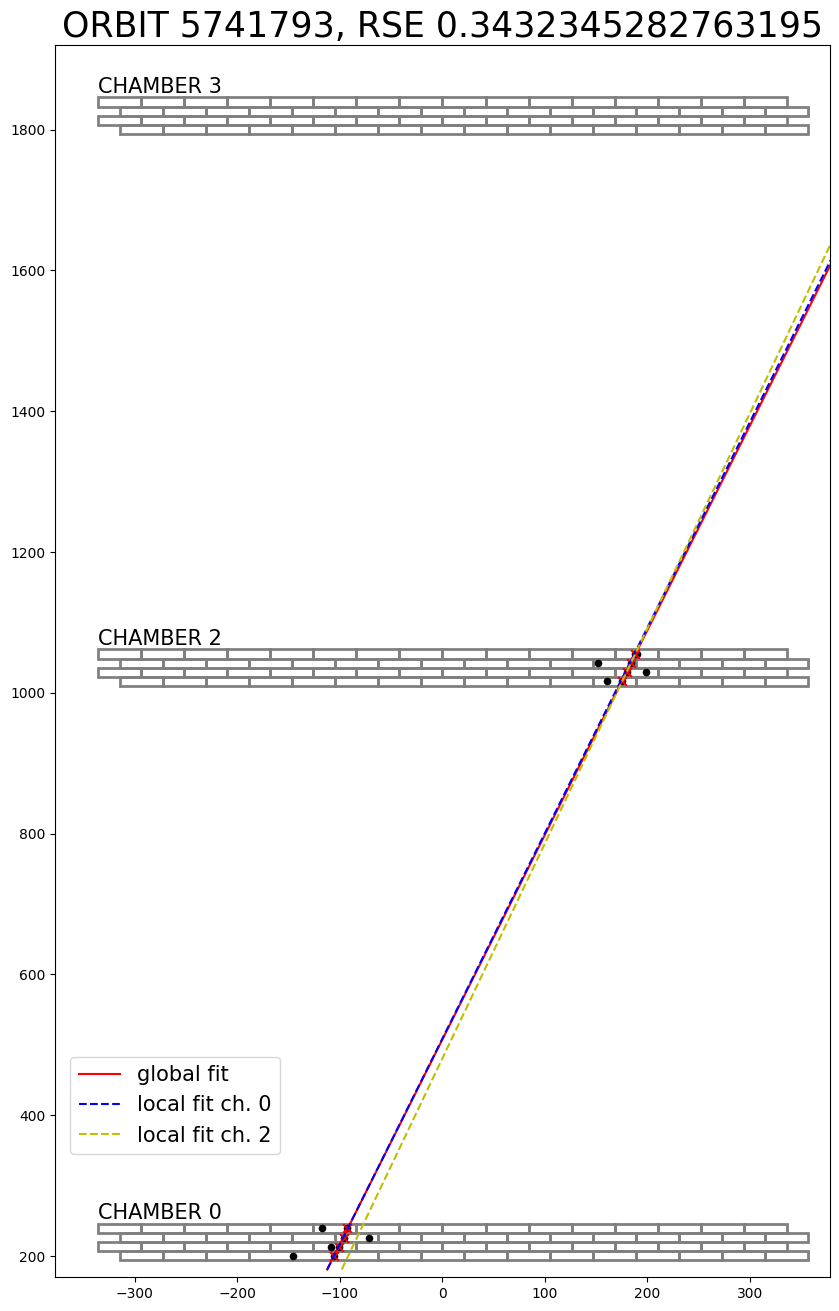

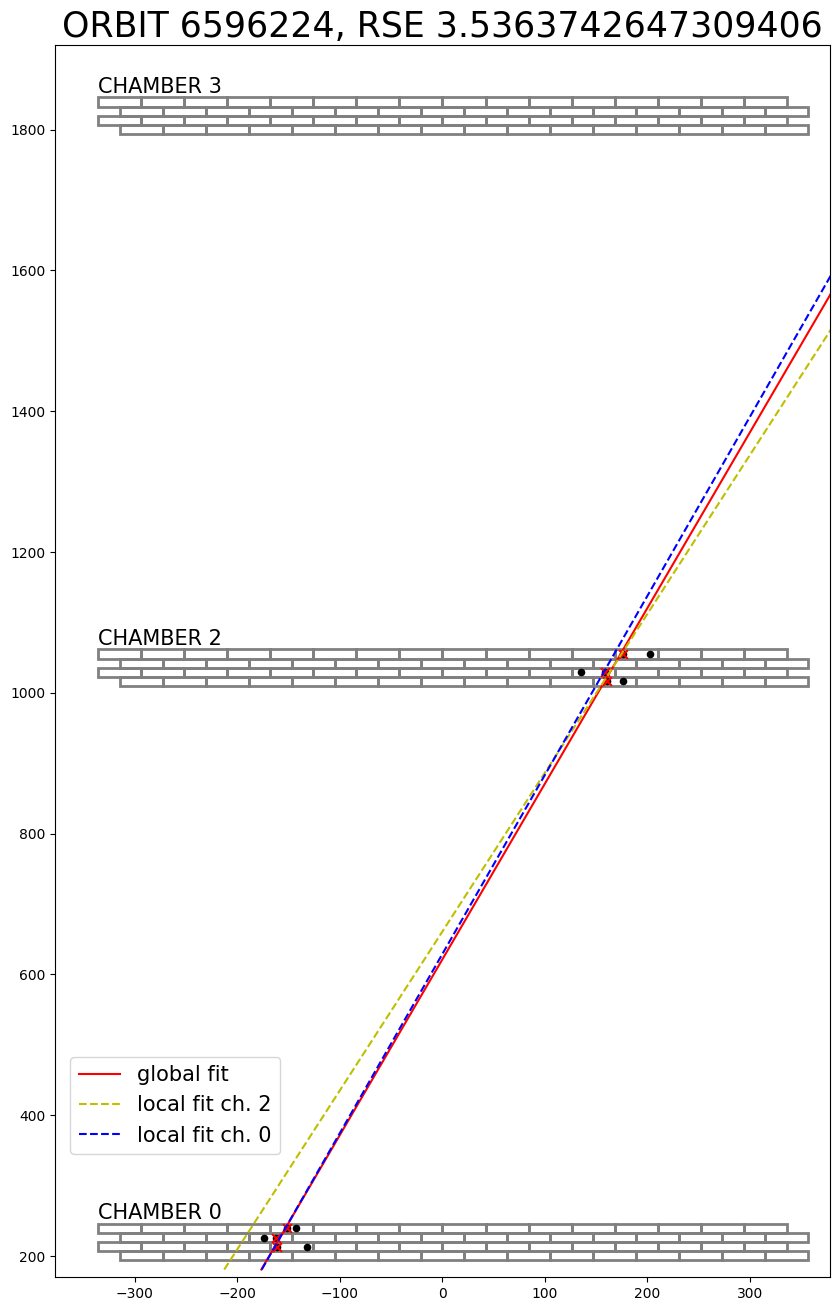

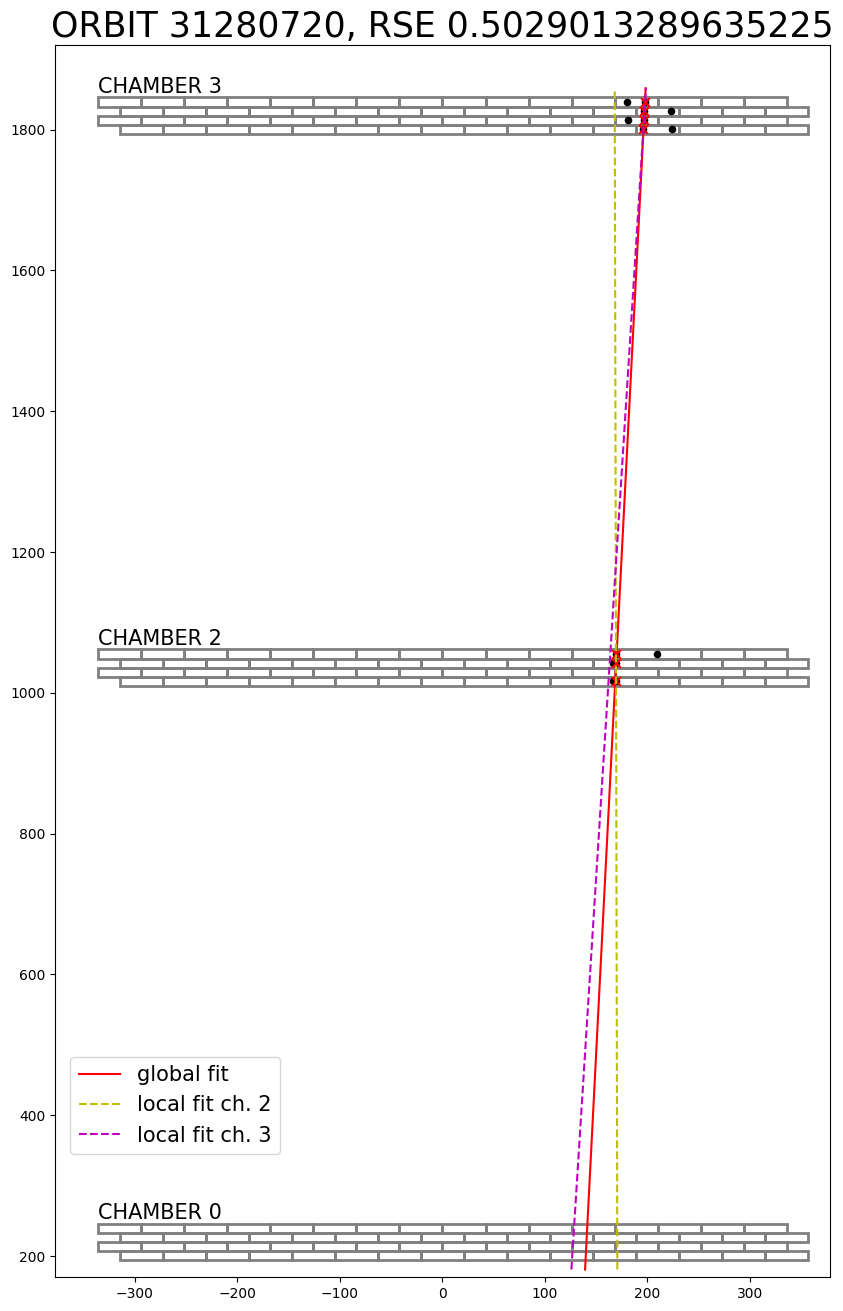

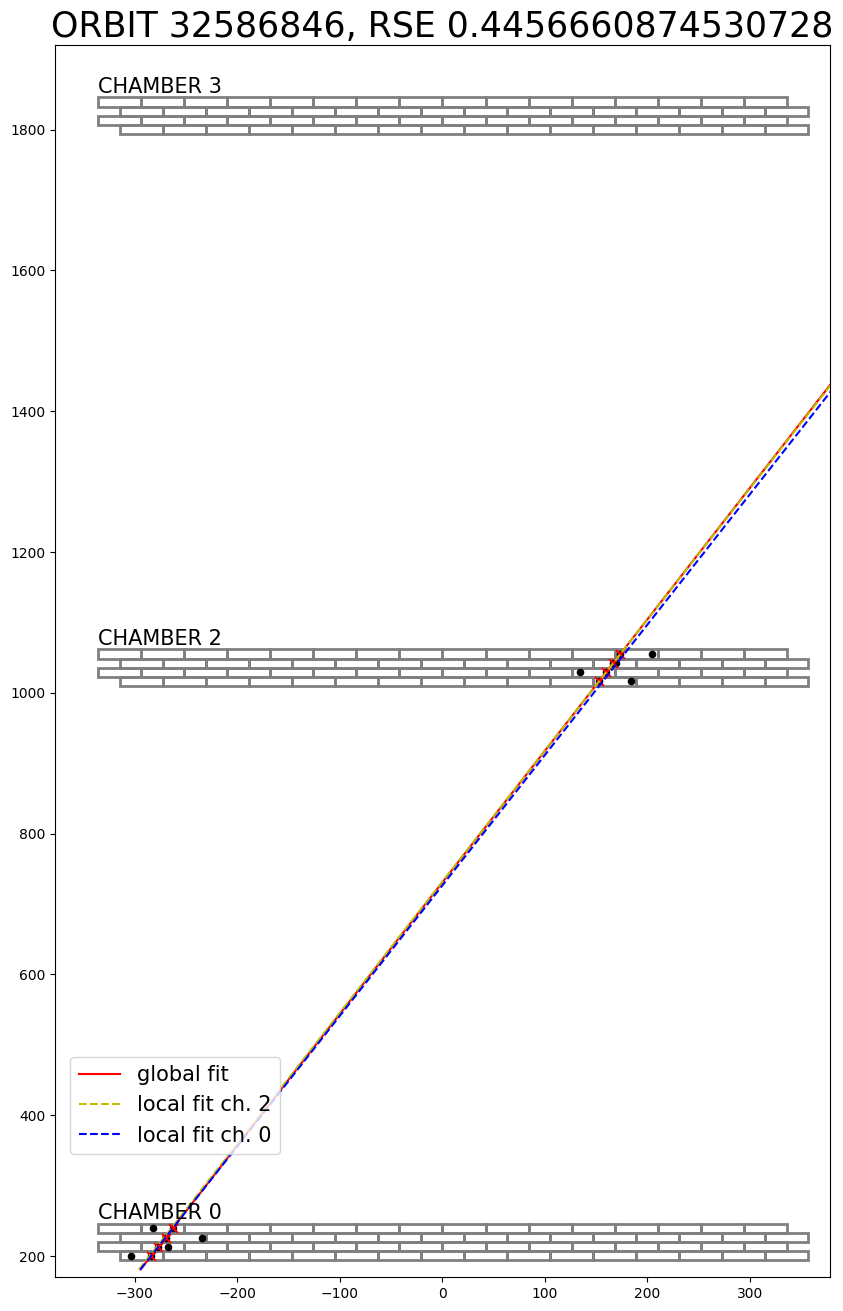

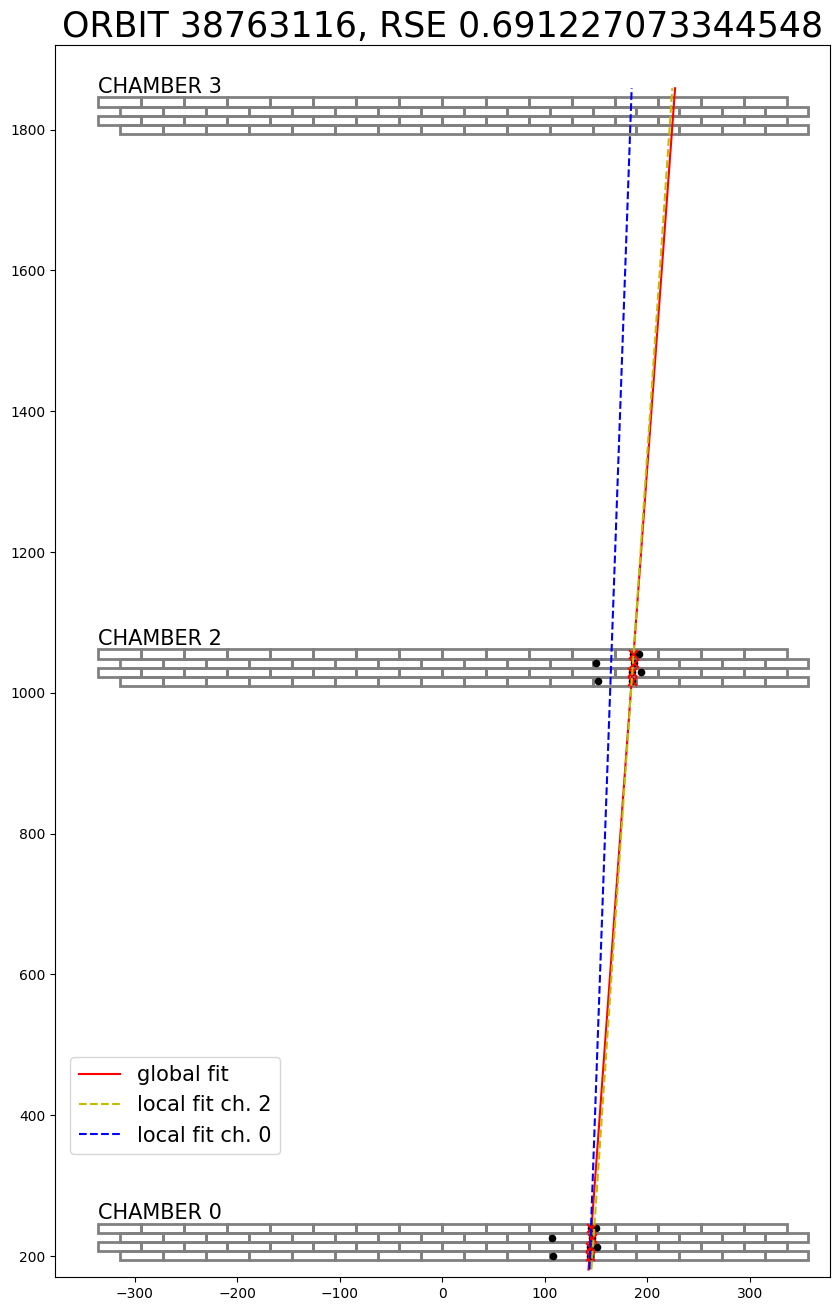

In [56]:
# print some plots as an example

unique_orbits = df8.select('ORBIT', 'RSE_g').distinct()

for orbit in unique_orbits.take(5):
    
    plot_glob(df8[df8.ORBIT == orbit['ORBIT']].toPandas())

### 7) Considerations on the global fit

Even with the threshold on the local fit that eliminates the hits where with high probability more than one muon passed through the chambers without triggering the scintillator, RSE is pretty high for some events. <br>
Plotting some of them, it's clear that:
1. Some events are inherently problematic and they generate from different possible causes. It is beyond the purpose of our project to implement a different algorithm for each one of them, so we chose to impose a $RSE_{threshold}$ for the global fit and eliminate the ones with higher RSE.
2. Other events, on the other hand, have a very satisfying global fit and can be considered correct. They will be kept as they are, excluding them from further manipulations, when they are below a $RSE_{lower}$ threshold.
3. For the remaining events, above the $RSE_{lower}$, we implement a different local fit for the chamber in the event that causes the highest change in RSE. This could really improve the global fit of otherwise incorrect events. <br>

<Axes: title={'center': 'ORBIT 103819792, RSE 112.05049147170013'}>

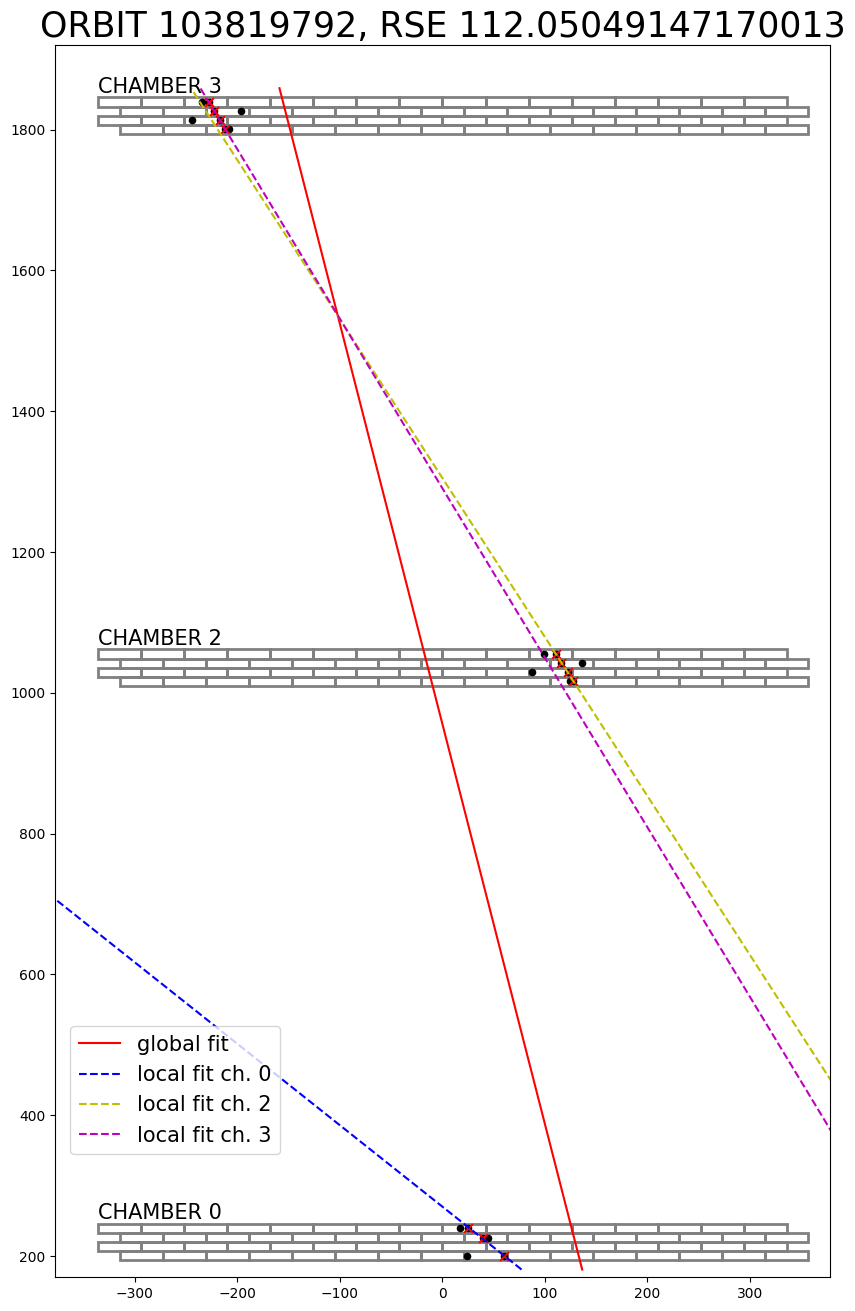

In [57]:
# Point 1
plot_glob(df8[df8.ORBIT == 103819792].toPandas())

<Axes: title={'center': 'ORBIT 171970228, RSE 0.03994409191260597'}>

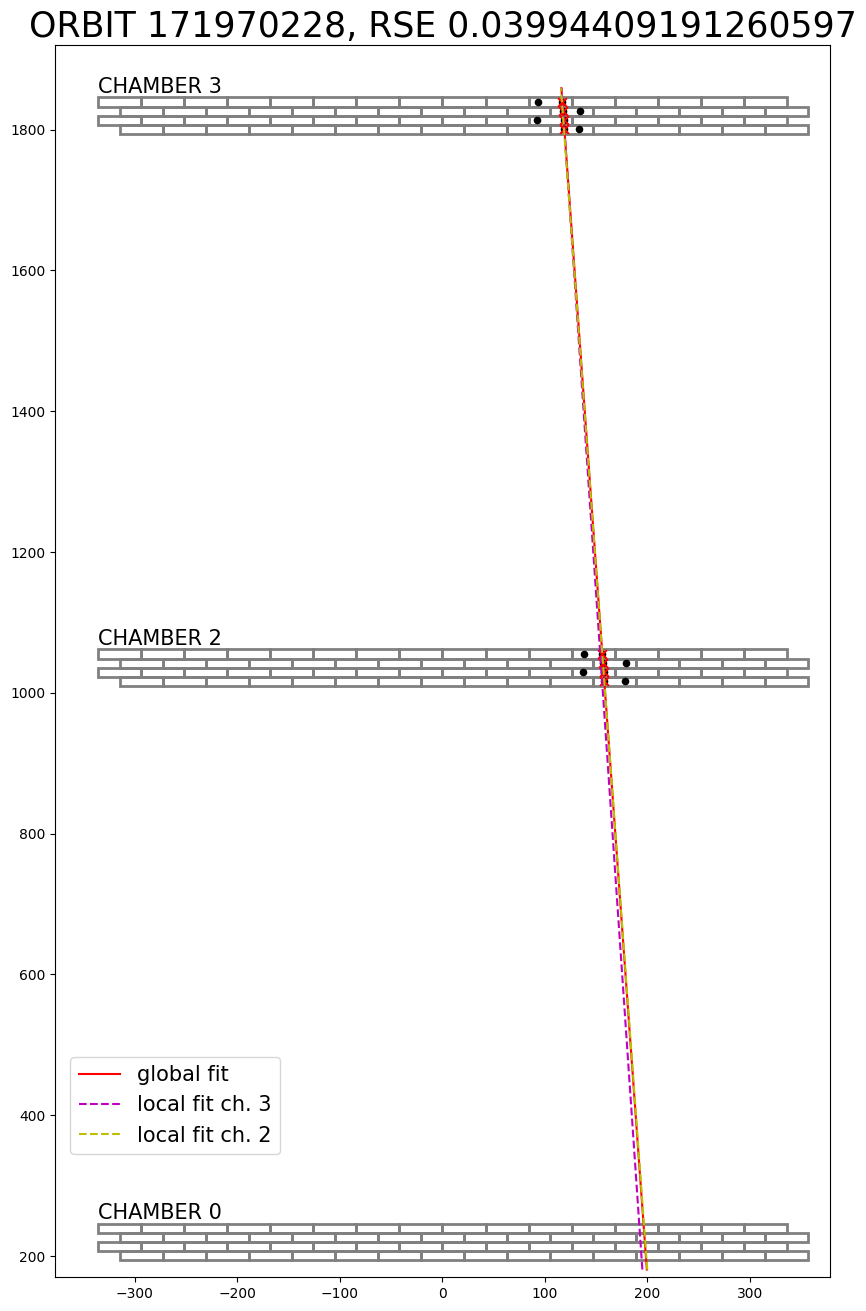

In [58]:
# Point 2 
plot_glob(df8[df8.ORBIT == 171970228].toPandas())

<Axes: title={'center': 'ORBIT 186693204, RSE 9.99992988952485'}>

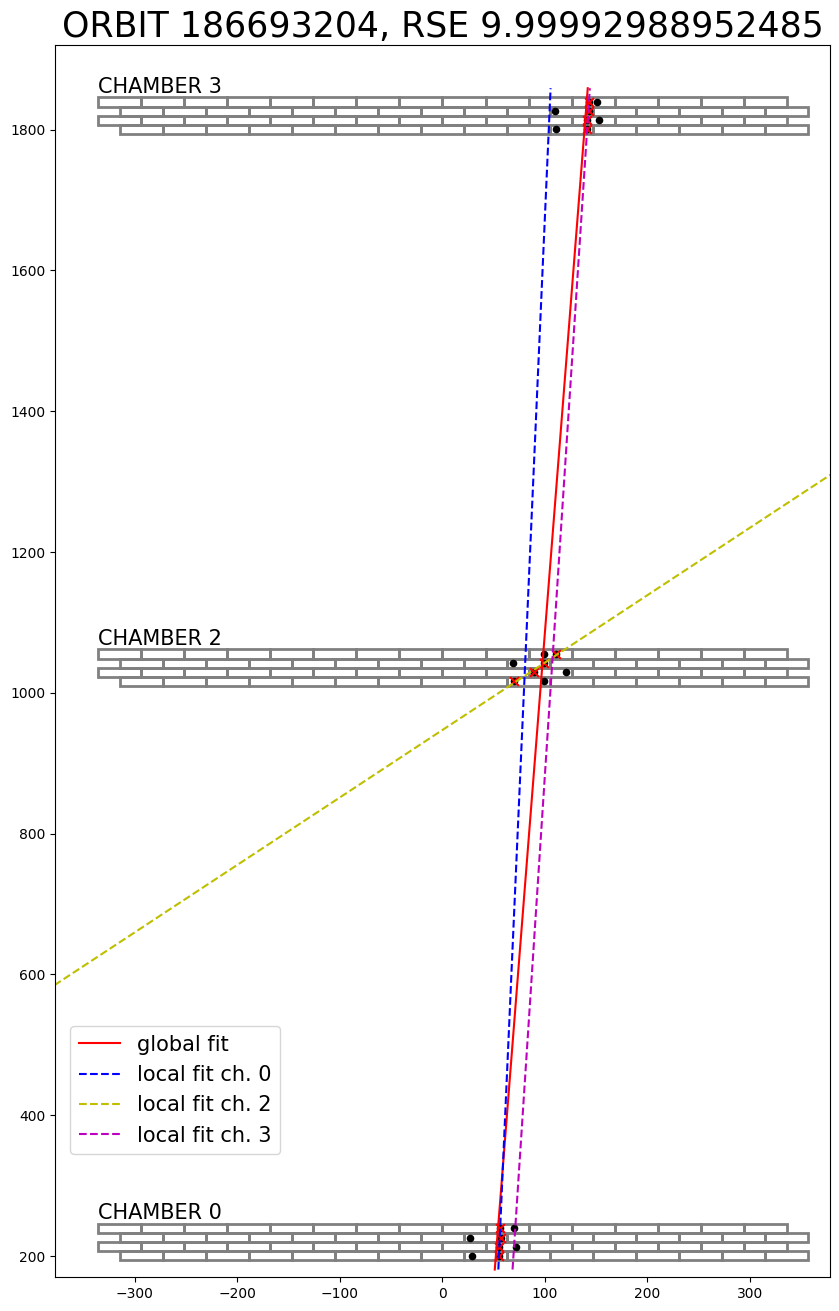

In [59]:
# Point 3
plot_glob(df8[df8.ORBIT == 186693204].toPandas())

### Point 1
The distribution of the orbits as a function of the global RSE is shown below:

In [60]:
"""
# make histogram with the distribution of the global RSE

range_min = 0
range_max = 200
bin_width = 1

new_bins, new_counts = df8.select('RSE_g').rdd\
                            .histogram(list(np.arange(range_min,range_max,bin_width)))    

#print(new_bins, new_counts)

fig, ax = plt.subplots(figsize = (7, 6)) 

#bin_centers = new_bins - np.array([0.5])

#hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue', edgecolor='black')
hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue')

#ax.set_ylim(1,5e7)
#ax.set_xlim(0,32)
ax.set_xlabel('RSE', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Distribution of Global RSE", fontsize=20)

ax.set_yscale('log')

plt.savefig('RSE_global.png')
"""

'\n# make histogram with the distribution of the global RSE\n\nrange_min = 0\nrange_max = 200\nbin_width = 1\n\nnew_bins, new_counts = df8.select(\'RSE_g\').rdd                            .histogram(list(np.arange(range_min,range_max,bin_width)))    \n\n#print(new_bins, new_counts)\n\nfig, ax = plt.subplots(figsize = (7, 6)) \n\n#bin_centers = new_bins - np.array([0.5])\n\n#hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align=\'mid\', color=\'lightblue\', edgecolor=\'black\')\nhits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align=\'mid\', color=\'lightblue\')\n\n#ax.set_ylim(1,5e7)\n#ax.set_xlim(0,32)\nax.set_xlabel(\'RSE\', fontsize=15)\nax.set_ylabel(\'Counts\', fontsize=15)\nax.set_title("Distribution of Global RSE", fontsize=20)\n\nax.set_yscale(\'log\')\n\nplt.savefig(\'RSE_global.png\')\n'

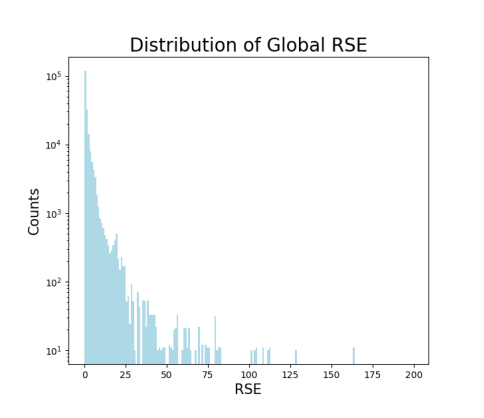

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the first image
img1 = mpimg.imread('RSE_global.png')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Plot image
axes.imshow(img1)
axes.axis('off')

# Show the images
plt.show()

We observe that around a value of $RSE\_g=80$ there is a gap with no events until $RSE\_g=100$. Qualitatively, we can see that above this gap ($RSE\_g >100$) the events are with no doubt noisy or caused by the passage of multiple muons and therefore there is no possibility to improve the fit. Under the $RSE\_g=80$ threshold we have events for which it is possible to obtain a better fit by operating another kind of global fit.

In [62]:
# Point 1
RSE_g_threshold = 80
df8 = df8.filter(df8['RSE_g'] <= RSE_g_threshold)

df8.count() # mute during performance analysis

196338

With this new filter, even if the threshold is arbitrarily chosen, the number of lost events is just $116$, the  $0.06\%$ of the events

### Point 2
Qualitatively, looking at the events where $RSE\_g$ is lower than $0.5$, we can see that these events correspond to an almost perfect fit. The implementation of Point 3 on these events will only cause an increase in computation time without a reasonable gain in the results.

In [63]:
# Point 2
RSE_g_threshold_lower = 0.5
df8.filter(df8['RSE_g'] < RSE_g_threshold_lower).count() # mute during performance analysis

57047

Thanks to this operation, we avoid to apply the improving of the global fit on the 29% of the dataframe, lightening the computation of  about 1/3.

### Point 3
Now, for the third step of the filtering of the global fits. <br>
The algorithm steps:
1. Select the global fit events where the $RSE>0.5$
2. Eliminate from the global fit one chamber at a time and re-evaluate the global RSE
3. Individuate which chamber is most responsible for the high value of RSE, re-evaluate the local fit of that chamber in two ways:
    1. Trying all the possible local fits
    2. Accepting the first n best local fits
4. Calculate the global fit for all the new local fits performed 
5. If one of the worse local fit decreases the RSE, keep that local fit.

In [64]:
# Point 3 case A
def filt(group):
    if group['CHAMBER'].nunique() > 1:
        chambers = group['CHAMBER'].unique()
        RSE_real = group['RSE_g'].unique()
        results = []
        
        # These are values of the global fit that do not depend on the local fit 
        y = np.asarray(group.Z)
        n = group.shape[0]
        A = np.vstack((y, np.ones_like(y))).T # A is the matrix with z values as first column
        
        # First step: 
        # 1) Filter data for the specific chamber
        # 2) Compute diff to see which chamber brings the maximum change in RSE
        
        for chamber in chambers:
            chamber_group = group[group['CHAMBER'] != chamber]

            x_chamber = np.asarray(chamber_group['XTRUE'].values)
            y_chamber = np.asarray(chamber_group['Z'])
            n_chamber = chamber_group.shape[0]

            A_chamber = np.vstack((y_chamber, np.ones_like(y_chamber))).T

            coeffs, residuals, _, _ = np.linalg.lstsq(A_chamber, x_chamber, rcond=None)
            ssr_chamber = residuals[0]
            RSE_g = np.sqrt(ssr_chamber / (n_chamber - 2))

            diff = RSE_real - RSE_g  # Calculate the difference from the real RSE_g

            results.append((chamber, diff))
            
        # Find the chamber with the highest difference -> 
        # this will be the chamber for which the local fit will be re-evaluated
        max_diff_chamber = max(results, key=lambda x: x[1])[0]
        
        chamber_max = group[group['CHAMBER'] == max_diff_chamber]
        
        if (chamber_max['LAYER'].nunique() > 2) and (chamber_max['LAYER'].nunique() == chamber_max.shape[0]):
        
            xl_val = np.asarray(chamber_max.XLEFT.values)
            xr_val = np.asarray(chamber_max.XRIGHT.values)
            y_chamber_max = np.asarray(chamber_max.Z)
            n_chamber_max = chamber_max.shape[0]
        
            if n_chamber_max != 3 and n_chamber_max != 4: 
                print("group does not have the correct dimension!")
        
            else:
        
                stack = np.column_stack((xl_val, xr_val)) # stack the columns with xleft and xright coord aside

                x_chamber_max = np.array(np.meshgrid(*stack)).reshape(n_chamber_max,-1) # generate all combinations of xleft/xright
                                                                     # as a n*2^n array

                A_chamber_max = np.vstack((y_chamber_max, np.ones_like(y_chamber_max))).T 

                coeffs, residuals, _, _ = np.linalg.lstsq(A_chamber_max, x_chamber_max, rcond=None)# return an array 2*n with the (a,b) coefficients 
                                                              # for all possible interpolations 
                                                              # (lstsq works column by column)
                                                              # and compute residuals for all combinations
                        
                # Save the residuals, given that local RSE is smaller than 16 (as previously chosen)
            
                final_i = np.argsort(residuals)  # Sort the indexes of residuals from smaller to higher
                ssr = residuals[final_i]         # Store the residuals in the same order as final_i

                RSE = np.sqrt(ssr / (n_chamber_max - 2))     # Compute RSE values

                # Filter out cases where RSE is greater than 16
                filtered_indexes = np.where(RSE <= 16)[0]
                filtered_final_i = final_i[filtered_indexes]
                RSE = RSE[filtered_indexes]

                m_values = []
                q_values = []
                x_values = x_chamber_max.T[filtered_final_i]
                
                for i in filtered_final_i:
                    m = 1 / coeffs[0][i]
                    q = -coeffs[1][i] / coeffs[0][i]
                    m_values.append(m)
                    q_values.append(q)
                
                # Compute the global fit for all the cases we kept, now we use the group dataframe again 
                
                RSE_g_values = []
                m_g_values = []
                q_g_values = []
                
                
                for i in filtered_final_i:
                    temp = group['XTRUE'].copy()
                    temp[group['CHAMBER'] == max_diff_chamber] = x_chamber_max.T[i]

                    x = np.asarray(temp.values)
                    coeffs, residuals, _, _ = np.linalg.lstsq(A, x, rcond=None)
                    ssr = residuals[0]
                    m = 1 / coeffs[0]
                    q = -coeffs[1] / coeffs[0]
                    RSE_g = np.sqrt(ssr / (n - 2))
                    RSE_g_values.append(RSE_g)
                    m_g_values.append(m)
                    q_g_values.append(q)

                # Find the best RSE_g value
                best_RSE_g = min(RSE_g_values)
                best_i = np.where(RSE_g_values == best_RSE_g)[0][0]
                
                # Save the values in the dataframe
                group.loc[group['CHAMBER'] == max_diff_chamber, 'm'] = np.repeat(m_values[best_i], n_chamber_max)
                group.loc[group['CHAMBER'] == max_diff_chamber, 'q'] = np.repeat(q_values[best_i], n_chamber_max)
                group.loc[group['CHAMBER'] == max_diff_chamber, 'XTRUE'] = x_values[best_i]
                group['m_g'] = np.repeat(m_g_values[best_i], group.shape[0])
                group['q_g'] = np.repeat(q_g_values[best_i], group.shape[0])
                group['RSE_g'] = np.repeat(RSE_g_values[best_i], group.shape[0])
            return group
        else:
            return pd.DataFrame({
            'ORBIT': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'XLEFT': [None],
            'XRIGHT': [None],
            'Z': [None],
            'XTRUE': [None],
            'm': [None],
            'q': [None],
            'RSE': [None],
            'm_g': [None],
            'q_g': [None],
            'RSE_g': [None],
        })


    else:
        return pd.DataFrame({
            'ORBIT': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'XLEFT': [None],
            'XRIGHT': [None],
            'Z': [None],
            'XTRUE': [None],
            'm': [None],
            'q': [None],
            'RSE': [None],
            'm_g': [None],
            'q_g': [None],
            'RSE_g': [None],
        })


In [65]:
def filt_n(group):
    if group['CHAMBER'].nunique() > 1:
        chambers = group['CHAMBER'].unique()
        RSE_real = group['RSE_g'].unique()
        results = []
        
        # These are values of the global fit that do not depend on the local fit 
        y = np.asarray(group.Z)
        n = group.shape[0]
        A = np.vstack((y, np.ones_like(y))).T # A is the matrix with z values as first column
        
        # First step: 
        # 1) Filter data for the specific chamber
        # 2) Compute diff to see which chamber brings the maximum change in RSE
        
        for chamber in chambers:
            chamber_group = group[group['CHAMBER'] != chamber]

            x_chamber = np.asarray(chamber_group['XTRUE'].values)
            y_chamber = np.asarray(chamber_group['Z'])
            n_chamber = chamber_group.shape[0]

            A_chamber = np.vstack((y_chamber, np.ones_like(y_chamber))).T

            coeffs, residuals, _, _ = np.linalg.lstsq(A_chamber, x_chamber, rcond=None)
            ssr_chamber = residuals[0]
            RSE_g = np.sqrt(ssr_chamber / (n_chamber - 2))

            diff = RSE_real - RSE_g # Calculate the difference from the real RSE_g

            results.append((chamber, diff))
            
        # Find the chamber with the highest difference -> 
        # this will be the chamber for which the local fit will be re-evaluated
        max_diff_chamber = max(results, key=lambda x: x[1])[0]
        
        chamber_max = group[group['CHAMBER'] == max_diff_chamber]
        
        if (chamber_max['LAYER'].nunique() > 2) and (chamber_max['LAYER'].nunique() == chamber_max.shape[0]):
        
            xl_val = np.asarray(chamber_max.XLEFT.values)
            xr_val = np.asarray(chamber_max.XRIGHT.values)
            y_chamber_max = np.asarray(chamber_max.Z)
            n_chamber_max = chamber_max.shape[0]
        
            if n_chamber_max != 3 and n_chamber_max != 4: 
                print("group does not have the correct dimension!")
        
            else:
        
                stack = np.column_stack((xl_val, xr_val)) # stack the columns with xleft and xright coord aside

                x_chamber_max = np.array(np.meshgrid(*stack)).reshape(n_chamber_max,-1) # generate all combinations of xleft/xright
                                                                     # as a n*2^n array

                A_chamber_max = np.vstack((y_chamber_max, np.ones_like(y_chamber_max))).T # A is the matrix with z values as first column

                coeffs, residuals, _, _ = np.linalg.lstsq(A_chamber_max, x_chamber_max, rcond=None)# return an array 2*n with the (a,b) coefficients 
                                                              # for all possible interpolations 
                                                              # (lstsq works column by column)
                                                              # and compute residuals for all combinations
                        
                # Save the residuals, given that local RSE is smaller than 16 (as previously chosen)
            
                final_i = np.argsort(residuals)  # Sort the indexes of residuals from smaller to higher
                ssr = residuals[final_i]         # Store the residuals in the same order as final_i

                RSE = np.sqrt(ssr / (n_chamber_max - 2))     # Compute RSE values
                
                # Keep only n values in the RSE vector
                limit = 5
                RSE = RSE[:limit]
                
                # Filter out cases where RSE is greater than 16
                filtered_indexes = np.where(RSE <= 16)[0]
                filtered_final_i = final_i[filtered_indexes]
                RSE = RSE[filtered_indexes]

                m_values = []
                q_values = []
                x_values = x_chamber_max.T[filtered_final_i]
                
                for i in filtered_final_i:
                    m = 1 / coeffs[0][i]
                    q = -coeffs[1][i] / coeffs[0][i]
                    m_values.append(m)
                    q_values.append(q)
                
                # Compute the global fit for all the cases we kept, now we use the group dataframe again 
                
                RSE_g_values = []
                m_g_values = []
                q_g_values = []
                
                
                for i in filtered_final_i:
                    temp = group['XTRUE'].copy()
                    temp[group['CHAMBER'] == max_diff_chamber] = x_chamber_max.T[i]

                    x = np.asarray(temp.values)
                    coeffs, residuals, _, _ = np.linalg.lstsq(A, x, rcond=None)
                    ssr = residuals[0]
                    m = 1 / coeffs[0]
                    q = -coeffs[1] / coeffs[0]
                    RSE_g = np.sqrt(ssr / (n - 2))
                    RSE_g_values.append(RSE_g)
                    m_g_values.append(m)
                    q_g_values.append(q)

                # Find the best RSE_g value
                best_RSE_g = min(RSE_g_values)
                best_i = np.where(RSE_g_values == best_RSE_g)[0][0]
                
                # Save the values in the dataframe
                group.loc[group['CHAMBER'] == max_diff_chamber, 'm'] = np.repeat(m_values[best_i], n_chamber_max)
                group.loc[group['CHAMBER'] == max_diff_chamber, 'q'] = np.repeat(q_values[best_i], n_chamber_max)
                group.loc[group['CHAMBER'] == max_diff_chamber, 'XTRUE'] = x_values[best_i]
                group['m_g'] = np.repeat(m_g_values[best_i], group.shape[0])
                group['q_g'] = np.repeat(q_g_values[best_i], group.shape[0])
                group['RSE_g'] = np.repeat(RSE_g_values[best_i], group.shape[0])
            return group
        else:
            return pd.DataFrame({
            'ORBIT': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'XLEFT': [None],
            'XRIGHT': [None],
            'Z': [None],
            'XTRUE': [None],
            'm': [None],
            'q': [None],
            'RSE': [None],
            'm_g': [None],
            'q_g': [None],
            'RSE_g': [None],
        })


    else:
        return pd.DataFrame({
            'ORBIT': [None],
            'CHAMBER': [None],
            'LAYER': [None],
            'XLEFT': [None],
            'XRIGHT': [None],
            'Z': [None],
            'XTRUE': [None],
            'm': [None],
            'q': [None],
            'RSE': [None],
            'm_g': [None],
            'q_g': [None],
            'RSE_g': [None],
        })


In [66]:
part_start_time = time.time()
temp = df8.where(df8['RSE_g'] < RSE_g_threshold_lower).union(df8.where(df8['RSE_g'] >= RSE_g_threshold_lower).groupBy("ORBIT").applyInPandas(filt, new_schema))
print("Partial Time elapsed:", time.time() - part_start_time)

Partial Time elapsed: 0.23639869689941406


In [67]:
part_start_time = time.time()
final = df8.where(df8['RSE_g'] < RSE_g_threshold_lower).union(df8.where(df8['RSE_g'] >= RSE_g_threshold_lower).groupBy("ORBIT").applyInPandas(filt_n, new_schema))
print("Partial Time elapsed:", time.time() - part_start_time)

Partial Time elapsed: 0.24915337562561035


We can observe that the second method filt_n is about $15-20 \%$ faster than plain filt. However we want to inspect if this simplified option gives a much worse RSE_g than the other. 
For this, we give a look at the RSE distribution in the two final dataframes.

In [68]:
from pyspark.sql.functions import mean
mean_RSE = df8.agg(mean('RSE_g')).collect()[0][0]
mean_RSE_temp  = temp.agg(mean('RSE_g')).collect()[0][0]
mean_RSE_final = final.agg(mean('RSE_g')).collect()[0][0]
print("Mean RSE_g before filtering", mean_RSE)
print("Mean RSE_g after filt", mean_RSE_temp)
print("Mean RSE_g after filt_n", mean_RSE_final)

Mean RSE_g before filtering 2.0547185133676447
Mean RSE_g after filt 1.7844250598622498
Mean RSE_g after filt_n 1.786275805669035


In [69]:
"""
# make histogram with the distribution of the global RSE

range_min = 0
range_max = 80
bin_width = 1

new_bins, new_counts = temp.select('RSE_g').rdd\
                            .histogram(list(np.arange(range_min,range_max,bin_width)))    

#print(new_bins, new_counts)

fig, ax = plt.subplots(figsize = (7, 6)) 

#bin_centers = new_bins - np.array([0.5])

#hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue', edgecolor='black')
hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue')

#ax.set_ylim(1,5e7)
#ax.set_xlim(0,32)
ax.set_xlabel('RSE', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("RSE_g distribution with 'filt'", fontsize=20)

ax.set_yscale('log')

plt.savefig('RSE_global_temp.png')

range_min = 0
range_max = 80
bin_width = 1

new_bins, new_counts = final.select('RSE_g').rdd\
                            .histogram(list(np.arange(range_min,range_max,bin_width)))    

#print(new_bins, new_counts)

fig, ax = plt.subplots(figsize = (7, 6)) 

#bin_centers = new_bins - np.array([0.5])

#hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue', edgecolor='black')
hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue')

#ax.set_ylim(1,5e7)
#ax.set_xlim(0,32)
ax.set_xlabel('RSE', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("RSE_g distribution with 'filt_n'", fontsize=20)

ax.set_yscale('log')

plt.savefig('RSE_global_final.png')
"""

'\n# make histogram with the distribution of the global RSE\n\nrange_min = 0\nrange_max = 80\nbin_width = 1\n\nnew_bins, new_counts = temp.select(\'RSE_g\').rdd                            .histogram(list(np.arange(range_min,range_max,bin_width)))    \n\n#print(new_bins, new_counts)\n\nfig, ax = plt.subplots(figsize = (7, 6)) \n\n#bin_centers = new_bins - np.array([0.5])\n\n#hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align=\'mid\', color=\'lightblue\', edgecolor=\'black\')\nhits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align=\'mid\', color=\'lightblue\')\n\n#ax.set_ylim(1,5e7)\n#ax.set_xlim(0,32)\nax.set_xlabel(\'RSE\', fontsize=15)\nax.set_ylabel(\'Counts\', fontsize=15)\nax.set_title("RSE_g distribution with \'filt\'", fontsize=20)\n\nax.set_yscale(\'log\')\n\nplt.savefig(\'RSE_global_temp.png\')\n\nrange_min = 0\nrange_max = 80\nbin_width = 1\n\nnew_bins, new_counts = final.select(\'RSE_g\').rdd                            .histogram(list(np.arange(ran

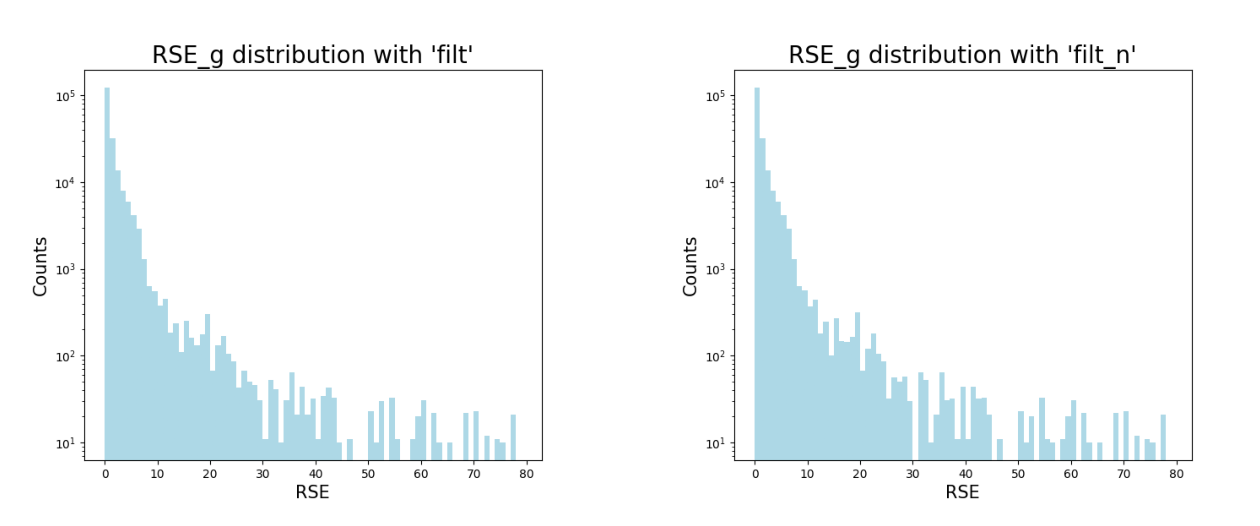

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the first image
img1 = mpimg.imread('RSE_global_temp.png')

# Load the second image
img2 = mpimg.imread('RSE_global_final.png')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first image in the first subplot
axes[0].imshow(img1)
axes[0].axis('off')

# Plot the second image in the second subplot
axes[1].imshow(img2)
axes[1].axis('off')

#fig.suptitle('Global RSE')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the images
plt.show()

We see that the distribution of RSE_g does not improve much; this can be seen both from the plots and from the average RSE_g, which is just slightly higher in the case of filt_n. For this we believe that filt is not better enough than filt_n to justify the additional computation time and we decide to keep the dataframe final, obtained with the filtering of filt_n. 

In [71]:
final = final.persist()
final.count()

df8.unpersist()

DataFrame[ORBIT: int, CHAMBER: int, LAYER: int, XLEFT: double, XRIGHT: double, Z: double, XTRUE: double, m: double, q: double, RSE: double, m_g: double, q_g: double, RSE_g: double]

In [72]:
# total time elapsed from the beginning of the document
print("Total Time elapsed:", time.time() - start_time)

Total Time elapsed: 700.0858929157257


Up to this point, the dataset has been cleaned trying to eliminate the hits and the orbits which are necessarily associated to noise or to secondary effects (orbits without scintillator activation, hits with unphysical drift time, orbits with less than 3 hits or more than 16 hits, orbits with activation of non-adjacent cells), too complicated to analyse (orbits with more than one scintillator activation or that can in no way be associated with the passage of a single muon) or for which a global fit is impossible to produce (orbits with only one chamber activated). However, a few non-trivial cases still remain:
- muon trajectories so inclined that only pass through 2 chambers
- muons that have activated only 2 chambers although - in principle - passing across all of them
- multiple muons detected at the same time can still occur, such that one obscures the other.

It is obvious that removing these cases would lead to more precise results in the description of the trajectory of a single muon.
For this reason, we first eliminate orbits where only two chambers out of three have been activated:


In [73]:
# keep only the orbits where all 3 chambers have been crossed
chamber_counts = final.select('ORBIT', 'CHAMBER').distinct().orderBy('ORBIT')\
                    .groupBy('ORBIT').agg(count('CHAMBER').alias('CHAMBER'))

chamber_counts = chamber_counts.where(col('CHAMBER') == 3)\
                         .drop('CHAMBER')

df9 = final.join(chamber_counts, on='ORBIT')

In [74]:
print(final.count(), df9.count())

196338 55599


We observe that the majority of orbits involves only two hits, while the orbits in which all three chambers have activated make up ~28% of the so far manipulated dataset. The distribution of the orbits as a function of the global RSE is shown below:

In [75]:
"""
range_min = 0
range_max = 80
bin_width = 1

new_bins, new_counts = df9.select('RSE_g').rdd\
                            .histogram(list(np.arange(range_min,range_max,bin_width)))    

#print(new_bins, new_counts)

fig, ax = plt.subplots(figsize = (7, 6)) 

#bin_centers = new_bins - np.array([0.5])

#hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue', edgecolor='black')
hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align='mid', color='lightblue')

#ax.set_ylim(1,5e7)
#ax.set_xlim(0,32)
ax.set_xlabel('RSE', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Orbits with 3 Chambers Activated", fontsize=20)

ax.set_yscale('log')

plt.savefig('RSE_global_only3ch.png')
"""

'\nrange_min = 0\nrange_max = 80\nbin_width = 1\n\nnew_bins, new_counts = df9.select(\'RSE_g\').rdd                            .histogram(list(np.arange(range_min,range_max,bin_width)))    \n\n#print(new_bins, new_counts)\n\nfig, ax = plt.subplots(figsize = (7, 6)) \n\n#bin_centers = new_bins - np.array([0.5])\n\n#hits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align=\'mid\', color=\'lightblue\', edgecolor=\'black\')\nhits = plt.hist(new_bins[:-1], new_bins, weights=new_counts, align=\'mid\', color=\'lightblue\')\n\n#ax.set_ylim(1,5e7)\n#ax.set_xlim(0,32)\nax.set_xlabel(\'RSE\', fontsize=15)\nax.set_ylabel(\'Counts\', fontsize=15)\nax.set_title("Orbits with 3 Chambers Activated", fontsize=20)\n\nax.set_yscale(\'log\')\n\nplt.savefig(\'RSE_global_only3ch.png\')\n'

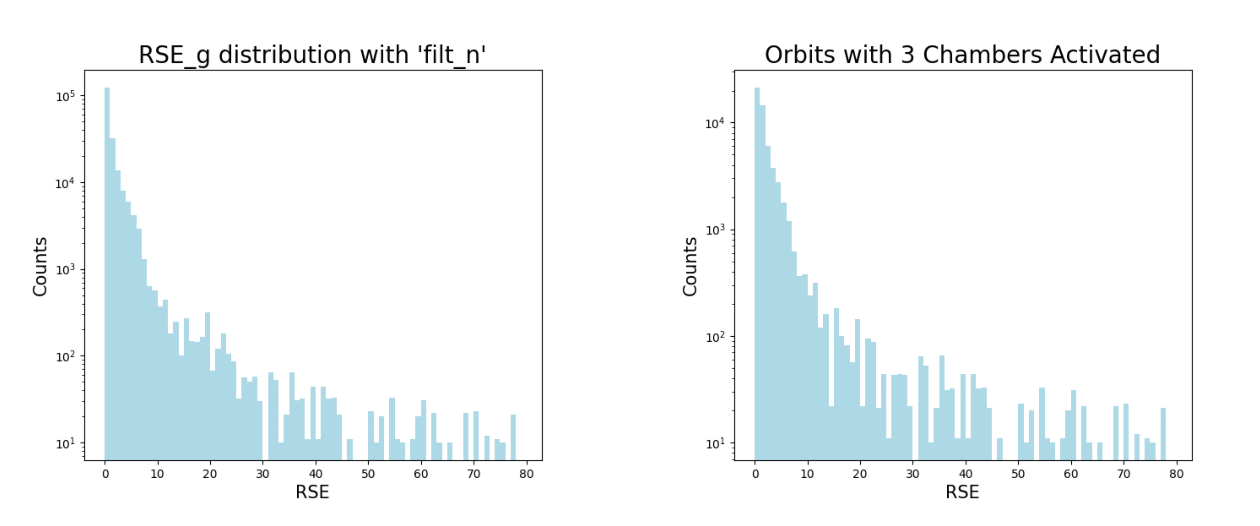

In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the first image
img1 = mpimg.imread('RSE_global_final.png')

# Load the second image
img2 = mpimg.imread('RSE_global_only3ch.png')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first image in the first subplot
axes[0].imshow(img1)
axes[0].axis('off')

# Plot the second image in the second subplot
axes[1].imshow(img2)
axes[1].axis('off')

#fig.suptitle('Global RSE')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the images
plt.show()

We can observe that the majority of orbits is concentrated in the range of lowest RSE. This phenomenon, however, is especially marked for the dataset with all the orbits (left plot), where the orbits with RSE < 1 alone make up more than half of the entire dataset. This is easily due to the fact that, involving a lower number of points, orbits with only 2 chambers activated are more likely to have a low global RSE.


After this operation, however, many cases that probably correspond to the passage of multiple muons are still present. To eliminate them, a method as simple as it is brutal can be to split the dataset into two parts based on the value of the RSE: after establishing a threshold below which we qualitatively observe that the trajectories can with no doubt be associated to the passage of a single muon, we consider the previous effects to be present only above this threshold. We can then move to compare the results obtained from the two datasets.

In [77]:
threshold = 5

final_above = final.where(col('RSE_g') >= threshold)
final_below = final.where(col('RSE_g') < threshold)
final_below.count()

182808

In [78]:
df9_above = df9.where(col('RSE_g') >= threshold)
df9_below = df9.where(col('RSE_g') < threshold)
df9_below.count()

48625

Here we give a look to a few trajectories with the highest RSE versus a few trajectories with RSE just below the threshold. While it is clear that for the former the detection is dubious, for the latter it is very likely, in all cases, that a single muon has been detected.

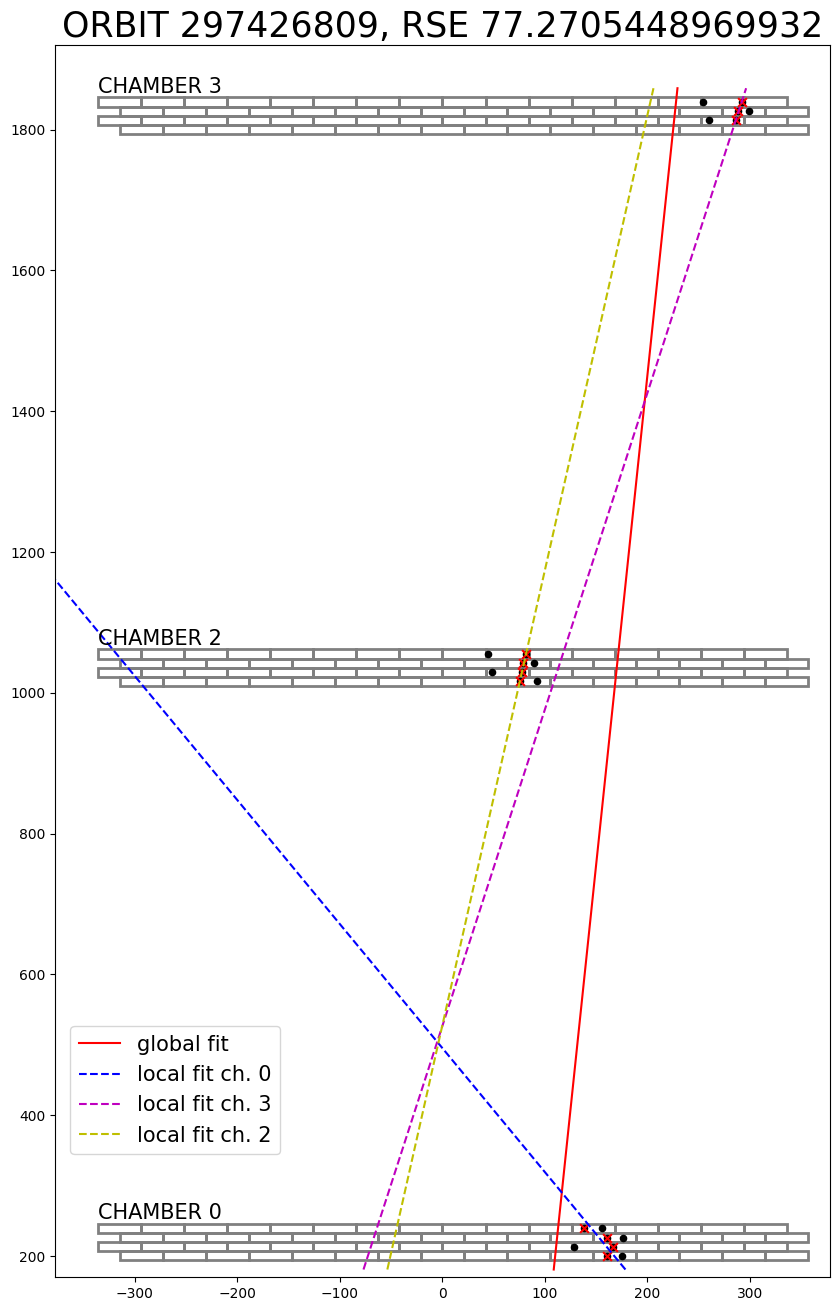

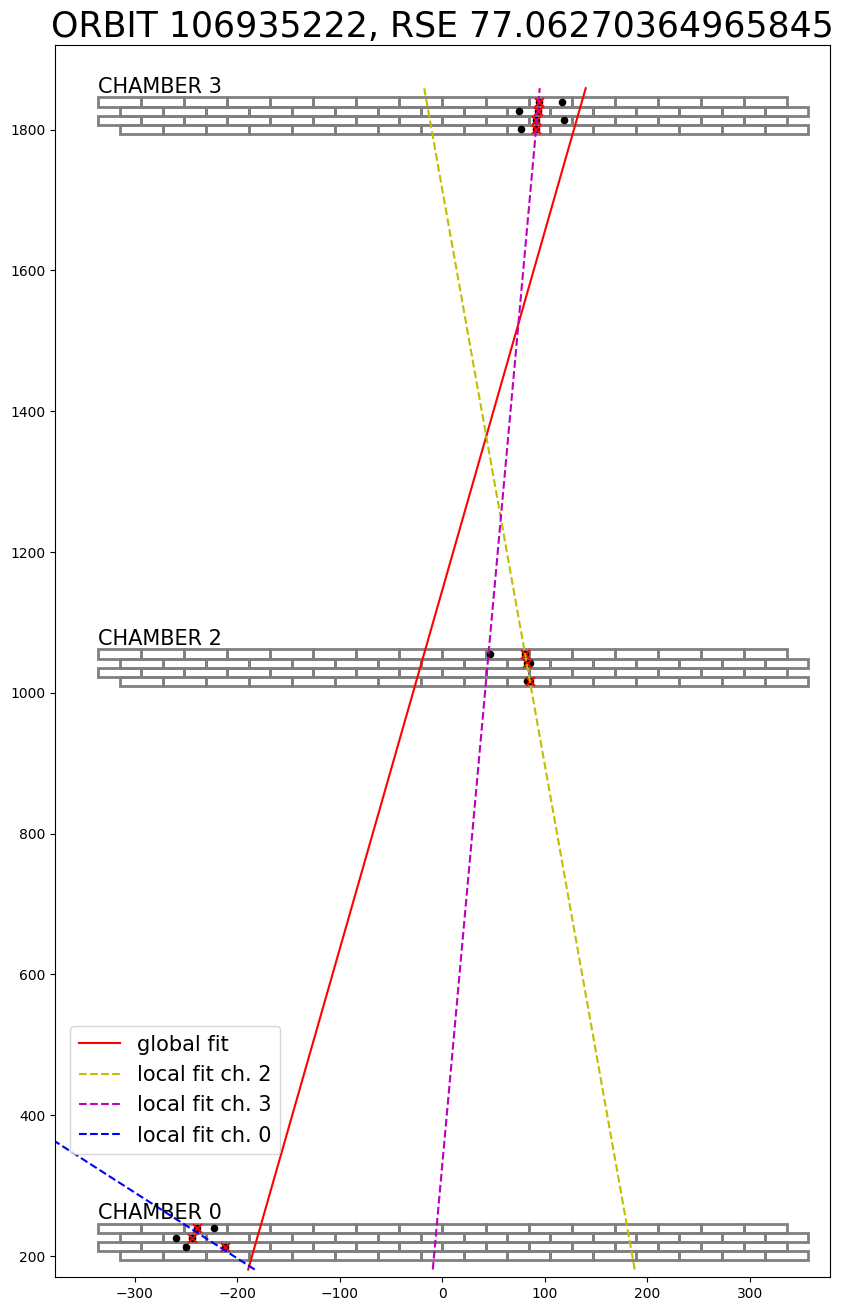

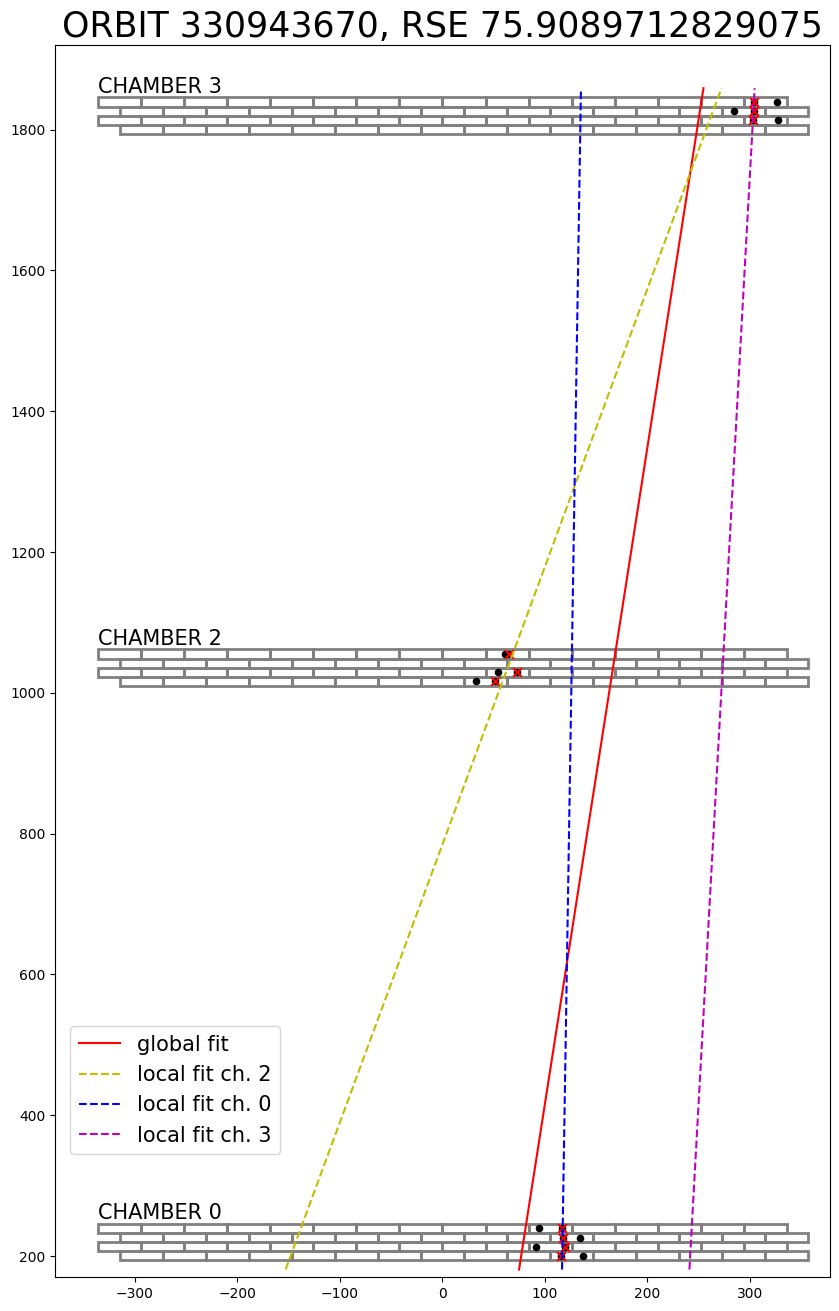

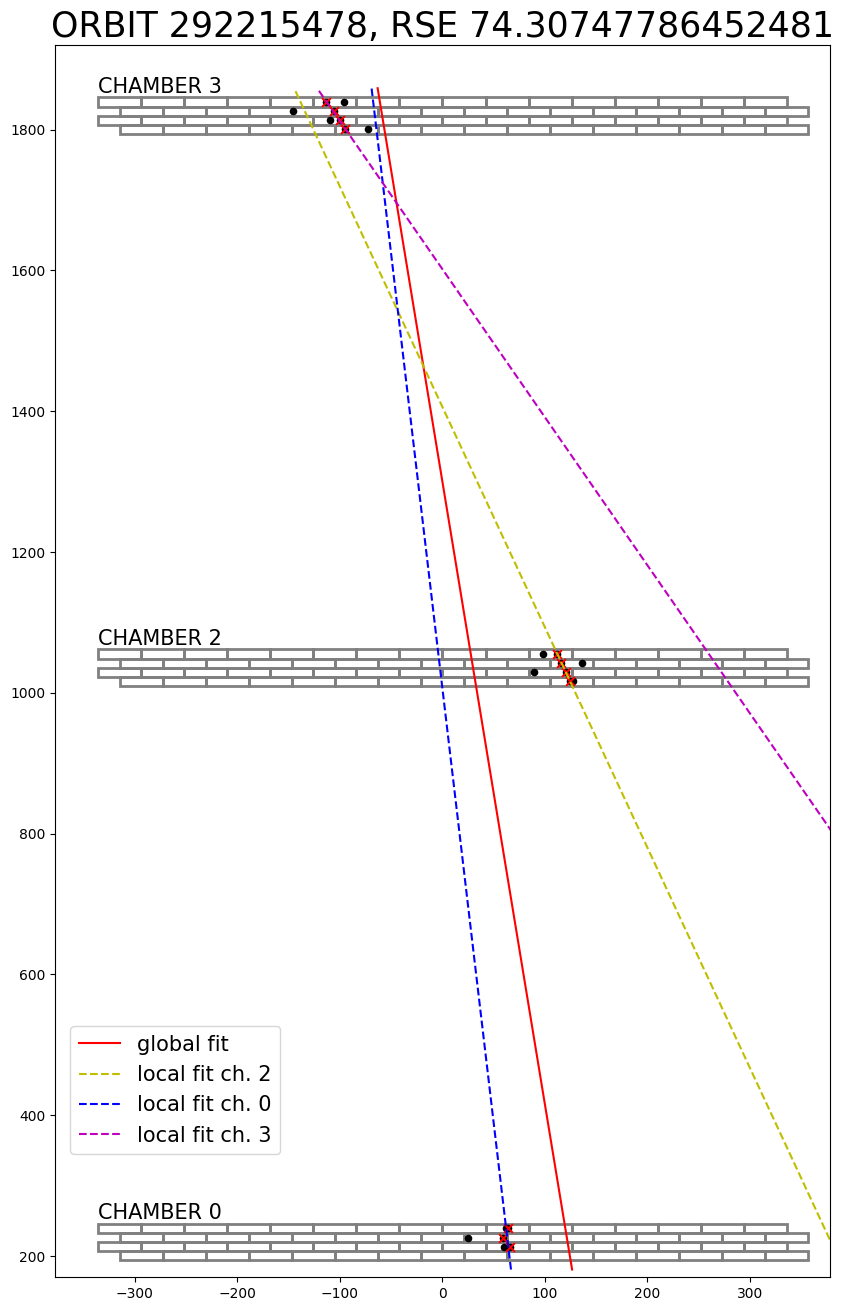

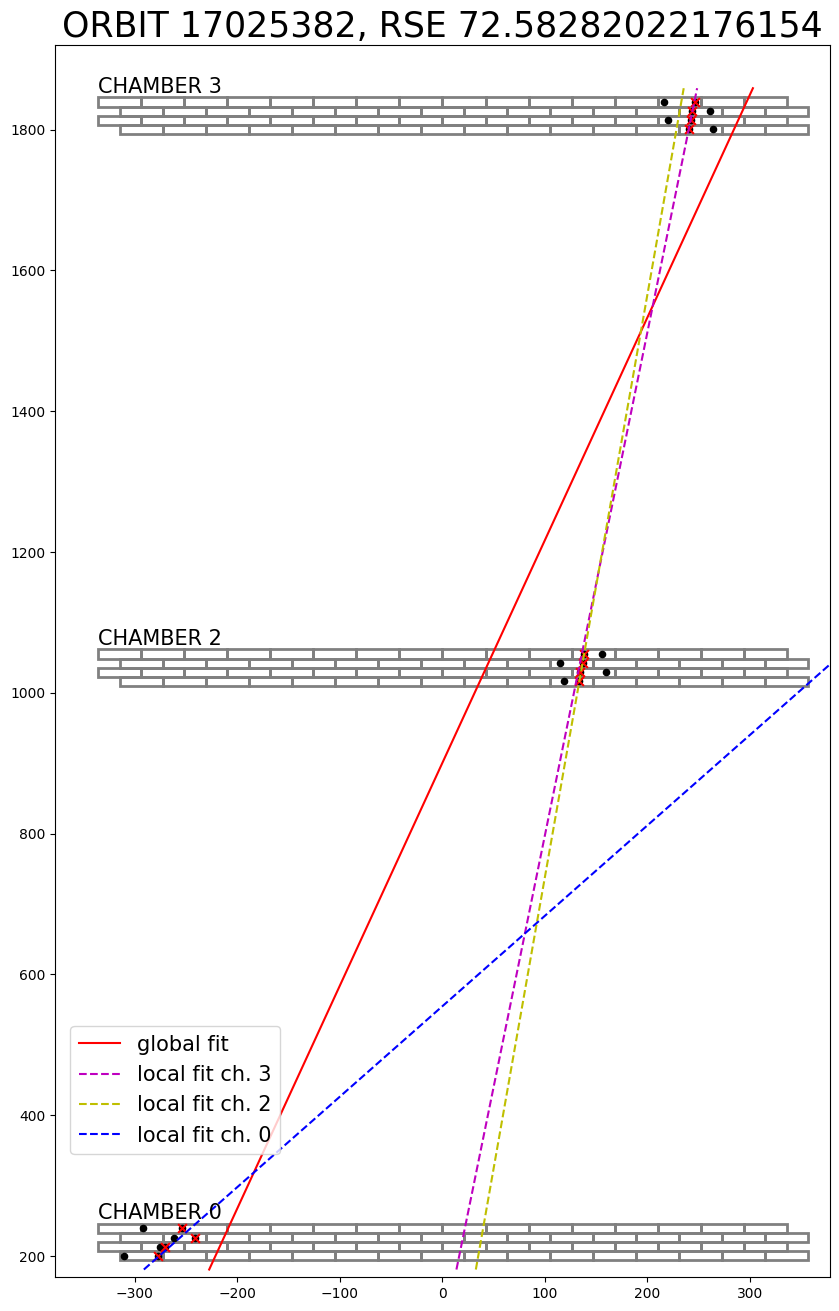

In [79]:
# plot a selection of orbits with RSE above the threshold

unique_orbits = final_above.select('ORBIT', 'RSE_g').distinct().orderBy('RSE_g', ascending = False)

for orbit in unique_orbits.take(5):
    
    plot_glob(final[final.ORBIT == orbit['ORBIT']].toPandas())

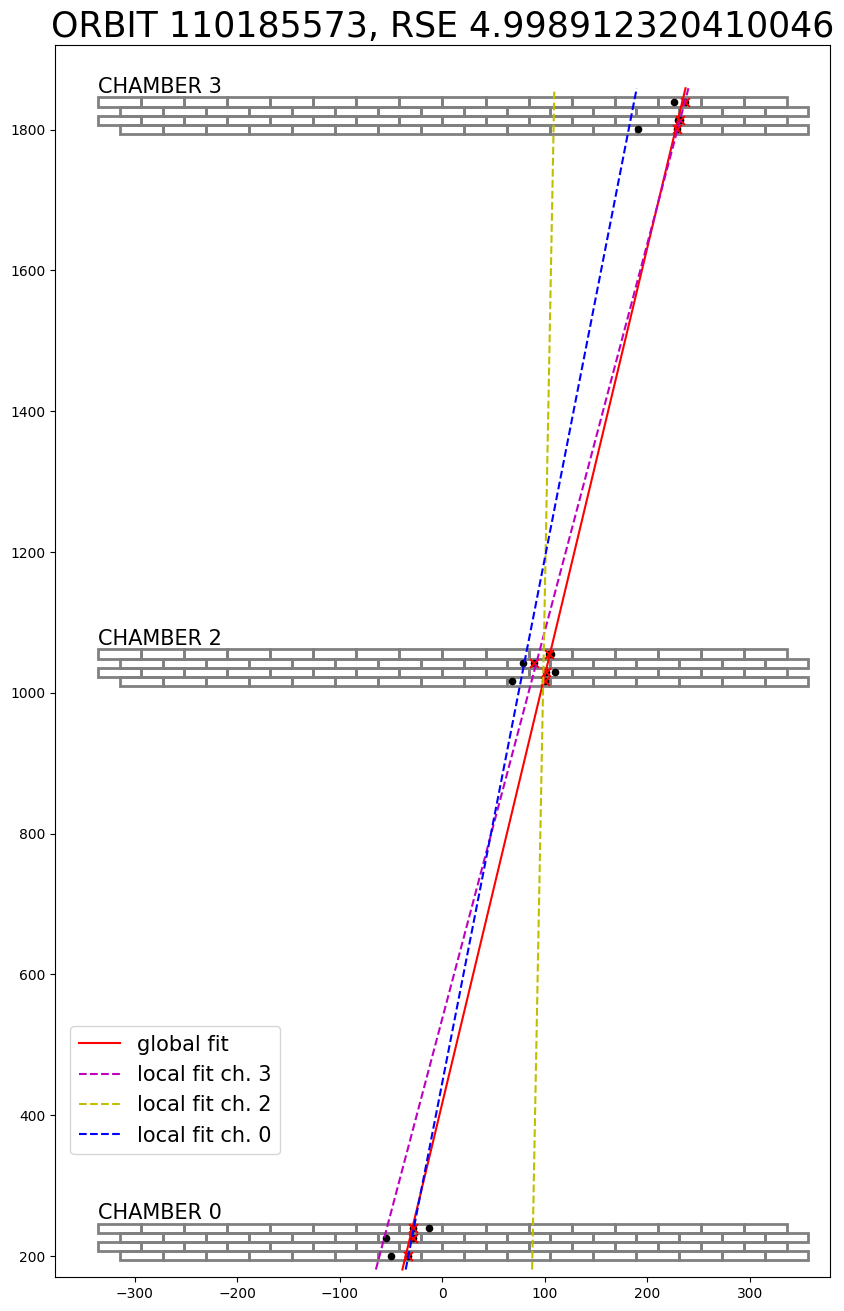

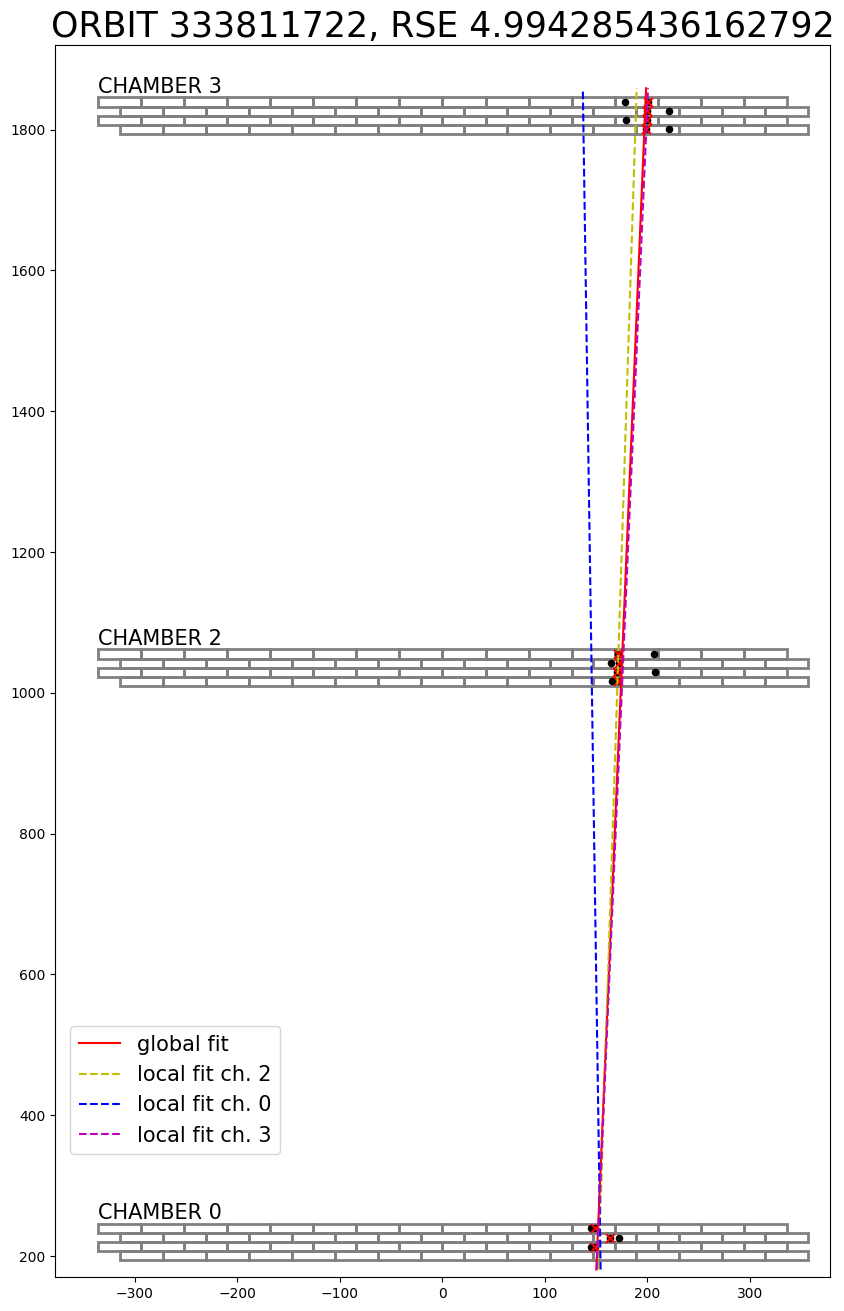

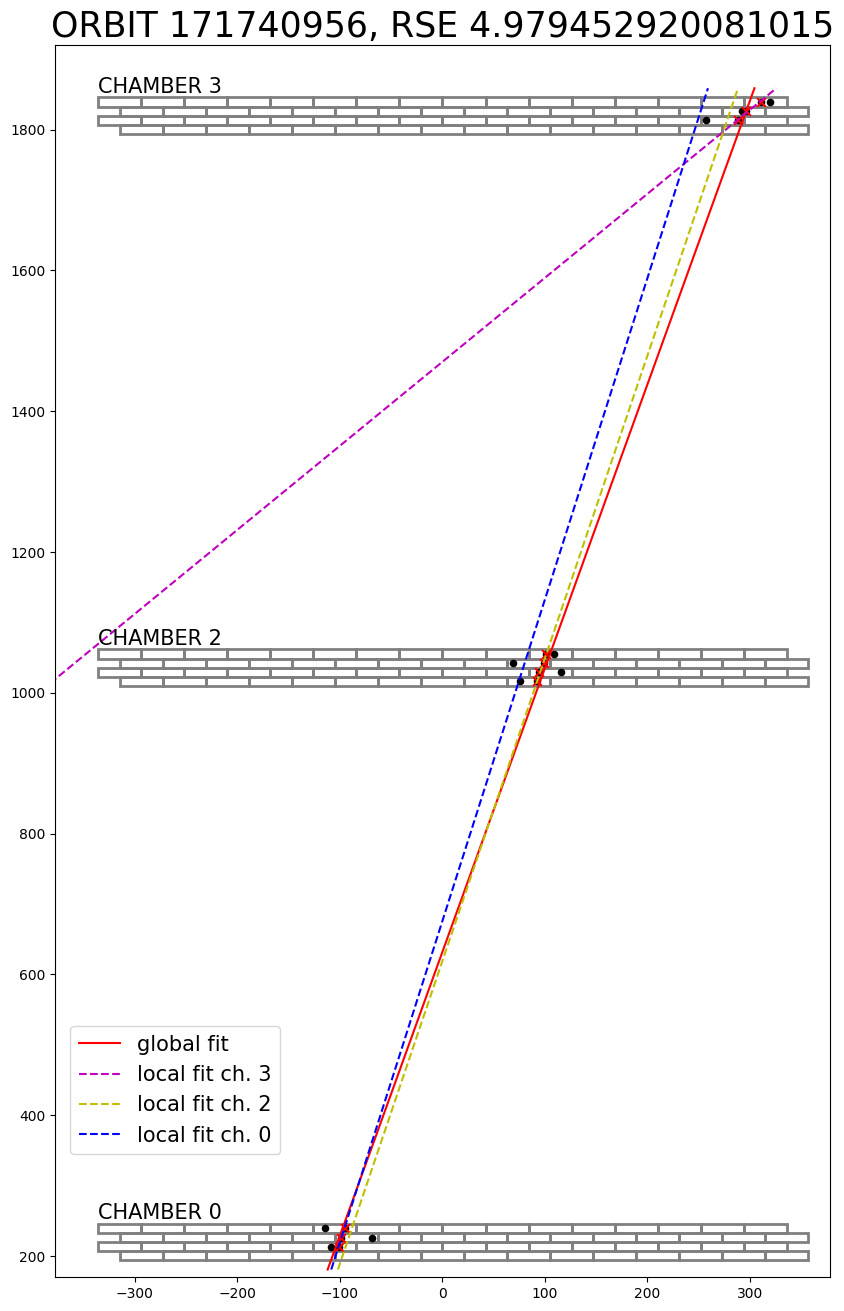

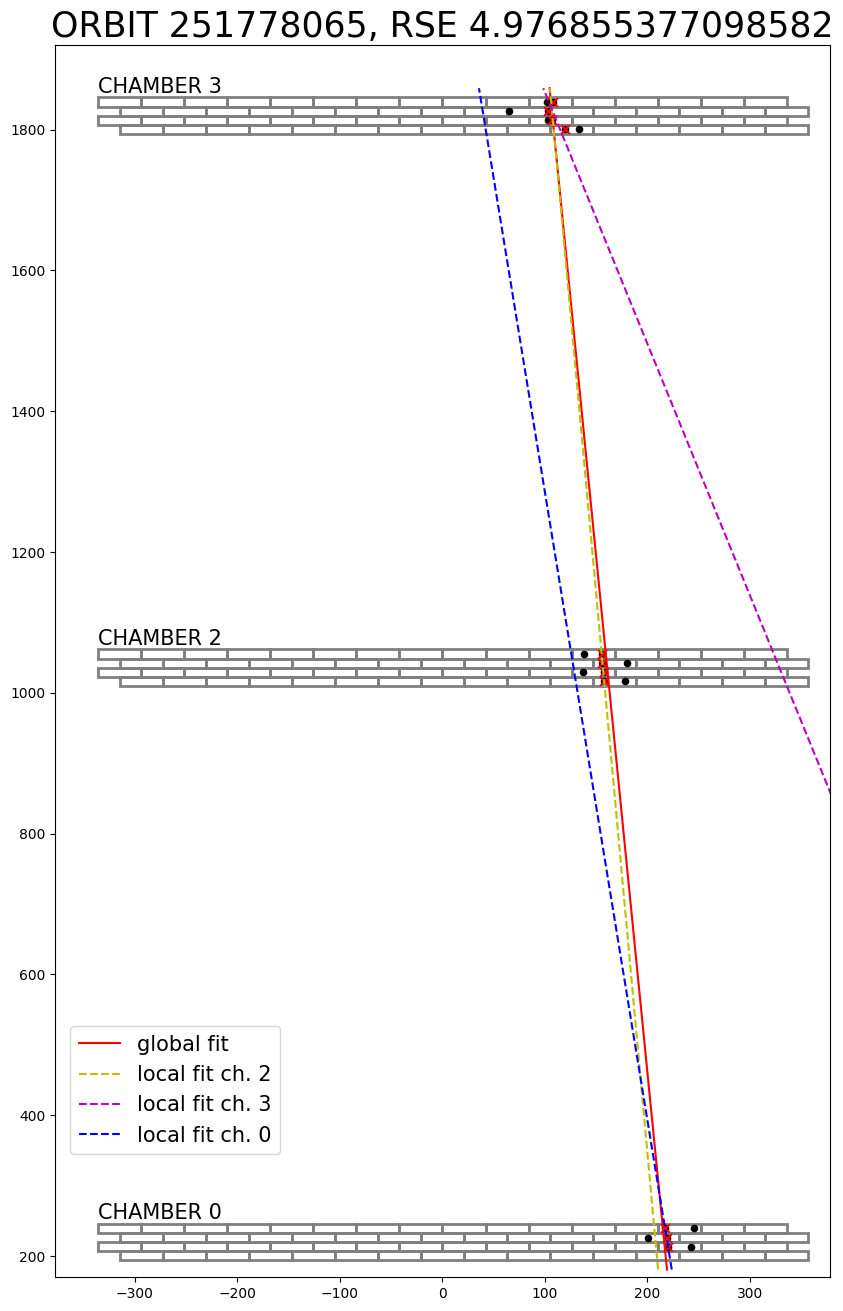

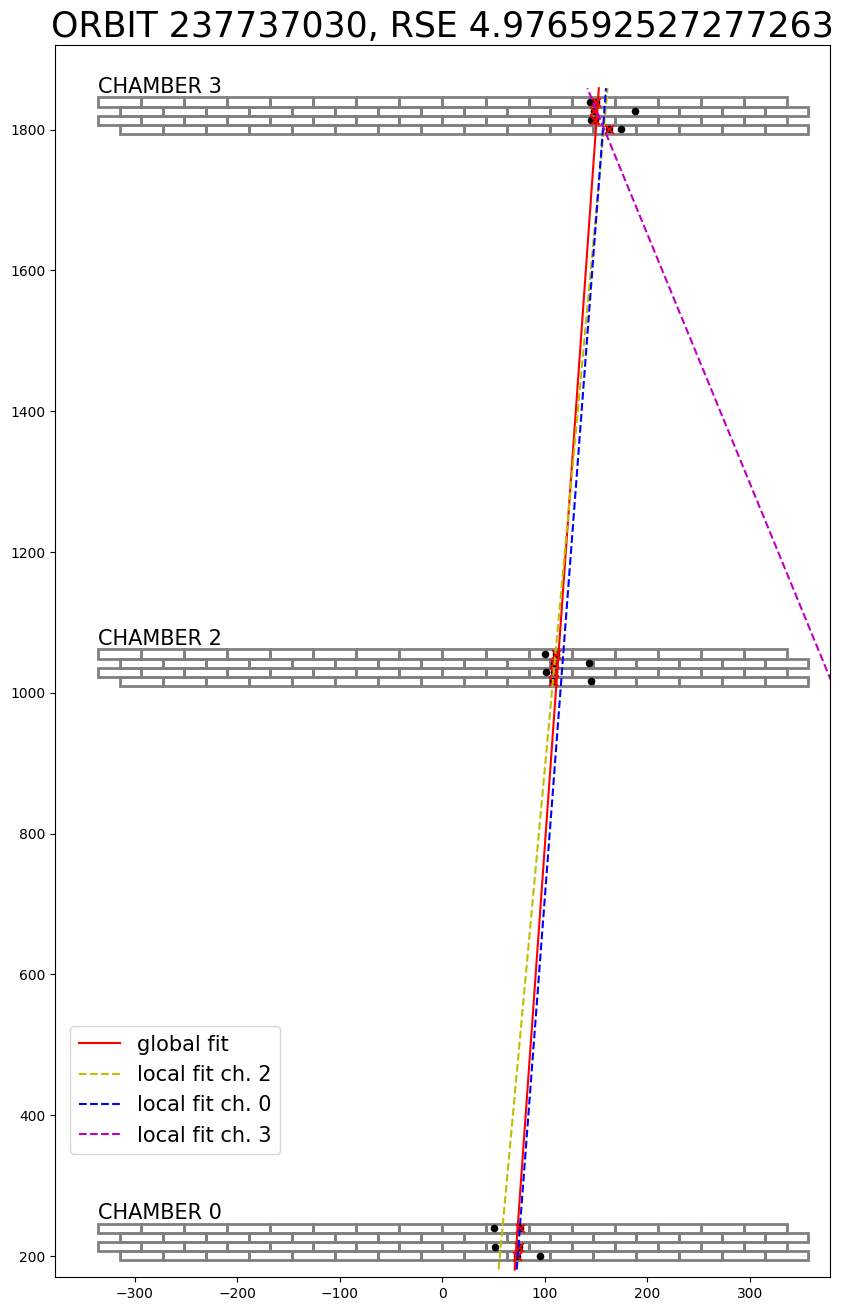

In [80]:
# plot a selection of orbits with RSE below the threshold

unique_orbits = df9_below.select('ORBIT', 'RSE_g').distinct().orderBy('RSE_g', ascending = False)

for orbit in unique_orbits.take(5):
    
    plot_glob(df9[df9.ORBIT == orbit['ORBIT']].toPandas())

However, we also keep a part of the whole dataset (including also orbits with the activation of only 2 chambers) with a much stricter threshold; the reason for this will be clear later.

In [81]:
threshold_strict = 0.9 # chosen such to keep ~50% of the dataset

final_strict_below = final.where(col('RSE_g') < threshold_strict)
final_strict_below.count()

116816

### 8) Angular difference

As the last analysis of the dataset we try to give an estimate of the detector angular resolution. This is given by the difference between the angle (in milli-radians) of the global track and the local track measured from Chamber 2.\
We proceed to produce such a plot for the whole, cleaned dataset as well as for the various further selections that we have operated:
- the trajectories that - upon qualitative estimate - are most probably associated with the passage of a single muon, including all orbits where 2 or 3 chambers have activated;
- the trajectories that - upon qualitative estimate - are most probably associated with the passage of a single muon, including only the orbits where 3 chambers have activated;
- the trajectories with RSE below a much stricter threshold.

In [82]:
# select only the features of interest, keeping only distinct hits of chamber 2
df10 = final.select('ORBIT', 'CHAMBER', 'm', 'm_g').where(col('CHAMBER') == 2).distinct().drop('CHAMBER')
df11 = final_below.select('ORBIT', 'CHAMBER', 'm', 'm_g').where(col('CHAMBER') == 2).distinct().drop('CHAMBER')
df12 = df9_below.select('ORBIT', 'CHAMBER', 'm', 'm_g').where(col('CHAMBER') == 2).distinct().drop('CHAMBER')
df13 = final_strict_below.select('ORBIT', 'CHAMBER', 'm', 'm_g').where(col('CHAMBER') == 2).distinct().drop('CHAMBER')

In [83]:
# add column with the difference of the angles, and convert to milliradians
df10 = df10.withColumn('angle_diff', atan((df10.m - df10.m_g)/(1 + df10.m * df10.m_g)) * 1000)
df11 = df11.withColumn('angle_diff', atan((df11.m - df11.m_g)/(1 + df11.m * df11.m_g)) * 1000)
df12 = df12.withColumn('angle_diff', atan((df12.m - df12.m_g)/(1 + df12.m * df12.m_g)) * 1000)
df13 = df13.withColumn('angle_diff', atan((df13.m - df13.m_g)/(1 + df13.m * df13.m_g)) * 1000)

Given the small dimensions of the so far obtained lists of angles, we save them locally by means of a `collect`, to perform the following computations more easily:

In [84]:
# convert to a numpy array for plotting
angle_diff_all = np.array(df10.select('angle_diff').collect()).flatten()
angle_diff_clean23 = np.array(df11.select('angle_diff').collect()).flatten()
angle_diff_clean3 = np.array(df12.select('angle_diff').collect()).flatten()
angle_diff_clean23_strict = np.array(df13.select('angle_diff').collect()).flatten()

In [85]:
print(len(angle_diff_all), len(angle_diff_clean23), len(angle_diff_clean3), len(angle_diff_clean23_strict))

23632 22104 4508 14583


In [86]:
mean_all = np.mean(angle_diff_all)
std_all = np.std(angle_diff_all)

mean_clean23 = np.mean(angle_diff_clean23)
std_clean23 = np.std(angle_diff_clean23)

mean_clean3 = np.mean(angle_diff_clean3)
std_clean3 = np.std(angle_diff_clean3)

mean_clean23_strict = np.mean(angle_diff_clean23_strict)
std_clean23_strict = np.std(angle_diff_clean23_strict)

In [87]:
print("Means: ", mean_all, mean_clean23, mean_clean3, mean_clean23_strict)
print("Stds: ", std_all, std_clean23, std_clean3, std_clean23_strict)

Means:  1.0201687126046415 1.2968201112989322 3.225652880854417 1.2301603683627194
Stds:  68.79258065499263 48.38707622225489 44.31358385811576 16.701327190763923


Giving a look at the means we can observe that they are all around 0, which is what we would expect. On the other hand, by looking at the standard deviations we notice that they decrease as the cleansing becomes more aggressive.

Indeed, we would expect such angle difference to be distributed according to a Gaussian curve. In fact, however, some background is still present, affecting the actual shape of the distribution. A better way of modelling it is therefore to consider a double Gaussian: we expect a narrower Gaussian component relative to the correct detection of the passage of a single muon, and a broader component associated to noise. Both components are assumed to have the same mean. 

$$f(x) = A \cdot \exp\left(-\frac{(x - \mu)^2}{2\sigma_1^2}\right) + B \cdot \exp\left(-\frac{(x - \mu)^2}{2\sigma_2^2}\right)$$

The fit results are show below.

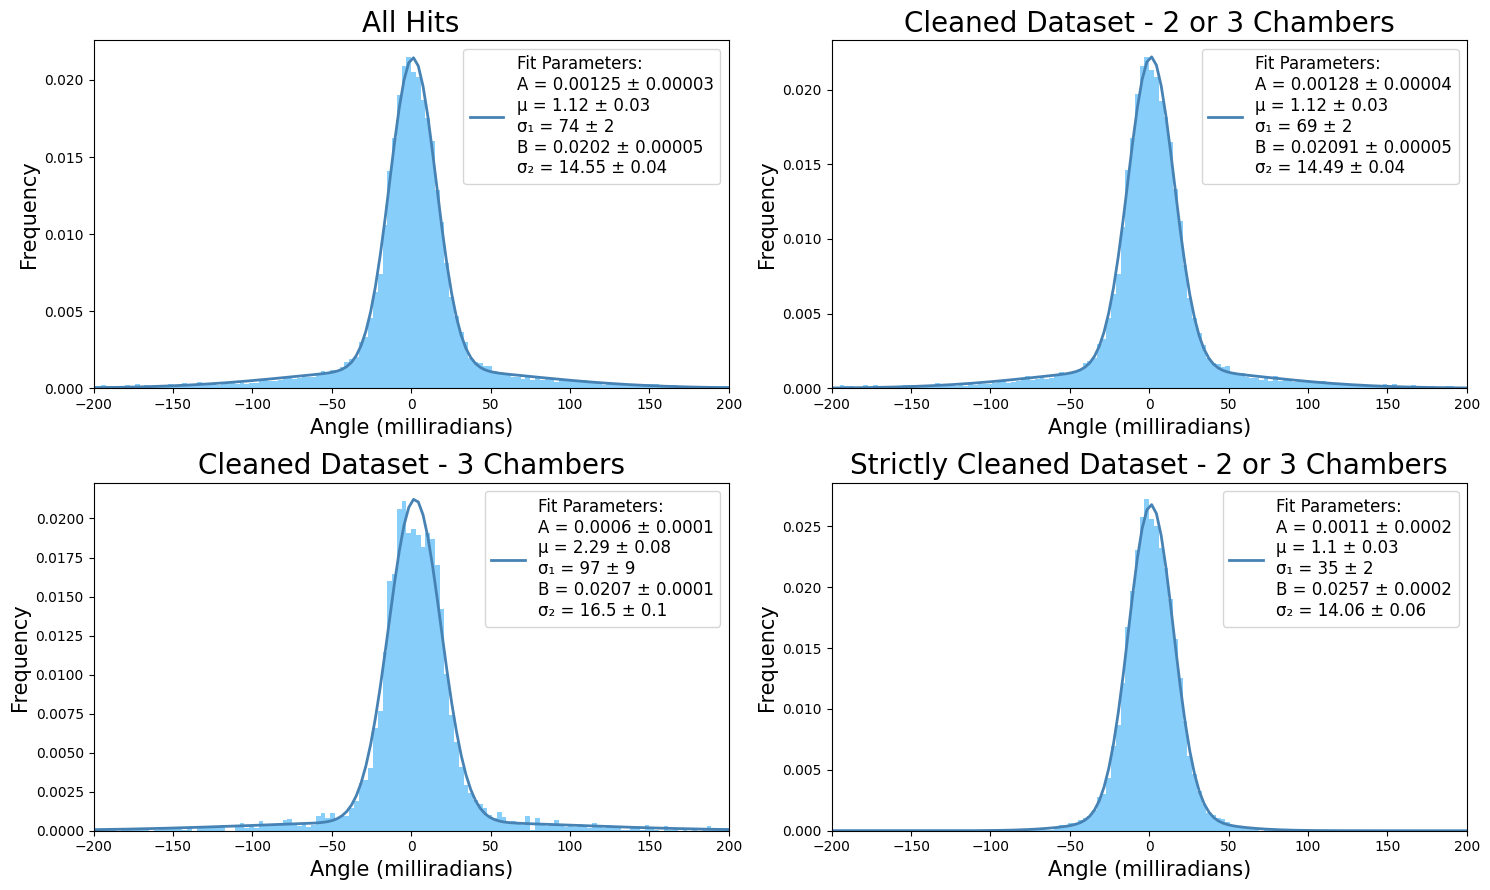

In [88]:
# Define the function to fit
def func(x, A, mu, s1, B, s2):
    return A * np.exp(-(x - mu)**2 / (2 * s1**2)) + B * np.exp(-(x - mu)**2 / (2 * s2**2))


# List with fit parameters
fit_param=[]

# List with error fit parameters
fit_error=[]

# Specify the path to your text files
title_=['All Hits', 'Cleaned Dataset - 2 or 3 Chambers', "Cleaned Dataset - 3 Chambers","Strictly Cleaned Dataset - 2 or 3 Chambers"]
# Set the figure size and create a 2 x 2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

# Plot the histogram and fit for each file path
counts, edges, _ = axs[0, 0].hist(angle_diff_all, bins=1000, range=(-1500, 1500), density=True, color='lightskyblue')
binwidth = abs(edges[1] - edges[2])
area = binwidth * np.sum(counts)

# Initial parameters of the fit 
x = (edges[:-1] + edges[1:]) / 2
A = np.max(counts * area)
mu = x[np.argmax(counts)]
s1 = abs((np.max(x) - np.min(x)) / 4)
B = np.max(counts * area) / 2
s2 = abs((np.max(x) - np.min(x)) / 8)
bounds = ([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

# Fit and error
popt, pcov = curve_fit(func, x, counts * area, p0=[A, mu, s1, B, s2], bounds=bounds)
std_dev = np.sqrt(np.diag(pcov))
fit_param.append(popt)
fit_error.append(std_dev)

# Plot the fit 
axs[0, 0].plot(x, func(x, *popt), 'steelblue', label='fit', linewidth=2)
axs[0, 0].set_xlabel('Angle (milliradians)', fontsize=15)
axs[0, 0].set_ylabel('Frequency', fontsize=15)
axs[0, 0].set_title(title_[0], fontsize=20)
axs[0, 0].set_xlim(-200, 200)
legend_text = "Fit Parameters:\nA = {:.3g} ± {:.5f}\nμ = {:.3g} ± {:.1g}\nσ₁ = {:.2g} ± {:.1g}\nB = {:.4g} ± {:.5f}\nσ₂ = {:.4g} ± {:.1g}".format(popt[0], std_dev[0], popt[1], std_dev[1], popt[2], std_dev[2], popt[3], std_dev[3], popt[4], std_dev[4])
legend = axs[0, 0].legend([legend_text], frameon=True, loc='upper right', fontsize=12)
frame = legend.get_frame()
frame.set_facecolor('white')

# Histogram definition 
counts, edges, _ = axs[0, 1].hist(angle_diff_clean23, bins=1000, range=(-1500, 1500), density=True, color='lightskyblue')
binwidth = abs(edges[1] - edges[2])
area = binwidth * np.sum(counts)

# Initial parameters of the fit 
x = (edges[:-1] + edges[1:]) / 2
A = np.max(counts * area)
mu = x[np.argmax(counts)]
s1 = abs((np.max(x) - np.min(x)) / 4)
B = np.max(counts * area) / 2
s2 = abs((np.max(x) - np.min(x)) / 8)
bounds = ([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

# Fit and error
popt, pcov = curve_fit(func, x, counts * area, p0=[A, mu, s1, B, s2], bounds=bounds)
std_dev = np.sqrt(np.diag(pcov))
fit_param.append(popt)
fit_error.append(std_dev)

# Plot the fit 
axs[0, 1].plot(x, func(x, *popt), 'steelblue', label='fit', linewidth=2)
axs[0, 1].set_xlabel('Angle (milliradians)', fontsize=15)
axs[0, 1].set_ylabel('Frequency', fontsize=15)
axs[0, 1].set_title(title_[1], fontsize=20)
axs[0, 1].set_xlim(-200, 200)
legend_text = "Fit Parameters:\nA = {:.3g} ± {:.5f}\nμ = {:.3g} ± {:.1g}\nσ₁ = {:.2g} ± {:.1g}\nB = {:.4g} ± {:.5f}\nσ₂ = {:.4g} ± {:.1g}".format(popt[0], std_dev[0], popt[1], std_dev[1], popt[2], std_dev[2], popt[3], std_dev[3], popt[4], std_dev[4])
legend = axs[0, 1].legend([legend_text], frameon=True, loc='upper right', fontsize=12)
frame = legend.get_frame()
frame.set_facecolor('white')

# Histogram definition 
counts, edges, _ = axs[1, 0].hist(angle_diff_clean3, bins=1000, range=(-1500, 1500), density=True, color='lightskyblue')
binwidth = abs(edges[1] - edges[2])
area = binwidth * np.sum(counts)

# Initial parameters of the fit 
x = (edges[:-1] + edges[1:]) / 2
A = np.max(counts * area)
mu = x[np.argmax(counts)]
s1 = abs((np.max(x) - np.min(x)) / 4)
B = np.max(counts * area) / 2
s2 = abs((np.max(x) - np.min(x)) / 8)
bounds = ([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

# Fit and error
popt, pcov = curve_fit(func, x, counts * area, p0=[A, mu, s1, B, s2], bounds=bounds)
std_dev = np.sqrt(np.diag(pcov))
fit_param.append(popt)
fit_error.append(std_dev)

# Plot the fit 
axs[1, 0].plot(x, func(x, *popt), 'steelblue', label='fit', linewidth=2)
axs[1, 0].set_xlabel('Angle (milliradians)', fontsize=15)
axs[1, 0].set_ylabel('Frequency', fontsize=15)
axs[1, 0].set_title(title_[2], fontsize=20)
axs[1, 0].set_xlim(-200, 200)
legend_text = "Fit Parameters:\nA = {:.1g} ± {:.4f}\nμ = {:.3g} ± {:.1g}\nσ₁ = {:.2g} ± {:.1g}\nB = {:.3g} ± {:.4f}\nσ₂ = {:.3g} ± {:.1g}".format(popt[0], std_dev[0], popt[1], std_dev[1], popt[2], std_dev[2], popt[3], std_dev[3], popt[4], std_dev[4])
legend = axs[1, 0].legend([legend_text], frameon=True, loc='upper right', fontsize=12)
frame = legend.get_frame()
frame.set_facecolor('white')

# Histogram definition 
counts, edges, _ = axs[1, 1].hist(angle_diff_clean23_strict, bins=1000, range=(-1500, 1500), density=True, color='lightskyblue')
binwidth = abs(edges[1] - edges[2])
area = binwidth * np.sum(counts)

# Initial parameters of the fit 
x = (edges[:-1] + edges[1:]) / 2
A = np.max(counts * area)
mu = x[np.argmax(counts)]
s1 = abs((np.max(x) - np.min(x)) / 4)
B = np.max(counts * area) / 2
s2 = abs((np.max(x) - np.min(x)) / 8)
bounds = ([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

# Fit and error
popt, pcov = curve_fit(func, x, counts * area, p0=[A, mu, s1, B, s2], bounds=bounds)
std_dev = np.sqrt(np.diag(pcov))
fit_param.append(popt)
fit_error.append(std_dev)

# Plot the fit 
axs[1, 1].plot(x, func(x, *popt), 'steelblue', label='fit', linewidth=2)
axs[1, 1].set_xlabel('Angle (milliradians)', fontsize=15)
axs[1, 1].set_ylabel('Frequency', fontsize=15)
axs[1, 1].set_title(title_[3], fontsize=20)
axs[1, 1].set_xlim(-200, 200)
legend_text = "Fit Parameters:\nA = {:.4f} ± {:.4f}\nμ = {:.3g} ± {:.1g}\nσ₁ = {:.2g} ± {:.1g}\nB = {:.4f} ± {:.4f}\nσ₂ = {:.4g} ± {:.1g}".format(popt[0], std_dev[0], popt[1], std_dev[1], popt[2], std_dev[2], popt[3], std_dev[3], popt[4], std_dev[4])
legend = axs[1, 1].legend([legend_text], frameon=True, loc='upper right', fontsize=12)
frame = legend.get_frame()
frame.set_facecolor('white')

#transform fit list into array
fit_param=np.array(fit_param)
fit_error=np.array(fit_error)

plt.tight_layout()
plt.show()

In [89]:
A      = fit_param[:,0]
mu     = fit_param[:,1]
sigma1 = fit_param[:,2]
B      = fit_param[:,3]
sigma2 = fit_param[:,4]

A_err      = fit_error[:,0]
mu_err     = fit_error[:,1]
sigma1_err = fit_error[:,2]
B_err      = fit_error[:,3]
sigma2_err = fit_error[:,4]

print("B to A ratio:", B / A)

B to A ratio: [16.17233526 16.29100781 34.94158619 23.50022765]


First of all, we observe that in all cases the mean of the distribution is about 1 - 2 mrad, not compatible with 0 but in any case really close (2 mrad correspond to about 0.11 degrees). 

Secondly, we observe that indeed the double Gaussian curve follows very well the distribution of the data, which, as expected, results to have a narrow and a broad component, with the narrow component being definitely predominant (at least ~15 times larger than the broad). 
In addition, the narrow components of the four plots, albeit non-compatible in general, are all quite close to each other, and close to the value of the strictly cleaned dataset. As a consequence, as we reduce the dataset keeping only the best global fits, the narrow component's standard deviation does not show a marked decrease, differently from the standard deviation of the whole distribution shown before.

Taking into account all these considerations, we could conclude that this fit unveils the true distribution of the data beyond the background. For this reason we suggest that, once the main passages to individuate correct activation upon the passage of a muon seen before are applied, it is not necessary to further reduce the dataset with additional considerations, which only improve the resolution estimate of a little quantity at the cost of losing statistical significance.
In particular, eliminating the orbits associated with the activation of only two chambers does not seem to lead to an outstanding improvement nor change with respect to the other cases, suggesting that these cases could actually be taken into account as valid.

Finally, we completely free the memory and stop the Spark Streaming and application.

In [90]:
final.unpersist()

DataFrame[ORBIT: int, CHAMBER: int, LAYER: int, XLEFT: double, XRIGHT: double, Z: double, XTRUE: double, m: double, q: double, RSE: double, m_g: double, q_g: double, RSE_g: double]

In [91]:
sc.stop()

In [92]:
spark.stop()

## 9) Performance Analysis

## Optimisation

We have tried to optimise the code as much as possible, reducing to the minimum the amount of data on which each operation was performed. To do this, we have made an effort in eliminating non-necessary rows or columns of the dataset as soon as possible, before manipulating them. Some examples of cases in which we have applied this are the following:
- we have dropped ancillary data immediately after loading the files;
- we have dropped chamber 1 immediately after completing the analysis on local fits, before starting the analysis on the global fit;
- we have always dropped `None` values immediately after their possible creation in functions and feature definitions;
- in general, when dealing with columns used to perform intermediate operations (like the number of hits per orbit or the absolute drift time), we have dropped them as long as we needed them no more.

Another important player in the performance optimisation is `persist`. As indicated a few times throughout the document, there are many points of the program where persisting the data becomes convenient or even necessary. After loading the data from the external source, after applying big manipulations on the dataset that dramatically reduce its size or before producing plots, persisting can give a great advantage in terms of performance. On the other hand, however, it might seize a significant part of the available resources, possibly causing performance worsening. To make the best out of the program, we must therefore understand in which cases persisting is convenient. For this reason, we have tested the time required to run a few selected sections of the program, with or without persisting. Here, some results are reported.

- Initially, we load a large amount of data from the S3 bucket into `df`, and then immediately perform some manipulations - to obtain `df0` - that lead to a reduction of ~99.5% of the occupied memory. Persisting `df0` is therefore certainly advantageous. However, primarily persisting `df` could further increase the performances, even if its size is very large. Indeed, running the program from the beginning to the persisting of `df0` requires:
    - ~195 s with persist both on `df` and `df0`,
    - ~230 s with persist only on `df0`.
    We have therefore decided to persist both, obviously unpersisting `df` after persisting `df0` to free up space.
    
- Later, with further manipulation we create the dataframe `df3` which is about half as large as `df0`. We have therefore run the program from the beginning until the persisting of `df6`, obtaining:
    - ~520 s with persist both on `df3` and `df6`,
    - ~365 s with persist only on `df6`.
    We have therefore decided to persist only `df6`, obviously unpersisting `df0` after persisting `df6` to free up space.
    
- Lastly, we have noticed that in all cases where some plot was required, its production was way slower if the dataframes from which the data was taken were not persisted. We have therefore persisted in all cases where some kind of plot was necessary. **Note:** some plots are displayed by loading them from an image, which was produced by some commented code that can be found in the cell immediately above. Also these dataframes were initially persisted when producing the plots.

## Cluster testing

In the final part of the project we investigated the performances of the small cluster at our disposal.\
As already mentioned, the cluster consists of three VMs, one acting as the Headnode (the Master) and the other two as Computing nodes (the Slaves).\
Each machine is provided with:
- 6.8 GByte of memory
- 4 cores

When a Spark application is created, it is possible to configure the dedicated computing memory for each worker, for instance by choosing the number of cores per executor `config("spark.executor.cores", ...)` and the memory for each executor `config("spark.executor.memory", ...)`. Then, Spark will create the maximum number of executors per worker with the available resources. 
Therefore, having just 4 PU for each worker, we varied the number of cores per executor. The possible configurations were:
- 1 executor with 4 cores per worker (6.8 GB per executor)
- 2 executors with 2 cores per worker (3.4 GB per executor)
- 4 executors with 1 core per worker (1.7 GB per executor)

The performance is judged by measuring the computing time, from the data loading to the creation of the `final` dataframe, and the configuration with the least timing is determined to be the best one.\
The cluster time was determined using the Python `time` module (as a simple difference between the execution time of the considered cells) rather than reading it for each job from the Spark UIs. This is due to the fact that the purely Python code of the notebook running on the Master is expected to be fast (we commented the cells displaying the orbit plots) therefore the time is almost exclusively due to the computations on the workers.\
Note that we ran the computations once per configuration, since some of them take up to 10 min, therefore it was difficult to accumulate enough statistics. However, various trials showed a time variability of ~10 s for successive identical trials.

First of all, we investigated the change in performance by varying the total available memory, setting one executor per worker with four cores. The results are:

| RAM GB per executor (4 cores, 2 executors, 24 partitions) | time (s) |
|---------------------------------------------------------|-------|
| 6 nominal (5.9 real)                                            | 437   |
| 6.4 nominal (6.3 real)                                          | 430   |
| 6.8 nominal (6.6 real)                                          | 420   |
| 6.9 nominal (6.7 real)                                          | 417   |

As expected, we observe that with more RAM at disposal the computing time reduces.\
Notice that Spark automatically allocates slightly less memory than what is set, since part of it is use for internal network processes. Moreover, allocating the whole memory at disposal (7 GB nominal) leads the cluster to crash. For these reasons, in the following we set 6.9 nominal as the used memory.

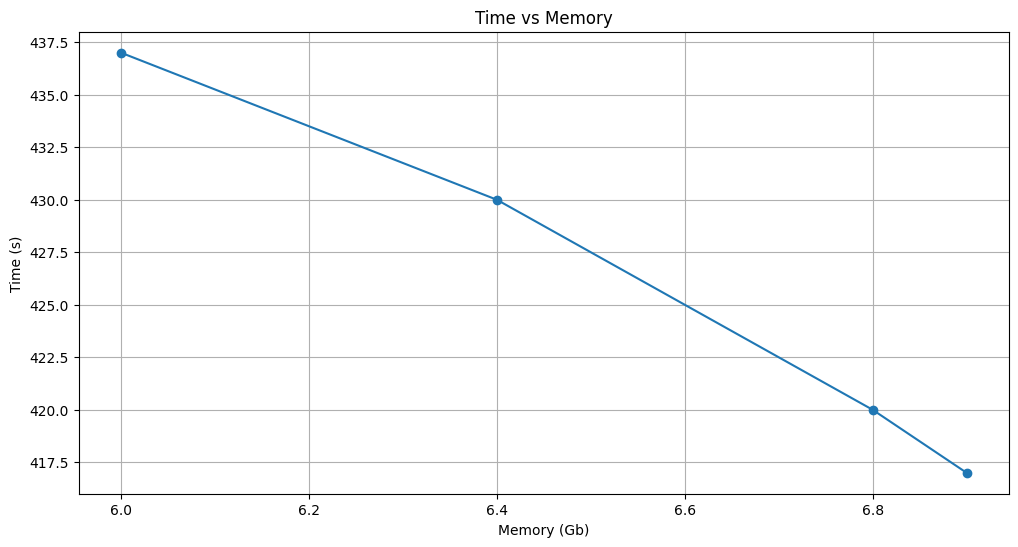

In [93]:
# Data for Memory vs. Time plot
memory = [6, 6.4, 6.8, 6.9]
time_m = [437, 430, 420, 417]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot 1: Memory vs. Time
ax.plot(memory,time_m, marker='o')
ax.set_xlabel('Memory (Gb)')
ax.set_ylabel('Time (s)')
ax.set_title('Time vs Memory')
ax.grid(True)


Moreover, we investigated the change in performance by varying the number of partitions in which the DataFrame is split across the nodes. In particular, we considered the cases in which the partitions were 16, 24, 40, 64, which are multiples of the number of cores (8) since each partition is processed as a task by a single core. 


The results of the test are schematized here:

| exec/worker | cores/exec | TOT cores | RAM/exec (GB) | N partitions | time (s) |
|-------------|------------|-----------|---------------|--------------|----------|
| 1           | 4          | 8         | 6.9           | 16           | 468      |
| 1           | 4          | 8         | 6.9           | 24           | 417      |
| 1           | 4          | 8         | 6.9           | 40           | 438      |
| 1           | 4          | 8         | 6.9           | 64           | 448      |
| 2           | 2          | 8         | 3.45          | 16           | 471      |
| 2           | 2          | 8         | 3.45          | 24           | 454      |
| 2           | 2          | 8         | 3.45          | 40           | 455      |
| 2           | 2          | 8         | 3.45          | 64           | 472      |
| 4           | 1          | 8         | 1.725         | 16           | 496      |
| 4           | 1          | 8         | 1.725         | 24           | 485      |
| 4           | 1          | 8         | 1.725         | 40           | 489      |
| 4           | 1          | 8         | 1.725         | 64           | 490      |

The best configuration seems to be the one with 1 executor per worker, each with 4 cores, and dividing the data in 24 partitions. This seems in agreement with what is suggested in the documentation (https://spark.apache.org/docs/latest/tuning.html#level-of-parallelism), in which 2-3 tasks per core are recommended in general. At the same time, it is also suggested to set 4-5 cores per executor, as what we found.

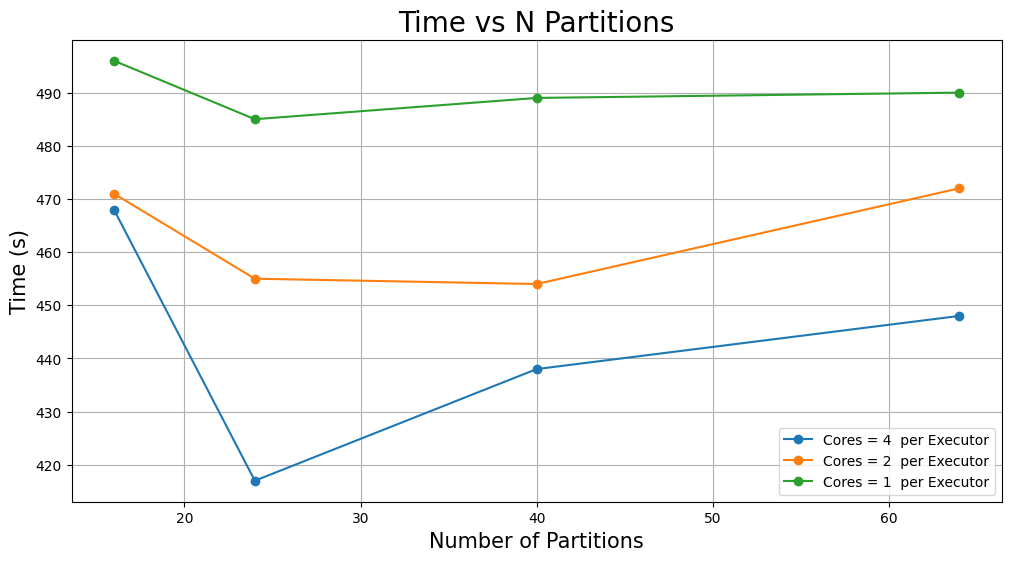

In [95]:
# Data for Executor 1
partitions_1 = [16, 24, 40, 64]
time_1 = [ 468, 417, 438, 448]

# Data for Executor 2
partitions_2 = [16, 24, 40, 64]
time_2 = [471, 455, 454, 472]

# Data for Executor 3
partitions_3 = [16, 24,40,64]
time_3 = [496, 485,489,490]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(partitions_1, time_1, marker='o', label='Cores = 4  per Executor')
ax.plot(partitions_2, time_2, marker='o', label='Cores = 2  per Executor')
ax.plot(partitions_3, time_3, marker='o', label='Cores = 1  per Executor')

ax.set_xlabel('Number of Partitions',size=15)
ax.set_ylabel('Time (s)',size=15)
ax.set_title('Time vs N Partitions',size=20)
ax.legend()
ax.grid(True)
fig.show()

We furthermore tried other configurations in which part of the resources were not exploited, to see the effect on the overall performances and justify the use of the whole resources above.\
Firstly we studied the optimisation due to the parallelization of the tasks on different cores: we created only 1 executor per worker having at disposal all the available memory, with 1, 2, 3 or 4 cores per executor. We have also run the program with only one executor with one core, to have a reference for the calculation of the speed-up.

| TOT cores | RAM/exec (GB) | N partitions | time (s)       |
|-----------|---------------|--------------|----------------|
| 1         | 6.9           | 24           | 2,481          |
| 2         | 6.9           | 24           | 1,274          |
| 4         | 6.9           | 24           | 683            |
| 6         | 6.9           | 24           | 513            |
| 8         | 6.9           | 24           | 417            |

We see (as expected) that indeed running the tasks in parallel reduces the time for the computation.\

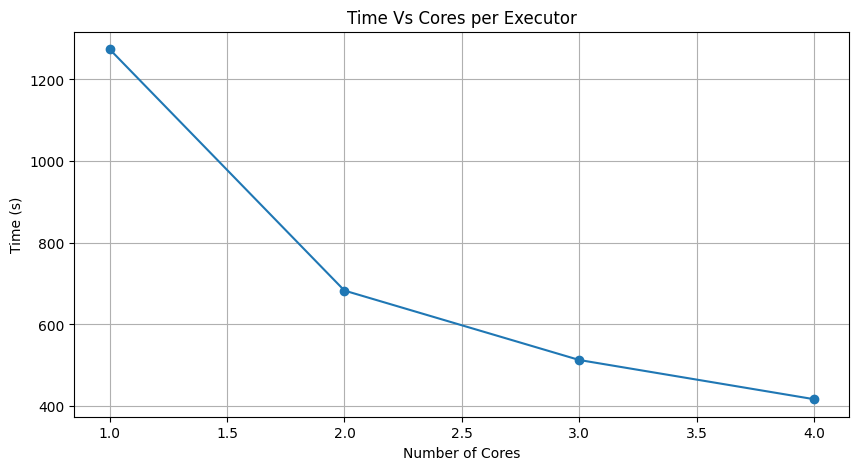

In [96]:
# Data for Cores vs. Time plot
cores = [1, 2, 3, 4]
time_c = [1274, 683, 513, 417]

# Creating subplots with a 1x2 grid
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot 2: Cores vs. Time
ax.plot(cores, time_c, marker='o')
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Time (s)')
ax.set_title('Time Vs Cores per Executor')
ax.grid(True)

plt.subplots_adjust(wspace=0.3)
plt.show()

This is further investigated with Amdahl's and Gustafson's laws, whose plots are shown below.
The formulas for the two laws are:
- Amdahl: $speedup = \dfrac{1}{(1-p)+(\frac{p}{n})}$
- Gustafson: $speedup = 1+(n-1) \cdot p $  <br>  <br>
where n the total number of PUs, p is the fraction of time spent executing the parallel parts of the program and the speedup is defined as $speedup_n = \dfrac{time_{1 PU}}{time_{n PUs}}$

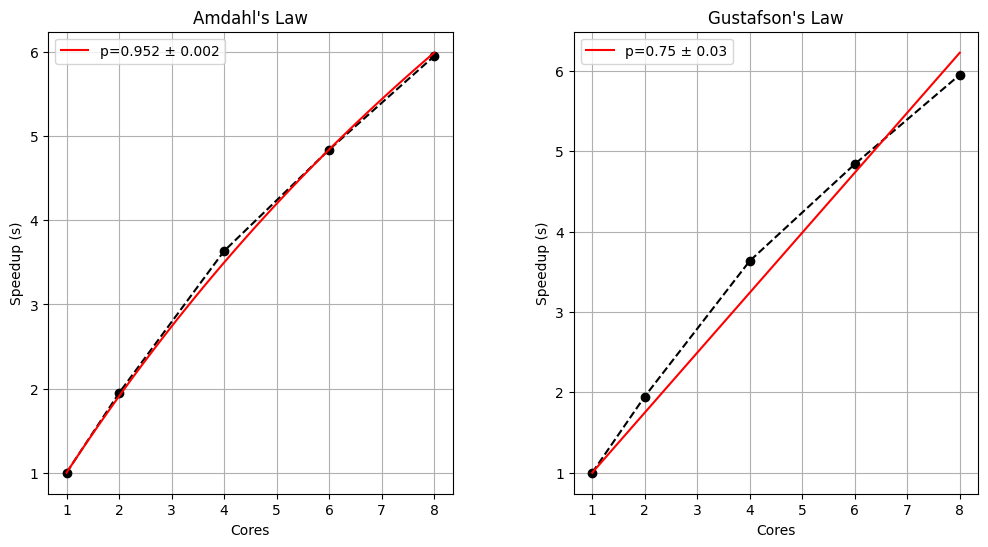

In [98]:
# Data
cores = np.array([1, 2, 4, 6, 8])
speedup = np.array([1, 1.947484014, 3.6346361, 4.83895389, 5.950528346])

# Define Amdahl's law function
def amdahl_law(x, p):
    return 1 / ((1 - p) + (p / x))

# Perform the curve fit for Amdahl's law
p_opt_amdahl, p_cov_amdahl = curve_fit(amdahl_law, cores, speedup)
p_amdahl, p_error_amdahl = p_opt_amdahl[0], np.sqrt(np.diag(p_cov_amdahl))[0]

# Define Gustafson's law function
def gustafson_law(x, p):
    return (x - 1) * p + 1

# Perform the curve fit for Gustafson's law
p_opt_gustafson, p_cov_gustafson = curve_fit(gustafson_law, cores, speedup)
p_gustafson, p_error_gustafson = p_opt_gustafson[0], np.sqrt(np.diag(p_cov_gustafson))[0]

# Generate x values for plotting the curves
x_plot = np.linspace(min(cores), max(cores), 100)

# Calculate the fitted y values using the optimized p for Amdahl's law
y_plot_amdahl = amdahl_law(x_plot, p_amdahl)

# Calculate the fitted y values using the optimized p for Gustafson's law
y_plot_gustafson = gustafson_law(x_plot, p_gustafson)

# Create subplots with a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Amdahl's law
axes[0].plot(cores, speedup, marker='o',color="black",linestyle='--')
axes[0].plot(x_plot, y_plot_amdahl, 'red', label="p={:.3f} ± {:.3f}".format(p_amdahl, p_error_amdahl))
axes[0].set_xlabel('Cores')
axes[0].set_ylabel('Speedup (s)')
axes[0].set_title("Amdahl's Law")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Gustafson's law
axes[1].plot(cores, speedup, marker='o',color="black", linestyle='--')
axes[1].plot(x_plot, y_plot_gustafson,  'red',label="p={:.2f} ± {:.2f}".format(p_gustafson, p_error_gustafson))
axes[1].set_xlabel('Cores')
axes[1].set_ylabel('Speedup (s)')
axes[1].set_title("Gustafson's Law")
axes[1].legend()
axes[1].grid(True)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()

We can see that both curves fit sufficiently well the data. The first one seemes to be better, however we do not have a sufficient number of cores to definitely establish the correct trend of the computation complexity. In both cases, however, the parallelizable fraction of the program is predominant.